In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model, ensemble, svm, model_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import SGDRegressor, LogisticRegression
from nltk.corpus import stopwords
import nltk
import re
import string
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer 
from scipy.sparse import hstack
import gc

pd.options.display.max_info_columns = 999
pd.options.display.max_info_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_seq_items = 999

%matplotlib inline

In [2]:
pd.options.display.float_format = '{:.4f}'.format

### Loading the data

In [3]:
df = pd.read_csv("train.csv")
df["train_flag"] = 1

In [4]:
test = pd.read_csv("test.csv")
test["train_flag"] = 0
df = pd.concat([df, test], ignore_index=True)

In [5]:
ind_train = df[df.train_flag == 1].index
ind_test = df[df.train_flag == 0].index

In [6]:
df.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,train_flag,user_id,user_type
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,0.1279,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0000,b912c3c6a6ad,2,Постельные принадлежности,NaN,NaN,Личные вещи,400.0000,Свердловская область,Кокоби(кокон для сна),1,e00f8ff2eaf9,Private
1,2017-03-26,Мебель и интерьер,Самара,0.0000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0000,2dac0150717d,19,Другое,NaN,NaN,Для дома и дачи,3000.0000,Самарская область,Стойка для Одежды,1,39aeb48f0017,Private
2,2017-03-20,Аудио и видео,Ростов-на-Дону,0.4318,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0000,ba83aefab5dc,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.0000,Ростовская область,Philips bluray,1,91e2f88dd6e3,Private
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,0.8032,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0000,02996f1dd2ea,286,Автомобильные кресла,NaN,NaN,Личные вещи,2200.0000,Татарстан,Автокресло,1,bf5cccea572d,Company
4,2017-03-16,Автомобили,Волгоград,0.2080,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0000,7c90be56d2ab,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.0000,Волгоградская область,"ВАЗ 2110, 2003",1,ef50846afc0b,Private


In [7]:
df.shape

(2011862, 19)

In [8]:
df.columns

Index(['activation_date', 'category_name', 'city', 'deal_probability',
       'description', 'image', 'image_top_1', 'item_id', 'item_seq_number',
       'param_1', 'param_2', 'param_3', 'parent_category_name', 'price',
       'region', 'title', 'train_flag', 'user_id', 'user_type'],
      dtype='object')

### Features engineering

In [9]:
df['location'] = df['city'] + ', ' + df['region']

In [10]:
df_loc = pd.read_csv("./city_latlons1.csv")

In [11]:
df = df.merge(df_loc, how='left', on='location')

In [12]:
tmp = pd.DataFrame({'user_id': df.user_id.value_counts().index, 'user_count_of_ads': df.user_id.value_counts().values})
df = df.merge(tmp, how="left", on='user_id')

In [13]:
tmp = pd.DataFrame({'city': df.city.value_counts().index, 'city_count_of_ads': df.city.value_counts().values})
df = df.merge(tmp, how="left", on='city') 

In [14]:
table_cities = pd.pivot_table(df, values=['city'], index=['region'], aggfunc= lambda x: len(x.unique()))
tmp = pd.DataFrame({'region': table_cities.index, 'city_counts':  table_cities.city.values})
df = df.merge(tmp, how="left", on='region')  

In [15]:
table_unique_users_city = pd.pivot_table(df, values=['user_id'], index=['city'], aggfunc= lambda x: len(x.unique()))
tmp = pd.DataFrame({'city': table_unique_users_city.index, 'city_unique_users':  table_unique_users_city.user_id.values})
df = df.merge(tmp, how="left", on='city')

In [16]:
table_unique_items_title = pd.pivot_table(df, values=['item_id'], index=['title'], aggfunc= lambda x: len(x.unique()))
tmp = pd.DataFrame({'title': table_unique_items_title.index, 'title_items':  table_unique_items_title.item_id.values})
df = df.merge(tmp, how="left", on='title')

In [17]:
#table_unique_ads_city_title = pd.pivot_table(df, values=['item_id'], index=['city', 'title'], aggfunc= lambda x: len(x.unique()))
#tmp = pd.DataFrame({'city': table_unique_ads_city_title.index.get_level_values('city'), 
#                    'title': table_unique_ads_city_title.index.get_level_values('title'),
#                    'count_ads_city_title':  table_unique_ads_city_title.item_id.values})
#df = df.merge(tmp, how="left", on=['city', 'title'])

In [18]:
#table_unique_users_city = pd.pivot_table(df, values=['user_id'], index=['city', 'user_type'], aggfunc= lambda x: len(x.unique()))
#tmp1 = table_unique_users_city.xs('Company', level='user_type')
#tmp2 = table_unique_users_city.xs('Shop', level='user_type')
#tmp3 = table_unique_users_city.xs('Private', level='user_type')
#tmp11 = pd.DataFrame({'city': tmp1.index, 'city_unique_companies':  tmp1.user_id.values})
#df = df.merge(tmp11, how="left", on='city')
#tmp22 = pd.DataFrame({'city': tmp2.index, 'city_unique_shops':  tmp2.user_id.values})
#df = df.merge(tmp22, how="left", on='city')
#tmp33 = pd.DataFrame({'city': tmp3.index, 'city_unique_private_users':  tmp3.user_id.values})
#df = df.merge(tmp33, how="left", on='city')

In [19]:
#df[['city_unique_companies', 'city_unique_shops', 'city_unique_private_users']] = df.loc[:,['city_unique_companies', 
#                                                                                            'city_unique_shops', 
#                                                                                            'city_unique_private_users']].fillna(0.)

In [20]:
table_param1 = pd.pivot_table(df, values=['item_id'], index=['param_1', 'category_name'], aggfunc= lambda x: len(x.unique()))
tmp = pd.DataFrame({'param_1': table_param1.index.get_level_values('param_1'), 
                    'category_name': table_param1.index.get_level_values('category_name'),
                    'param1_counts':  table_param1.item_id.values})
df = df.merge(tmp, how="left", on=['param_1', 'category_name'])

In [21]:
#table_param2 = pd.pivot_table(df, values=['item_id'], index=['param_1', 'param_2','category_name'], aggfunc= lambda x: len(x.unique()))
#tmp = pd.DataFrame({'param_1': table_param2.index.get_level_values('param_1'), 
#                    'param_2': table_param2.index.get_level_values('param_2'),
#                    'category_name': table_param2.index.get_level_values('category_name'),
#                    'param12_counts':  table_param2.item_id.values})
#df = df.merge(tmp, how="left", on=['param_1', 'param_2', 'category_name'])

In [22]:
#table_cluster = pd.pivot_table(df, values=['item_id'], index=['lat_lon_hdbscan_cluster_10_01', 'title'], aggfunc= lambda x: len(x.unique()))
#tmp = pd.DataFrame({'lat_lon_hdbscan_cluster_10_01': table_cluster.index.get_level_values('lat_lon_hdbscan_cluster_10_01'),
#                    'title': table_cluster.index.get_level_values('title'),
#                    'title_counts_cluster': table_cluster.item_id.values})
#df = df.merge(tmp, how="left", on=['lat_lon_hdbscan_cluster_10_01', 'title'])

In [23]:
df['len_description'] = df.description.fillna("").apply(lambda x: len(str(x)))

In [24]:
df['len_title'] = df.title.fillna("").apply(lambda x: len(x))

In [25]:
df['len_param3'] = df.param_3.fillna("").apply(lambda x: len(str(x)))

In [26]:
#df['number_in_param3'] = df.param_3.fillna("").apply(lambda x: str(x).isalpha() )*1.

In [27]:
#df['number_in_description'] = df.description.fillna("").apply(lambda x: str(x).isalpha() )*1.

In [28]:
#df['number_in_title'] = df.title.fillna("").apply(lambda x: x.isalpha() )*1.

In [29]:
df['sell_desc'] = df.description.apply(lambda x: any(re.findall(r'прода', 
                                              str(x), re.IGNORECASE)))*1.
df['sell_tit'] = df.title.apply(lambda x: any(re.findall(r'прода', 
                                              str(x), re.IGNORECASE)))*1.

In [30]:
df['good_conditions_desc'] = df.description.apply(lambda x: any(re.findall(r'хорош|отличн|рабоч|прекрасн', 
                                              str(x), re.IGNORECASE)))*1.
df['good_conditions_tit'] = df.title.apply(lambda x: any(re.findall(r'хорош|отличн|рабоч|прекрасн', 
                                              str(x), re.IGNORECASE)))*1.

In [31]:
df['cool_desc'] = df.description.apply(lambda x: any(re.findall(r'!', 
                                              str(x), re.IGNORECASE)))*1.
df['cool_tit'] = df.title.apply(lambda x: any(re.findall(r'!', 
                                              str(x), re.IGNORECASE)))*1.

In [32]:
df['new_desc'] = df.description.apply(lambda x: any(re.findall(r'новый|новая|новые|новое', 
                                              str(x), re.IGNORECASE)))*1.
df['new_tit'] = df.title.apply(lambda x: any(re.findall(r'новый|новая|новые|новое', 
                                              str(x), re.IGNORECASE)))*1.

In [33]:
df['b_u_desc'] = df.description.apply(lambda x: any(re.findall(r'б/у', 
                                              str(x), re.IGNORECASE)))*1.
df['b_u_tit'] = df.title.apply(lambda x: any(re.findall(r'б/у', 
                                              str(x), re.IGNORECASE)))*1.

In [34]:
df['hat'] = df.description.apply(lambda x: any(re.findall(r'/\n', 
                                              str(x), re.IGNORECASE)))*1.

In [35]:
df["weekday"] = pd.to_datetime(df['activation_date']).dt.weekday
df["weekd_of_year"] = pd.to_datetime(df['activation_date']).dt.week
df["day_of_month"] = pd.to_datetime(df['activation_date']).dt.day

In [36]:
 df.columns

Index(['activation_date', 'category_name', 'city', 'deal_probability',
       'description', 'image', 'image_top_1', 'item_id', 'item_seq_number',
       'param_1', 'param_2', 'param_3', 'parent_category_name', 'price',
       'region', 'title', 'train_flag', 'user_id', 'user_type', 'location',
       'lon', 'lat', 'lat_lon_hdbscan_cluster_10_01', 'user_count_of_ads',
       'city_count_of_ads', 'city_counts', 'city_unique_users', 'title_items',
       'param1_counts', 'len_description', 'len_title', 'len_param3',
       'sell_desc', 'sell_tit', 'good_conditions_desc', 'good_conditions_tit',
       'cool_desc', 'cool_tit', 'new_desc', 'new_tit', 'b_u_desc', 'b_u_tit',
       'hat', 'weekday', 'weekd_of_year', 'day_of_month'],
      dtype='object')

In [37]:
df.info(null_counts=True)  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 2011861
Data columns (total 46 columns):
activation_date                  2011862 non-null object
category_name                    2011862 non-null object
city                             2011862 non-null object
deal_probability                 1503424 non-null float64
description                      1895586 non-null object
image                            1856665 non-null object
image_top_1                      1856665 non-null float64
item_id                          2011862 non-null object
item_seq_number                  2011862 non-null int64
param_1                          1927376 non-null object
param_2                          1124091 non-null object
param_3                          842966 non-null object
parent_category_name             2011862 non-null object
price                            1895915 non-null float64
region                           2011862 non-null object
title                          

In [6]:
Y = df.deal_probability.copy()

In [7]:
Y1 = (df.deal_probability > 0.7).copy()

In [8]:
Y2 = (df.deal_probability == 1).copy()

In [9]:
Y8 = ((df.deal_probability >= 0.75) & (df.deal_probability <= 0.9)).copy()

In [42]:
Y1.sum()

163044

In [43]:
Y2.sum()

10076

In [44]:
Y8.sum()

128959

In [45]:
selected_cols = ['region', 
                 'city', 
                 'parent_category_name',
                 'category_name', 
                 'user_type', 
                 'user_count_of_ads', 
                 'city_count_of_ads', 
                 'city_unique_users',
                 'city_counts', 
                 'price',
                 'title',
                 'len_description',
                 #'number_in_description',
                 'len_title',
                 'title_items',
                 'len_param3',
                 #'number_in_title',
                 #'number_in_param3',
                 'item_seq_number', 
                 'image_top_1',
                 'param_1',
                 'param_2',
                 'param_3',
                 'param1_counts',
                 #'count_ads_city_title',
                 #'title_counts_cluster',
                 #'param12_counts',
                 #'city_unique_companies', 
                 #'city_unique_shops', 
                 #'city_unique_private_users',
                 'good_conditions_desc',
                 #'good_conditions_tit',
                 'cool_desc',
                 #'cool_tit',
                 'new_desc',
                 #'new_tit',
                 'b_u_desc',
                 #'b_u_tit',
                 'sell_desc',
                 #'sell_tit',
                 'hat',
                 'lon',
                 'lat',
                 'lat_lon_hdbscan_cluster_10_01',
                 'weekday',
                 'weekd_of_year',
                 'day_of_month'
                ]

In [46]:
X = df[selected_cols]

In [47]:
X.head()

,region,city,parent_category_name,category_name,user_type,user_count_of_ads,city_count_of_ads,city_unique_users,city_counts,price,title,len_description,len_title,title_items,len_param3,item_seq_number,image_top_1,param_1,param_2,param_3,param1_counts,good_conditions_desc,cool_desc,new_desc,b_u_desc,sell_desc,hat,lon,lat,lat_lon_hdbscan_cluster_10_01,weekday,weekd_of_year,day_of_month
0,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Private,1,85993,38645,112,400.0000,Кокоби(кокон для сна),58,21,1,0,2,1008.0000,Постельные принадлежности,NaN,NaN,8634.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,60.6057,56.8389,38.0000,1,13,28
1,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Private,1,57398,28230,62,3000.0000,Стойка для Одежды,41,17,1,0,19,692.0000,Другое,NaN,NaN,6298.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.2212,53.2415,35.0000,6,12,26
2,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,Private,2,68019,29668,93,4000.0000,Philips bluray,99,14,1,0,9,3032.0000,"Видео, DVD и Blu-ray плееры",NaN,NaN,2876.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,39.7015,47.2357,44.0000,0,12,20
3,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Company,4,21135,10965,55,2200.0000,Автокресло,22,10,398,0,286,796.0000,Автомобильные кресла,NaN,NaN,6873.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,52.3721,55.7185,30.0000,5,12,25
4,Волгоградская область,Волгоград,Транспорт,Автомобили,Private,1,43920,20914,50,40000.0000,"ВАЗ 2110, 2003",24,14,291,4,3,2264.0000,С пробегом,ВАЗ (LADA),2110,83124.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,44.5133,48.7080,22.0000,3,11,16


In [48]:
X.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'user_type',
       'user_count_of_ads', 'city_count_of_ads', 'city_unique_users',
       'city_counts', 'price', 'title', 'len_description', 'len_title',
       'title_items', 'len_param3', 'item_seq_number', 'image_top_1',
       'param_1', 'param_2', 'param_3', 'param1_counts',
       'good_conditions_desc', 'cool_desc', 'new_desc', 'b_u_desc',
       'sell_desc', 'hat', 'lon', 'lat', 'lat_lon_hdbscan_cluster_10_01',
       'weekday', 'weekd_of_year', 'day_of_month'],
      dtype='object')

In [49]:
X_real = X.select_dtypes(include=['float64', 'int64', 'int32'])

In [50]:
X_real.fillna(-999, inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [51]:
X_real.columns

Index(['user_count_of_ads', 'city_count_of_ads', 'city_unique_users',
       'city_counts', 'price', 'len_description', 'len_title', 'title_items',
       'len_param3', 'item_seq_number', 'image_top_1', 'param1_counts',
       'good_conditions_desc', 'cool_desc', 'new_desc', 'b_u_desc',
       'sell_desc', 'hat', 'lon', 'lat', 'lat_lon_hdbscan_cluster_10_01',
       'weekday', 'weekd_of_year', 'day_of_month'],
      dtype='object')

In [52]:
X_real['price_flag'] = df.price.notnull()*1

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
#X_real['ads_per_user_city'] = X_real['city_count_of_ads']/X_real['city_unique_users']

In [53]:
rankedDf = df.groupby(['category_name', 'param_1'])[['price', 'len_description', 'len_title', 'item_seq_number', 
                      'image_top_1']].rank()
rankedDf.columns = ['%s_rank' % c for c in rankedDf.columns]

In [53]:
#df["item_seq_number_label"] = pd.qcut(df.item_seq_number, q=[0., .2, .4, .6, .8, 1.], labels=False)
#rankedDf4 = df.groupby(['item_seq_number_label', 'title'])[['price']].rank()
#rankedDf4.columns = ['%s_rank2' % c for c in rankedDf4.columns] 

In [54]:
statsDf1 = df.groupby(['category_name','param_1'])[['price']].apply(lambda x: (x-x.median()))
statsDf1.columns = ['%s_stats1' % c for c in statsDf1.columns]

In [55]:
statsDf2 = df.groupby(['title'])[['price']].apply(lambda x: (x-x.median()))
statsDf2.columns = ['%s_stats2' % c for c in statsDf2.columns]

#for c in rankedDf3.columns:
#        rankedDf3.loc[np.isinf(rankedDf3[c].values), c] = 0

In [56]:
X_cat = X.select_dtypes(include=['object'])

In [57]:
X_cat.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'user_type',
       'title', 'param_1', 'param_2', 'param_3'],
      dtype='object')

In [58]:
X_cat_prepr = pd.DataFrame()

In [59]:
X_cat_prepr['image_presence'] = df.image.notnull()*1

In [60]:
X_cat_prepr['param_1_flag'] = df.param_1.notnull()*1

In [61]:
X_cat_prepr['param_2_flag'] = df.param_2.notnull()*1

In [62]:
X_cat_prepr['param_3_flag'] = df.param_3.notnull()*1 

In [63]:
lb = LabelEncoder()
X_cat_prepr['region_enc'] = lb.fit_transform(X_cat.region.fillna("none").values)

In [64]:
lb = LabelEncoder()
X_cat_prepr['city_enc'] = lb.fit_transform(X_cat.city.fillna("none").values)

In [65]:
lb = LabelEncoder()
X_cat_prepr['parent_category_name_enc'] = lb.fit_transform(X_cat.parent_category_name.fillna("none").values)

In [66]:
lb = LabelEncoder()
X_cat_prepr['category_name_enc'] = lb.fit_transform(X_cat.category_name.fillna("none").values)

In [67]:
lb = LabelEncoder()
X_cat_prepr['param_1_enc'] = lb.fit_transform(X_cat.param_1.fillna("none").values)

In [68]:
lb = LabelEncoder()
X_cat_prepr['param_2_enc'] = lb.fit_transform(X_cat.param_2.fillna("none").values)

In [69]:
lb = LabelEncoder()
X_cat_prepr['param_3_enc'] = lb.fit_transform(X_cat.param_3.fillna("none").values)

In [70]:
#lb = LabelEncoder()
#X_cat_prepr['user_type_enc'] = lb.fit_transform(X_cat.user_type.fillna("none").values)

In [71]:
lb = LabelEncoder()
X_cat_prepr['title_enc'] = lb.fit_transform(X_cat.title.fillna("none").values)

In [72]:
X_cat_prepr.head()

,image_presence,param_1_flag,param_2_flag,param_3_flag,region_enc,city_enc,parent_category_name_enc,category_name_enc,param_1_enc,param_2_enc,param_3_enc,title_enc
0,1,1,0,0,19,462,4,42,249,112,1217,387141
1,1,1,0,0,17,1314,2,22,122,112,1217,876166
2,1,1,0,0,16,1290,0,2,84,112,1217,102394
3,1,1,0,0,21,950,4,42,38,112,1217,141170
4,1,1,1,1,4,318,6,0,278,124,46,208579


In [73]:
city=X_cat.city.value_counts(1)[X_cat.city.value_counts(1)>0.03]
user_type=X_cat.user_type.value_counts(1)
category_name=X_cat.category_name.value_counts(1)

In [74]:
data_columns_dummy=[]
for i in range(len(city)):
    X_cat['Dummy_'+city.index[i]] = (X_cat.city==city.index[i])*1
    data_columns_dummy.append('Dummy_'+city.index[i])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
for i in range(len(category_name)):
    X_cat['Dummy_'+category_name.index[i]] = (X_cat.category_name == category_name.index[i])*1
    data_columns_dummy.append('Dummy_'+category_name.index[i])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
for i in range(len(user_type)):
    X_cat['Dummy_'+user_type.index[i]] = (X_cat.user_type == user_type.index[i])*1
    data_columns_dummy.append('Dummy_'+user_type.index[i])

In [77]:
X_dummy= X_cat.drop(['region', 'city', 'parent_category_name', 'category_name', 'user_type',
       'title', 'param_1', 'param_2', 'param_3'], axis = 1)

In [78]:
X_dummy.shape

(2011862, 58)

In [79]:
X_main = pd.concat([X_real, X_cat_prepr, rankedDf, statsDf1, statsDf2, X_dummy], axis=1)

In [80]:
X_main['param3-price'] = X_main.param_3_enc -  X_main.price
X_main['param2+param3+price'] = X_main.param_3_enc + X_main.param_2_enc +  X_main.price

In [81]:
rankedDf1 = X_main.groupby(['category_name_enc', 'param_1_enc'])[['param3-price']].rank()
rankedDf1.columns = ['%s_rank1' % c for c in rankedDf1.columns]

In [82]:
rankedDf2 = X_main.groupby(['title_enc'])[['param3-price']].rank()
rankedDf2.columns = ['%s_rank2' % c for c in rankedDf2.columns]

In [83]:
#rankedDf3 = df.groupby(['title', 'user_type'])[['item_seq_number']].rank()
#rankedDf3.columns = ['%s_rank3' % c for c in rankedDf3.columns]

In [84]:
#rankedDf4 = df.groupby(['user_type', 'city'])[['item_seq_number']].rank()
#rankedDf4.columns = ['%s_rank4' % c for c in rankedDf4.columns]

In [85]:
X_main = pd.concat([X_main, rankedDf1, rankedDf2],  axis=1)

In [86]:
X_main.head()

,user_count_of_ads,city_count_of_ads,city_unique_users,city_counts,price,len_description,len_title,title_items,len_param3,item_seq_number,image_top_1,param1_counts,good_conditions_desc,cool_desc,new_desc,b_u_desc,sell_desc,hat,lon,lat,lat_lon_hdbscan_cluster_10_01,weekday,weekd_of_year,day_of_month,price_flag,image_presence,param_1_flag,param_2_flag,param_3_flag,region_enc,city_enc,parent_category_name_enc,category_name_enc,param_1_enc,param_2_enc,param_3_enc,title_enc,price_rank,len_description_rank,len_title_rank,item_seq_number_rank,image_top_1_rank,price_stats1,price_stats2,Dummy_Екатеринбург,Dummy_Краснодар,Dummy_Новосибирск,Dummy_Нижний Новгород,Dummy_Ростов-на-Дону,Dummy_Челябинск,Dummy_Казань,Dummy_Пермь,"Dummy_Одежда, обувь, аксессуары",Dummy_Детская одежда и обувь,Dummy_Товары для детей и игрушки,Dummy_Квартиры,Dummy_Телефоны,Dummy_Предложение услуг,Dummy_Мебель и интерьер,Dummy_Автомобили,Dummy_Ремонт и строительство,Dummy_Бытовая техника,"Dummy_Дома, дачи, коттеджи",Dummy_Товары для компьютера,Dummy_Красота и здоровье,Dummy_Аудио и видео,Dummy_Спорт и отдых,Dummy_Коллекционирование,Dummy_Земельные участки,Dummy_Оборудование для бизнеса,Dummy_Часы и украшения,Dummy_Велосипеды,Dummy_Собаки,Dummy_Книги и журналы,Dummy_Другие животные,"Dummy_Игры, приставки и программы",Dummy_Кошки,Dummy_Ноутбуки,Dummy_Грузовики и спецтехника,Dummy_Растения,Dummy_Посуда и товары для кухни,Dummy_Товары для животных,Dummy_Планшеты и электронные книги,Dummy_Коммерческая недвижимость,Dummy_Комнаты,Dummy_Фототехника,Dummy_Гаражи и машиноместа,Dummy_Музыкальные инструменты,Dummy_Оргтехника и расходники,Dummy_Птицы,Dummy_Мотоциклы и мототехника,Dummy_Продукты питания,Dummy_Настольные компьютеры,Dummy_Аквариум,Dummy_Охота и рыбалка,Dummy_Билеты и путешествия,Dummy_Водный транспорт,Dummy_Готовый бизнес,Dummy_Недвижимость за рубежом,Dummy_Private,Dummy_Company,Dummy_Shop,param3-price,param2+param3+price,param3-price_rank1,param3-price_rank2
0,1,85993,38645,112,400.0000,58,21,1,0,2,1008.0000,8634.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,60.6057,56.8389,38.0000,1,13,28,1,1,1,0,0,19,462,4,42,249,112,1217,387141,2317.0000,3063.0000,4160.5000,326.5000,3378.0000,-200.0000,0.0000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,817.0000,1729.0000,6182.0000,1.0000
1,1,57398,28230,62,3000.0000,41,17,1,0,19,692.0000,6298.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.2212,53.2415,35.0000,6,12,26,1,1,1,0,0,17,1314,2,22,122,112,1217,876166,3829.0000,1715.0000,3199.5000,2838.5000,121.5000,1500.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1783.0000,4329.0000,2124.0000,1.0000
2,2,68019,29668,93,4000.0000,99,14,1,0,9,3032.0000,2876.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,39.7015,47.2357,44.0000,0,12,20,1,1,1,0,0,16,1290,0,2,84,112,1217,102394,2507.0000,1887.5000,812.5000,637.0000,443.0000,3000.0000,0.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-2783.0000,5329.0000,291.0000,1.0000
3,4,21135,10965,55,2200.0000,22,10,398,0,286,796.0000,6873.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,52.3721,55.7185,30.0000,5,12,25,1,1,1,0,0,21,950,4,42,38,112,1217,141170,4110.0000,820.5000,852.0000,6110.5000,2869.5000,200.0000,200.0000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-983.0000,3529.0000,2722.0000,152.0000
4,1,43920,20914,50,40000.0000,24,14,291,4,3,2264.0000,83124.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,44.5133,48.7080,22.0000,3,11,16,1,1,1,1,1,4,318,6,0,278,124,46,208579,5883.5000,6369.0000,11207.5000,25362.0000,68271.0000,-190000.0000,-40000.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-39954.0000,40170.0000,75722.5000,264.0000


In [87]:
X_main.shape

(2011862, 106)

In [10]:
df_param = df[["param_1", "param_2", "param_3"]].fillna("")

In [11]:
df_sum = df_param['param_1'] +" " + df_param['param_2'] + " "+ df_param['param_3']

In [90]:
X_main['len_param123'] = df_sum.apply(lambda x: len(x))

In [91]:
df_text = df[["title", "description"]].fillna("")

In [92]:
df_sum_text = df_text['title'] +" " + df_text['description']

In [93]:
#X_main['len_text'] = df_sum_text.apply(lambda x: len(x))

In [94]:
X_main['num_words'] = df_sum_text.str.lower().apply(lambda comment: len(comment.split()))
X_main['num_unique_words'] = df_sum_text.str.lower().apply(lambda comment: len(set(w for w in comment.split())))
X_main['words_vs_unique'] = X_main['num_unique_words'] / X_main['num_words']

In [95]:
#rankedDf5 = X_main.groupby(['category_name_enc', 'param_1_enc'])[['num_words', 'num_unique_words', 'words_vs_unique']].rank()
#rankedDf5.columns = ['%s_rank5' % c for c in rankedDf5.columns] 

In [96]:
#X_main = pd.concat([X_main, rankedDf5], axis=1)

In [97]:
X_main.drop(['num_words', 'num_unique_words'], axis=1, inplace=True)

In [98]:
#df.title_unique = df.title.fillna('').str.lower().apply(lambda comment: set(w for w in comment.split()))

In [99]:
#desc = df.description.fillna('').astype(str)
#df.description_unique = desc.str.lower().apply(lambda comment: set(w for w in comment.split()))

In [100]:
#X_main['intersection_dscr_title'] = df.apply(lambda row: len(row['title_unique'].intersection(row['description_unique'])), axis=1)

In [101]:
#X_main['desc=title'] = (df[df.description.notnull() & df.title.notnull()].description == 
#                        df[df.description.notnull() & df.title.notnull()].title).astype(int)

In [102]:
X_main.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 2011861
Data columns (total 108 columns):
user_count_of_ads                     2011862 non-null int64
city_count_of_ads                     2011862 non-null int64
city_unique_users                     2011862 non-null int64
city_counts                           2011862 non-null int64
price                                 2011862 non-null float64
len_description                       2011862 non-null int64
len_title                             2011862 non-null int64
title_items                           2011862 non-null int64
len_param3                            2011862 non-null int64
item_seq_number                       2011862 non-null int64
image_top_1                           2011862 non-null float64
param1_counts                         2011862 non-null float64
good_conditions_desc                  2011862 non-null float64
cool_desc                             2011862 non-null float64
new_desc              

In [103]:
X_main.fillna(-999, inplace=True)

In [104]:
X_main.shape

(2011862, 108)

In [105]:
#X_main.to_csv('X_main.csv', index=False)

In [12]:
X_main = pd.read_csv('X_main.csv', encoding='utf-8')

In [105]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer("russian")
    tokens = tokenizer.tokenize(sentence)
    #tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [stemmer.stem(word) for word in tokens]
    filtered_words = [stemmer.stem(w) for w in tokens]
    return " ".join(filtered_words)

In [106]:
#df.description = df.description.apply(lambda x: preprocess(str(x)))

In [107]:
#df.title = df.title.apply(lambda x: preprocess(str(x)))

In [13]:
stopWords = stopwords.words('russian')
vectorizer = TfidfVectorizer(ngram_range =(1,2), stop_words=stopWords)

titles = vectorizer.fit_transform(df.title.fillna("")) 

In [14]:
vectorizer = TfidfVectorizer(stop_words=stopWords)

descrs = vectorizer.fit_transform(df.description.fillna("")) 

In [15]:
vectorizer = TfidfVectorizer(stop_words=stopWords)

param_123= vectorizer.fit_transform(df_sum)

In [16]:
vectors = hstack((descrs, param_123, titles, 
                  np.array(X_main[['price','item_seq_number', 'image_top_1',
                  'lat', 'lon', 'Dummy_Private', 'Dummy_Company', 'Dummy_Shop',
                  'price_stats1', 'price_stats2', 'price_rank', 'len_description_rank', 'len_title_rank',
                  'item_seq_number_rank', 'image_top_1_rank',
                  'user_count_of_ads', 'city_count_of_ads',
                  'param3-price_rank1', 'param3-price_rank2',
                  'category_name_enc', 'parent_category_name_enc'
                ]])))

In [17]:
np.shape(vectors)

(2011862, 2140322)

In [18]:
#X_main.drop(['category_name_enc', 'city_enc'], axis=1, inplace=True)
X_main.drop(['category_name_enc'], axis=1, inplace=True)

In [17]:
del df

In [18]:
gc.collect()

59

### The main model without text features

In [19]:
parameters = {
    'application': 'regression',
    'metric': 'l2_root',
    'boosting': 'gbdt',
    'num_leaves':60,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 2,
    'learning_rate': 0.025, 
    'verbose': 100
}

In [20]:
n = len(ind_train)

In [21]:
vectors_train = vectors.tocsc()[0:n,:]

In [22]:
vectors_test = vectors.tocsc()[n:,:]

In [25]:
vectors_train.shape

(1503424, 2140322)

In [26]:
vectors_test.shape

(508438, 2140322)

In [216]:
#x, x_test, y, y_test = train_test_split(X_main.loc[ind_train], Y.loc[ind_train], test_size=0.2, random_state=1)

In [221]:
#x_text, x_test_text, y, y_test = train_test_split(vectors_train, Y.loc[ind_train],  test_size=0.2, random_state=1)

In [23]:
x, x_test, x_text, x_test_text, y, y_test, y1, y1_test, y_bin, y_bin_test, y_0_8, y_0_8_test = train_test_split(X_main.loc[ind_train], vectors_train,
                                                                                Y.loc[ind_train], 
                                                                                Y1.loc[ind_train],
                                                                                Y2.loc[ind_train], 
                                                                                Y8.loc[ind_train], test_size=0.2, random_state=1)

In [24]:
%%time

cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
i=1
results=pd.DataFrame()
for trainIdx, testIdx in cv.split(x, y):
    train_data = lgb.Dataset(x.values[trainIdx], label=y.values[trainIdx])
    test_data = lgb.Dataset(x.values[testIdx], label=y.values[testIdx])
    model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)
    y_pred_train = model.predict(x.values[trainIdx])
    y_pred_test = model.predict(x.values[testIdx])
    results.loc[i, 'train_RMSE'] = sqrt(mean_squared_error(y_pred_train, y.values[trainIdx]))
    results.loc[i, 'test_RMSE'] = sqrt(mean_squared_error(y_pred_test, y.values[testIdx]))
    i+=1

[1]	valid_0's rmse: 0.259889
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.258785
[3]	valid_0's rmse: 0.257771
[4]	valid_0's rmse: 0.256775
[5]	valid_0's rmse: 0.25582
[6]	valid_0's rmse: 0.254879
[7]	valid_0's rmse: 0.253982
[8]	valid_0's rmse: 0.253134
[9]	valid_0's rmse: 0.252326
[10]	valid_0's rmse: 0.251535
[11]	valid_0's rmse: 0.250779
[12]	valid_0's rmse: 0.250048
[13]	valid_0's rmse: 0.249375
[14]	valid_0's rmse: 0.248688
[15]	valid_0's rmse: 0.248024
[16]	valid_0's rmse: 0.24739
[17]	valid_0's rmse: 0.246786
[18]	valid_0's rmse: 0.246255
[19]	valid_0's rmse: 0.245706
[20]	valid_0's rmse: 0.245178
[21]	valid_0's rmse: 0.244656
[22]	valid_0's rmse: 0.244167
[23]	valid_0's rmse: 0.243702
[24]	valid_0's rmse: 0.243247
[25]	valid_0's rmse: 0.242805
[26]	valid_0's rmse: 0.242415
[27]	valid_0's rmse: 0.242017
[28]	valid_0's rmse: 0.241657
[29]	valid_0's rmse: 0.241268
[30]	valid_0's rmse: 0.240906
[31]	valid_0's rmse: 0.240569
[32]	valid_0's rms

KeyboardInterrupt: 

In [69]:
print(results)

   train_RMSE  test_RMSE
1      0.2064     0.2233
2      0.2065     0.2224
3      0.2065     0.2224
4      0.2065     0.2222
5      0.2065     0.2222


In [70]:
print("Mean: {:4f}".format(np.mean(results.test_RMSE)))
print("Standart deviation: {:4f}".format(np.std(results.test_RMSE)))

Mean: 0.222480
Standart deviation: 0.000420


In [124]:
train_data = lgb.Dataset(x, label=y)
test_data = lgb.Dataset(x_test, label=y_test)

In [125]:
model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=15000,
                       early_stopping_rounds=150)

[1]	valid_0's rmse: 0.259049
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's rmse: 0.257938
[3]	valid_0's rmse: 0.256916
[4]	valid_0's rmse: 0.25593
[5]	valid_0's rmse: 0.255023
[6]	valid_0's rmse: 0.254063
[7]	valid_0's rmse: 0.253146
[8]	valid_0's rmse: 0.252278
[9]	valid_0's rmse: 0.251476
[10]	valid_0's rmse: 0.250684
[11]	valid_0's rmse: 0.249926
[12]	valid_0's rmse: 0.249194
[13]	valid_0's rmse: 0.248518
[14]	valid_0's rmse: 0.247829
[15]	valid_0's rmse: 0.247157
[16]	valid_0's rmse: 0.246539
[17]	valid_0's rmse: 0.245932
[18]	valid_0's rmse: 0.245381
[19]	valid_0's rmse: 0.244828
[20]	valid_0's rmse: 0.244291
[21]	valid_0's rmse: 0.243772
[22]	valid_0's rmse: 0.243276
[23]	valid_0's rmse: 0.242813
[24]	valid_0's rmse: 0.242353
[25]	valid_0's rmse: 0.241908
[26]	valid_0's rmse: 0.241509
[27]	valid_0's rmse: 0.241109
[28]	valid_0's rmse: 0.240732
[29]	valid_0's rmse: 0.240351
[30]	valid_0's rmse: 0.239991
[31]	valid_0's rmse: 0.239656
[32]	valid_0's rm

[269]	valid_0's rmse: 0.226317
[270]	valid_0's rmse: 0.226302
[271]	valid_0's rmse: 0.226289
[272]	valid_0's rmse: 0.226282
[273]	valid_0's rmse: 0.226265
[274]	valid_0's rmse: 0.226249
[275]	valid_0's rmse: 0.226239
[276]	valid_0's rmse: 0.226228
[277]	valid_0's rmse: 0.226219
[278]	valid_0's rmse: 0.226203
[279]	valid_0's rmse: 0.226191
[280]	valid_0's rmse: 0.226178
[281]	valid_0's rmse: 0.22616
[282]	valid_0's rmse: 0.22615
[283]	valid_0's rmse: 0.226138
[284]	valid_0's rmse: 0.226125
[285]	valid_0's rmse: 0.226117
[286]	valid_0's rmse: 0.226111
[287]	valid_0's rmse: 0.226104
[288]	valid_0's rmse: 0.226095
[289]	valid_0's rmse: 0.226087
[290]	valid_0's rmse: 0.226079
[291]	valid_0's rmse: 0.22607
[292]	valid_0's rmse: 0.226052
[293]	valid_0's rmse: 0.226042
[294]	valid_0's rmse: 0.22603
[295]	valid_0's rmse: 0.226023
[296]	valid_0's rmse: 0.226015
[297]	valid_0's rmse: 0.226003
[298]	valid_0's rmse: 0.225994
[299]	valid_0's rmse: 0.225985
[300]	valid_0's rmse: 0.225976
[301]	valid_

[536]	valid_0's rmse: 0.224485
[537]	valid_0's rmse: 0.224484
[538]	valid_0's rmse: 0.224482
[539]	valid_0's rmse: 0.224479
[540]	valid_0's rmse: 0.224477
[541]	valid_0's rmse: 0.224474
[542]	valid_0's rmse: 0.224471
[543]	valid_0's rmse: 0.224466
[544]	valid_0's rmse: 0.224461
[545]	valid_0's rmse: 0.224459
[546]	valid_0's rmse: 0.224456
[547]	valid_0's rmse: 0.224449
[548]	valid_0's rmse: 0.224446
[549]	valid_0's rmse: 0.224443
[550]	valid_0's rmse: 0.224436
[551]	valid_0's rmse: 0.224433
[552]	valid_0's rmse: 0.224429
[553]	valid_0's rmse: 0.224428
[554]	valid_0's rmse: 0.224425
[555]	valid_0's rmse: 0.224422
[556]	valid_0's rmse: 0.224418
[557]	valid_0's rmse: 0.224414
[558]	valid_0's rmse: 0.22441
[559]	valid_0's rmse: 0.224406
[560]	valid_0's rmse: 0.224401
[561]	valid_0's rmse: 0.224401
[562]	valid_0's rmse: 0.2244
[563]	valid_0's rmse: 0.224398
[564]	valid_0's rmse: 0.224395
[565]	valid_0's rmse: 0.224391
[566]	valid_0's rmse: 0.224384
[567]	valid_0's rmse: 0.22438
[568]	valid_

[803]	valid_0's rmse: 0.223721
[804]	valid_0's rmse: 0.22372
[805]	valid_0's rmse: 0.223719
[806]	valid_0's rmse: 0.223717
[807]	valid_0's rmse: 0.223714
[808]	valid_0's rmse: 0.223707
[809]	valid_0's rmse: 0.223704
[810]	valid_0's rmse: 0.223703
[811]	valid_0's rmse: 0.2237
[812]	valid_0's rmse: 0.223699
[813]	valid_0's rmse: 0.223697
[814]	valid_0's rmse: 0.223697
[815]	valid_0's rmse: 0.223695
[816]	valid_0's rmse: 0.223693
[817]	valid_0's rmse: 0.223688
[818]	valid_0's rmse: 0.223683
[819]	valid_0's rmse: 0.223681
[820]	valid_0's rmse: 0.223681
[821]	valid_0's rmse: 0.223678
[822]	valid_0's rmse: 0.223675
[823]	valid_0's rmse: 0.223674
[824]	valid_0's rmse: 0.223674
[825]	valid_0's rmse: 0.223671
[826]	valid_0's rmse: 0.223667
[827]	valid_0's rmse: 0.223665
[828]	valid_0's rmse: 0.223663
[829]	valid_0's rmse: 0.223661
[830]	valid_0's rmse: 0.223659
[831]	valid_0's rmse: 0.223658
[832]	valid_0's rmse: 0.223656
[833]	valid_0's rmse: 0.223652
[834]	valid_0's rmse: 0.223651
[835]	valid

[1068]	valid_0's rmse: 0.223216
[1069]	valid_0's rmse: 0.223216
[1070]	valid_0's rmse: 0.223214
[1071]	valid_0's rmse: 0.223212
[1072]	valid_0's rmse: 0.223211
[1073]	valid_0's rmse: 0.22321
[1074]	valid_0's rmse: 0.223208
[1075]	valid_0's rmse: 0.223207
[1076]	valid_0's rmse: 0.223206
[1077]	valid_0's rmse: 0.223205
[1078]	valid_0's rmse: 0.223203
[1079]	valid_0's rmse: 0.223202
[1080]	valid_0's rmse: 0.223202
[1081]	valid_0's rmse: 0.223202
[1082]	valid_0's rmse: 0.223201
[1083]	valid_0's rmse: 0.223201
[1084]	valid_0's rmse: 0.223199
[1085]	valid_0's rmse: 0.223198
[1086]	valid_0's rmse: 0.223197
[1087]	valid_0's rmse: 0.223196
[1088]	valid_0's rmse: 0.223194
[1089]	valid_0's rmse: 0.223194
[1090]	valid_0's rmse: 0.223193
[1091]	valid_0's rmse: 0.223192
[1092]	valid_0's rmse: 0.22319
[1093]	valid_0's rmse: 0.223189
[1094]	valid_0's rmse: 0.223186
[1095]	valid_0's rmse: 0.223183
[1096]	valid_0's rmse: 0.223181
[1097]	valid_0's rmse: 0.22318
[1098]	valid_0's rmse: 0.223179
[1099]	vali

[1328]	valid_0's rmse: 0.222853
[1329]	valid_0's rmse: 0.222852
[1330]	valid_0's rmse: 0.222851
[1331]	valid_0's rmse: 0.222851
[1332]	valid_0's rmse: 0.222849
[1333]	valid_0's rmse: 0.222848
[1334]	valid_0's rmse: 0.222848
[1335]	valid_0's rmse: 0.222845
[1336]	valid_0's rmse: 0.22284
[1337]	valid_0's rmse: 0.222836
[1338]	valid_0's rmse: 0.222835
[1339]	valid_0's rmse: 0.222835
[1340]	valid_0's rmse: 0.222833
[1341]	valid_0's rmse: 0.222832
[1342]	valid_0's rmse: 0.222831
[1343]	valid_0's rmse: 0.22283
[1344]	valid_0's rmse: 0.222828
[1345]	valid_0's rmse: 0.222828
[1346]	valid_0's rmse: 0.222826
[1347]	valid_0's rmse: 0.222824
[1348]	valid_0's rmse: 0.222823
[1349]	valid_0's rmse: 0.222822
[1350]	valid_0's rmse: 0.22282
[1351]	valid_0's rmse: 0.222819
[1352]	valid_0's rmse: 0.222818
[1353]	valid_0's rmse: 0.222817
[1354]	valid_0's rmse: 0.222816
[1355]	valid_0's rmse: 0.222816
[1356]	valid_0's rmse: 0.222815
[1357]	valid_0's rmse: 0.222814
[1358]	valid_0's rmse: 0.222812
[1359]	vali

[1586]	valid_0's rmse: 0.22254
[1587]	valid_0's rmse: 0.222538
[1588]	valid_0's rmse: 0.222538
[1589]	valid_0's rmse: 0.222537
[1590]	valid_0's rmse: 0.222536
[1591]	valid_0's rmse: 0.222535
[1592]	valid_0's rmse: 0.222534
[1593]	valid_0's rmse: 0.222532
[1594]	valid_0's rmse: 0.222531
[1595]	valid_0's rmse: 0.222531
[1596]	valid_0's rmse: 0.222531
[1597]	valid_0's rmse: 0.22253
[1598]	valid_0's rmse: 0.222528
[1599]	valid_0's rmse: 0.222528
[1600]	valid_0's rmse: 0.222527
[1601]	valid_0's rmse: 0.222526
[1602]	valid_0's rmse: 0.222525
[1603]	valid_0's rmse: 0.222525
[1604]	valid_0's rmse: 0.222525
[1605]	valid_0's rmse: 0.222524
[1606]	valid_0's rmse: 0.222523
[1607]	valid_0's rmse: 0.222522
[1608]	valid_0's rmse: 0.222521
[1609]	valid_0's rmse: 0.22252
[1610]	valid_0's rmse: 0.22252
[1611]	valid_0's rmse: 0.222519
[1612]	valid_0's rmse: 0.222519
[1613]	valid_0's rmse: 0.222518
[1614]	valid_0's rmse: 0.222518
[1615]	valid_0's rmse: 0.222517
[1616]	valid_0's rmse: 0.222516
[1617]	valid

[1844]	valid_0's rmse: 0.222298
[1845]	valid_0's rmse: 0.222298
[1846]	valid_0's rmse: 0.222297
[1847]	valid_0's rmse: 0.222297
[1848]	valid_0's rmse: 0.222297
[1849]	valid_0's rmse: 0.222296
[1850]	valid_0's rmse: 0.222296
[1851]	valid_0's rmse: 0.222293
[1852]	valid_0's rmse: 0.222292
[1853]	valid_0's rmse: 0.222291
[1854]	valid_0's rmse: 0.222291
[1855]	valid_0's rmse: 0.222291
[1856]	valid_0's rmse: 0.222289
[1857]	valid_0's rmse: 0.222288
[1858]	valid_0's rmse: 0.222288
[1859]	valid_0's rmse: 0.222287
[1860]	valid_0's rmse: 0.222285
[1861]	valid_0's rmse: 0.222284
[1862]	valid_0's rmse: 0.222283
[1863]	valid_0's rmse: 0.222283
[1864]	valid_0's rmse: 0.222283
[1865]	valid_0's rmse: 0.222282
[1866]	valid_0's rmse: 0.222282
[1867]	valid_0's rmse: 0.222282
[1868]	valid_0's rmse: 0.222281
[1869]	valid_0's rmse: 0.22228
[1870]	valid_0's rmse: 0.22228
[1871]	valid_0's rmse: 0.222279
[1872]	valid_0's rmse: 0.222279
[1873]	valid_0's rmse: 0.222279
[1874]	valid_0's rmse: 0.222279
[1875]	val

[2102]	valid_0's rmse: 0.222091
[2103]	valid_0's rmse: 0.22209
[2104]	valid_0's rmse: 0.222089
[2105]	valid_0's rmse: 0.222088
[2106]	valid_0's rmse: 0.222088
[2107]	valid_0's rmse: 0.222088
[2108]	valid_0's rmse: 0.222086
[2109]	valid_0's rmse: 0.222086
[2110]	valid_0's rmse: 0.222085
[2111]	valid_0's rmse: 0.222084
[2112]	valid_0's rmse: 0.222084
[2113]	valid_0's rmse: 0.222084
[2114]	valid_0's rmse: 0.222084
[2115]	valid_0's rmse: 0.222083
[2116]	valid_0's rmse: 0.222083
[2117]	valid_0's rmse: 0.222082
[2118]	valid_0's rmse: 0.222082
[2119]	valid_0's rmse: 0.222082
[2120]	valid_0's rmse: 0.222081
[2121]	valid_0's rmse: 0.222081
[2122]	valid_0's rmse: 0.222081
[2123]	valid_0's rmse: 0.222081
[2124]	valid_0's rmse: 0.222081
[2125]	valid_0's rmse: 0.22208
[2126]	valid_0's rmse: 0.222078
[2127]	valid_0's rmse: 0.222077
[2128]	valid_0's rmse: 0.222076
[2129]	valid_0's rmse: 0.222075
[2130]	valid_0's rmse: 0.222074
[2131]	valid_0's rmse: 0.222074
[2132]	valid_0's rmse: 0.222073
[2133]	val

[2359]	valid_0's rmse: 0.221901
[2360]	valid_0's rmse: 0.221901
[2361]	valid_0's rmse: 0.2219
[2362]	valid_0's rmse: 0.2219
[2363]	valid_0's rmse: 0.2219
[2364]	valid_0's rmse: 0.2219
[2365]	valid_0's rmse: 0.221899
[2366]	valid_0's rmse: 0.221899
[2367]	valid_0's rmse: 0.221898
[2368]	valid_0's rmse: 0.221898
[2369]	valid_0's rmse: 0.221898
[2370]	valid_0's rmse: 0.221898
[2371]	valid_0's rmse: 0.221898
[2372]	valid_0's rmse: 0.221899
[2373]	valid_0's rmse: 0.221899
[2374]	valid_0's rmse: 0.221899
[2375]	valid_0's rmse: 0.221898
[2376]	valid_0's rmse: 0.221898
[2377]	valid_0's rmse: 0.221897
[2378]	valid_0's rmse: 0.221896
[2379]	valid_0's rmse: 0.221896
[2380]	valid_0's rmse: 0.221895
[2381]	valid_0's rmse: 0.221894
[2382]	valid_0's rmse: 0.221892
[2383]	valid_0's rmse: 0.221891
[2384]	valid_0's rmse: 0.221889
[2385]	valid_0's rmse: 0.221888
[2386]	valid_0's rmse: 0.221887
[2387]	valid_0's rmse: 0.221886
[2388]	valid_0's rmse: 0.221886
[2389]	valid_0's rmse: 0.221885
[2390]	valid_0's

[2618]	valid_0's rmse: 0.221757
[2619]	valid_0's rmse: 0.221756
[2620]	valid_0's rmse: 0.221756
[2621]	valid_0's rmse: 0.221756
[2622]	valid_0's rmse: 0.221756
[2623]	valid_0's rmse: 0.221756
[2624]	valid_0's rmse: 0.221756
[2625]	valid_0's rmse: 0.221755
[2626]	valid_0's rmse: 0.221755
[2627]	valid_0's rmse: 0.221756
[2628]	valid_0's rmse: 0.221755
[2629]	valid_0's rmse: 0.221752
[2630]	valid_0's rmse: 0.22175
[2631]	valid_0's rmse: 0.22175
[2632]	valid_0's rmse: 0.221749
[2633]	valid_0's rmse: 0.221748
[2634]	valid_0's rmse: 0.221748
[2635]	valid_0's rmse: 0.221748
[2636]	valid_0's rmse: 0.221748
[2637]	valid_0's rmse: 0.221747
[2638]	valid_0's rmse: 0.221747
[2639]	valid_0's rmse: 0.221747
[2640]	valid_0's rmse: 0.221746
[2641]	valid_0's rmse: 0.221745
[2642]	valid_0's rmse: 0.221745
[2643]	valid_0's rmse: 0.221745
[2644]	valid_0's rmse: 0.221745
[2645]	valid_0's rmse: 0.221744
[2646]	valid_0's rmse: 0.221744
[2647]	valid_0's rmse: 0.221743
[2648]	valid_0's rmse: 0.221744
[2649]	val

[2876]	valid_0's rmse: 0.221636
[2877]	valid_0's rmse: 0.221635
[2878]	valid_0's rmse: 0.221634
[2879]	valid_0's rmse: 0.221633
[2880]	valid_0's rmse: 0.221633
[2881]	valid_0's rmse: 0.221633
[2882]	valid_0's rmse: 0.221633
[2883]	valid_0's rmse: 0.221631
[2884]	valid_0's rmse: 0.22163
[2885]	valid_0's rmse: 0.22163
[2886]	valid_0's rmse: 0.221628
[2887]	valid_0's rmse: 0.221627
[2888]	valid_0's rmse: 0.221625
[2889]	valid_0's rmse: 0.221625
[2890]	valid_0's rmse: 0.221625
[2891]	valid_0's rmse: 0.221623
[2892]	valid_0's rmse: 0.221621
[2893]	valid_0's rmse: 0.221621
[2894]	valid_0's rmse: 0.22162
[2895]	valid_0's rmse: 0.22162
[2896]	valid_0's rmse: 0.22162
[2897]	valid_0's rmse: 0.221619
[2898]	valid_0's rmse: 0.221618
[2899]	valid_0's rmse: 0.221617
[2900]	valid_0's rmse: 0.221616
[2901]	valid_0's rmse: 0.221616
[2902]	valid_0's rmse: 0.221615
[2903]	valid_0's rmse: 0.221615
[2904]	valid_0's rmse: 0.221615
[2905]	valid_0's rmse: 0.221614
[2906]	valid_0's rmse: 0.221614
[2907]	valid_

[3135]	valid_0's rmse: 0.221504
[3136]	valid_0's rmse: 0.221504
[3137]	valid_0's rmse: 0.221503
[3138]	valid_0's rmse: 0.221503
[3139]	valid_0's rmse: 0.221503
[3140]	valid_0's rmse: 0.221502
[3141]	valid_0's rmse: 0.221502
[3142]	valid_0's rmse: 0.221502
[3143]	valid_0's rmse: 0.221499
[3144]	valid_0's rmse: 0.221497
[3145]	valid_0's rmse: 0.221497
[3146]	valid_0's rmse: 0.221496
[3147]	valid_0's rmse: 0.221495
[3148]	valid_0's rmse: 0.221495
[3149]	valid_0's rmse: 0.221495
[3150]	valid_0's rmse: 0.221495
[3151]	valid_0's rmse: 0.221495
[3152]	valid_0's rmse: 0.221494
[3153]	valid_0's rmse: 0.221493
[3154]	valid_0's rmse: 0.221493
[3155]	valid_0's rmse: 0.221492
[3156]	valid_0's rmse: 0.221492
[3157]	valid_0's rmse: 0.221491
[3158]	valid_0's rmse: 0.221491
[3159]	valid_0's rmse: 0.221491
[3160]	valid_0's rmse: 0.22149
[3161]	valid_0's rmse: 0.22149
[3162]	valid_0's rmse: 0.221489
[3163]	valid_0's rmse: 0.221489
[3164]	valid_0's rmse: 0.221488
[3165]	valid_0's rmse: 0.221488
[3166]	val

[3394]	valid_0's rmse: 0.221401
[3395]	valid_0's rmse: 0.2214
[3396]	valid_0's rmse: 0.221399
[3397]	valid_0's rmse: 0.221399
[3398]	valid_0's rmse: 0.221399
[3399]	valid_0's rmse: 0.221399
[3400]	valid_0's rmse: 0.221398
[3401]	valid_0's rmse: 0.221397
[3402]	valid_0's rmse: 0.221397
[3403]	valid_0's rmse: 0.221397
[3404]	valid_0's rmse: 0.221396
[3405]	valid_0's rmse: 0.221396
[3406]	valid_0's rmse: 0.221396
[3407]	valid_0's rmse: 0.221395
[3408]	valid_0's rmse: 0.221394
[3409]	valid_0's rmse: 0.221394
[3410]	valid_0's rmse: 0.221393
[3411]	valid_0's rmse: 0.221393
[3412]	valid_0's rmse: 0.221392
[3413]	valid_0's rmse: 0.221391
[3414]	valid_0's rmse: 0.221391
[3415]	valid_0's rmse: 0.221391
[3416]	valid_0's rmse: 0.22139
[3417]	valid_0's rmse: 0.221389
[3418]	valid_0's rmse: 0.221389
[3419]	valid_0's rmse: 0.221388
[3420]	valid_0's rmse: 0.221387
[3421]	valid_0's rmse: 0.221387
[3422]	valid_0's rmse: 0.221387
[3423]	valid_0's rmse: 0.221387
[3424]	valid_0's rmse: 0.221387
[3425]	vali

[3652]	valid_0's rmse: 0.221297
[3653]	valid_0's rmse: 0.221297
[3654]	valid_0's rmse: 0.221297
[3655]	valid_0's rmse: 0.221297
[3656]	valid_0's rmse: 0.221297
[3657]	valid_0's rmse: 0.221297
[3658]	valid_0's rmse: 0.221297
[3659]	valid_0's rmse: 0.221297
[3660]	valid_0's rmse: 0.221297
[3661]	valid_0's rmse: 0.221296
[3662]	valid_0's rmse: 0.221296
[3663]	valid_0's rmse: 0.221296
[3664]	valid_0's rmse: 0.221296
[3665]	valid_0's rmse: 0.221295
[3666]	valid_0's rmse: 0.221295
[3667]	valid_0's rmse: 0.221294
[3668]	valid_0's rmse: 0.221293
[3669]	valid_0's rmse: 0.221293
[3670]	valid_0's rmse: 0.221293
[3671]	valid_0's rmse: 0.221292
[3672]	valid_0's rmse: 0.221292
[3673]	valid_0's rmse: 0.221292
[3674]	valid_0's rmse: 0.221292
[3675]	valid_0's rmse: 0.221291
[3676]	valid_0's rmse: 0.221291
[3677]	valid_0's rmse: 0.221291
[3678]	valid_0's rmse: 0.221291
[3679]	valid_0's rmse: 0.221291
[3680]	valid_0's rmse: 0.22129
[3681]	valid_0's rmse: 0.22129
[3682]	valid_0's rmse: 0.22129
[3683]	vali

[3909]	valid_0's rmse: 0.221199
[3910]	valid_0's rmse: 0.221198
[3911]	valid_0's rmse: 0.221199
[3912]	valid_0's rmse: 0.221198
[3913]	valid_0's rmse: 0.221198
[3914]	valid_0's rmse: 0.221198
[3915]	valid_0's rmse: 0.221198
[3916]	valid_0's rmse: 0.221197
[3917]	valid_0's rmse: 0.221197
[3918]	valid_0's rmse: 0.221197
[3919]	valid_0's rmse: 0.221197
[3920]	valid_0's rmse: 0.221197
[3921]	valid_0's rmse: 0.221197
[3922]	valid_0's rmse: 0.221196
[3923]	valid_0's rmse: 0.221196
[3924]	valid_0's rmse: 0.221195
[3925]	valid_0's rmse: 0.221195
[3926]	valid_0's rmse: 0.221195
[3927]	valid_0's rmse: 0.221195
[3928]	valid_0's rmse: 0.221195
[3929]	valid_0's rmse: 0.221195
[3930]	valid_0's rmse: 0.221195
[3931]	valid_0's rmse: 0.221194
[3932]	valid_0's rmse: 0.221194
[3933]	valid_0's rmse: 0.221194
[3934]	valid_0's rmse: 0.221194
[3935]	valid_0's rmse: 0.221194
[3936]	valid_0's rmse: 0.221194
[3937]	valid_0's rmse: 0.221194
[3938]	valid_0's rmse: 0.221194
[3939]	valid_0's rmse: 0.221194
[3940]	v

[4168]	valid_0's rmse: 0.221113
[4169]	valid_0's rmse: 0.221112
[4170]	valid_0's rmse: 0.221112
[4171]	valid_0's rmse: 0.221112
[4172]	valid_0's rmse: 0.221112
[4173]	valid_0's rmse: 0.221112
[4174]	valid_0's rmse: 0.221112
[4175]	valid_0's rmse: 0.221111
[4176]	valid_0's rmse: 0.22111
[4177]	valid_0's rmse: 0.22111
[4178]	valid_0's rmse: 0.22111
[4179]	valid_0's rmse: 0.22111
[4180]	valid_0's rmse: 0.221109
[4181]	valid_0's rmse: 0.221108
[4182]	valid_0's rmse: 0.221107
[4183]	valid_0's rmse: 0.221107
[4184]	valid_0's rmse: 0.221106
[4185]	valid_0's rmse: 0.221106
[4186]	valid_0's rmse: 0.221107
[4187]	valid_0's rmse: 0.221107
[4188]	valid_0's rmse: 0.221107
[4189]	valid_0's rmse: 0.221106
[4190]	valid_0's rmse: 0.221107
[4191]	valid_0's rmse: 0.221106
[4192]	valid_0's rmse: 0.221106
[4193]	valid_0's rmse: 0.221105
[4194]	valid_0's rmse: 0.221106
[4195]	valid_0's rmse: 0.221106
[4196]	valid_0's rmse: 0.221104
[4197]	valid_0's rmse: 0.221104
[4198]	valid_0's rmse: 0.221103
[4199]	valid

[4426]	valid_0's rmse: 0.221026
[4427]	valid_0's rmse: 0.221026
[4428]	valid_0's rmse: 0.221027
[4429]	valid_0's rmse: 0.221025
[4430]	valid_0's rmse: 0.221025
[4431]	valid_0's rmse: 0.221025
[4432]	valid_0's rmse: 0.221024
[4433]	valid_0's rmse: 0.221025
[4434]	valid_0's rmse: 0.221024
[4435]	valid_0's rmse: 0.221024
[4436]	valid_0's rmse: 0.221024
[4437]	valid_0's rmse: 0.221024
[4438]	valid_0's rmse: 0.221024
[4439]	valid_0's rmse: 0.221023
[4440]	valid_0's rmse: 0.221023
[4441]	valid_0's rmse: 0.221023
[4442]	valid_0's rmse: 0.221024
[4443]	valid_0's rmse: 0.221023
[4444]	valid_0's rmse: 0.221023
[4445]	valid_0's rmse: 0.221023
[4446]	valid_0's rmse: 0.221022
[4447]	valid_0's rmse: 0.221022
[4448]	valid_0's rmse: 0.221022
[4449]	valid_0's rmse: 0.221022
[4450]	valid_0's rmse: 0.221022
[4451]	valid_0's rmse: 0.221022
[4452]	valid_0's rmse: 0.221021
[4453]	valid_0's rmse: 0.221019
[4454]	valid_0's rmse: 0.221017
[4455]	valid_0's rmse: 0.221016
[4456]	valid_0's rmse: 0.221016
[4457]	v

[4685]	valid_0's rmse: 0.220963
[4686]	valid_0's rmse: 0.220964
[4687]	valid_0's rmse: 0.220963
[4688]	valid_0's rmse: 0.220962
[4689]	valid_0's rmse: 0.220963
[4690]	valid_0's rmse: 0.220963
[4691]	valid_0's rmse: 0.220962
[4692]	valid_0's rmse: 0.220962
[4693]	valid_0's rmse: 0.220962
[4694]	valid_0's rmse: 0.220963
[4695]	valid_0's rmse: 0.220962
[4696]	valid_0's rmse: 0.220962
[4697]	valid_0's rmse: 0.220961
[4698]	valid_0's rmse: 0.220961
[4699]	valid_0's rmse: 0.220961
[4700]	valid_0's rmse: 0.220961
[4701]	valid_0's rmse: 0.220961
[4702]	valid_0's rmse: 0.22096
[4703]	valid_0's rmse: 0.22096
[4704]	valid_0's rmse: 0.220959
[4705]	valid_0's rmse: 0.220959
[4706]	valid_0's rmse: 0.220959
[4707]	valid_0's rmse: 0.220959
[4708]	valid_0's rmse: 0.220959
[4709]	valid_0's rmse: 0.220959
[4710]	valid_0's rmse: 0.220959
[4711]	valid_0's rmse: 0.220959
[4712]	valid_0's rmse: 0.220958
[4713]	valid_0's rmse: 0.220958
[4714]	valid_0's rmse: 0.220958
[4715]	valid_0's rmse: 0.220958
[4716]	val

[4942]	valid_0's rmse: 0.220907
[4943]	valid_0's rmse: 0.220907
[4944]	valid_0's rmse: 0.220907
[4945]	valid_0's rmse: 0.220907
[4946]	valid_0's rmse: 0.220907
[4947]	valid_0's rmse: 0.220907
[4948]	valid_0's rmse: 0.220907
[4949]	valid_0's rmse: 0.220906
[4950]	valid_0's rmse: 0.220906
[4951]	valid_0's rmse: 0.220905
[4952]	valid_0's rmse: 0.220904
[4953]	valid_0's rmse: 0.220904
[4954]	valid_0's rmse: 0.220903
[4955]	valid_0's rmse: 0.220903
[4956]	valid_0's rmse: 0.220902
[4957]	valid_0's rmse: 0.220902
[4958]	valid_0's rmse: 0.220902
[4959]	valid_0's rmse: 0.220902
[4960]	valid_0's rmse: 0.220902
[4961]	valid_0's rmse: 0.220902
[4962]	valid_0's rmse: 0.220902
[4963]	valid_0's rmse: 0.220901
[4964]	valid_0's rmse: 0.220901
[4965]	valid_0's rmse: 0.220901
[4966]	valid_0's rmse: 0.2209
[4967]	valid_0's rmse: 0.2209
[4968]	valid_0's rmse: 0.2209
[4969]	valid_0's rmse: 0.2209
[4970]	valid_0's rmse: 0.2209
[4971]	valid_0's rmse: 0.2209
[4972]	valid_0's rmse: 0.2209
[4973]	valid_0's rmse:

[5200]	valid_0's rmse: 0.220848
[5201]	valid_0's rmse: 0.220849
[5202]	valid_0's rmse: 0.220849
[5203]	valid_0's rmse: 0.220848
[5204]	valid_0's rmse: 0.220849
[5205]	valid_0's rmse: 0.220848
[5206]	valid_0's rmse: 0.220848
[5207]	valid_0's rmse: 0.220847
[5208]	valid_0's rmse: 0.220847
[5209]	valid_0's rmse: 0.220847
[5210]	valid_0's rmse: 0.220847
[5211]	valid_0's rmse: 0.220846
[5212]	valid_0's rmse: 0.220846
[5213]	valid_0's rmse: 0.220846
[5214]	valid_0's rmse: 0.220845
[5215]	valid_0's rmse: 0.220845
[5216]	valid_0's rmse: 0.220844
[5217]	valid_0's rmse: 0.220843
[5218]	valid_0's rmse: 0.220843
[5219]	valid_0's rmse: 0.220843
[5220]	valid_0's rmse: 0.220844
[5221]	valid_0's rmse: 0.220843
[5222]	valid_0's rmse: 0.220843
[5223]	valid_0's rmse: 0.220843
[5224]	valid_0's rmse: 0.220843
[5225]	valid_0's rmse: 0.220843
[5226]	valid_0's rmse: 0.220843
[5227]	valid_0's rmse: 0.220842
[5228]	valid_0's rmse: 0.220842
[5229]	valid_0's rmse: 0.220842
[5230]	valid_0's rmse: 0.220842
[5231]	v

[5457]	valid_0's rmse: 0.220799
[5458]	valid_0's rmse: 0.220798
[5459]	valid_0's rmse: 0.220798
[5460]	valid_0's rmse: 0.220798
[5461]	valid_0's rmse: 0.220798
[5462]	valid_0's rmse: 0.220798
[5463]	valid_0's rmse: 0.220797
[5464]	valid_0's rmse: 0.220797
[5465]	valid_0's rmse: 0.220797
[5466]	valid_0's rmse: 0.220796
[5467]	valid_0's rmse: 0.220795
[5468]	valid_0's rmse: 0.220795
[5469]	valid_0's rmse: 0.220795
[5470]	valid_0's rmse: 0.220795
[5471]	valid_0's rmse: 0.220795
[5472]	valid_0's rmse: 0.220794
[5473]	valid_0's rmse: 0.220794
[5474]	valid_0's rmse: 0.220793
[5475]	valid_0's rmse: 0.220793
[5476]	valid_0's rmse: 0.220793
[5477]	valid_0's rmse: 0.220792
[5478]	valid_0's rmse: 0.220792
[5479]	valid_0's rmse: 0.220792
[5480]	valid_0's rmse: 0.220792
[5481]	valid_0's rmse: 0.220791
[5482]	valid_0's rmse: 0.220791
[5483]	valid_0's rmse: 0.220791
[5484]	valid_0's rmse: 0.22079
[5485]	valid_0's rmse: 0.22079
[5486]	valid_0's rmse: 0.22079
[5487]	valid_0's rmse: 0.22079
[5488]	valid

[5715]	valid_0's rmse: 0.220748
[5716]	valid_0's rmse: 0.220748
[5717]	valid_0's rmse: 0.220748
[5718]	valid_0's rmse: 0.220748
[5719]	valid_0's rmse: 0.220748
[5720]	valid_0's rmse: 0.220748
[5721]	valid_0's rmse: 0.220747
[5722]	valid_0's rmse: 0.220746
[5723]	valid_0's rmse: 0.220745
[5724]	valid_0's rmse: 0.220745
[5725]	valid_0's rmse: 0.220745
[5726]	valid_0's rmse: 0.220745
[5727]	valid_0's rmse: 0.220744
[5728]	valid_0's rmse: 0.220744
[5729]	valid_0's rmse: 0.220742
[5730]	valid_0's rmse: 0.220742
[5731]	valid_0's rmse: 0.220741
[5732]	valid_0's rmse: 0.220741
[5733]	valid_0's rmse: 0.220741
[5734]	valid_0's rmse: 0.220741
[5735]	valid_0's rmse: 0.22074
[5736]	valid_0's rmse: 0.22074
[5737]	valid_0's rmse: 0.22074
[5738]	valid_0's rmse: 0.22074
[5739]	valid_0's rmse: 0.22074
[5740]	valid_0's rmse: 0.22074
[5741]	valid_0's rmse: 0.220739
[5742]	valid_0's rmse: 0.220739
[5743]	valid_0's rmse: 0.220739
[5744]	valid_0's rmse: 0.220739
[5745]	valid_0's rmse: 0.22074
[5746]	valid_0'

[5972]	valid_0's rmse: 0.220696
[5973]	valid_0's rmse: 0.220696
[5974]	valid_0's rmse: 0.220696
[5975]	valid_0's rmse: 0.220695
[5976]	valid_0's rmse: 0.220695
[5977]	valid_0's rmse: 0.220694
[5978]	valid_0's rmse: 0.220694
[5979]	valid_0's rmse: 0.220693
[5980]	valid_0's rmse: 0.220694
[5981]	valid_0's rmse: 0.220693
[5982]	valid_0's rmse: 0.220693
[5983]	valid_0's rmse: 0.220693
[5984]	valid_0's rmse: 0.220693
[5985]	valid_0's rmse: 0.220693
[5986]	valid_0's rmse: 0.220693
[5987]	valid_0's rmse: 0.220693
[5988]	valid_0's rmse: 0.220692
[5989]	valid_0's rmse: 0.220691
[5990]	valid_0's rmse: 0.220691
[5991]	valid_0's rmse: 0.22069
[5992]	valid_0's rmse: 0.22069
[5993]	valid_0's rmse: 0.22069
[5994]	valid_0's rmse: 0.22069
[5995]	valid_0's rmse: 0.22069
[5996]	valid_0's rmse: 0.22069
[5997]	valid_0's rmse: 0.22069
[5998]	valid_0's rmse: 0.22069
[5999]	valid_0's rmse: 0.220689
[6000]	valid_0's rmse: 0.220688
[6001]	valid_0's rmse: 0.220688
[6002]	valid_0's rmse: 0.220688
[6003]	valid_0's

[6232]	valid_0's rmse: 0.220643
[6233]	valid_0's rmse: 0.220643
[6234]	valid_0's rmse: 0.220642
[6235]	valid_0's rmse: 0.220643
[6236]	valid_0's rmse: 0.220642
[6237]	valid_0's rmse: 0.220642
[6238]	valid_0's rmse: 0.220642
[6239]	valid_0's rmse: 0.220641
[6240]	valid_0's rmse: 0.220641
[6241]	valid_0's rmse: 0.220641
[6242]	valid_0's rmse: 0.22064
[6243]	valid_0's rmse: 0.22064
[6244]	valid_0's rmse: 0.220639
[6245]	valid_0's rmse: 0.220639
[6246]	valid_0's rmse: 0.220639
[6247]	valid_0's rmse: 0.220639
[6248]	valid_0's rmse: 0.220639
[6249]	valid_0's rmse: 0.220639
[6250]	valid_0's rmse: 0.220639
[6251]	valid_0's rmse: 0.220639
[6252]	valid_0's rmse: 0.220639
[6253]	valid_0's rmse: 0.220639
[6254]	valid_0's rmse: 0.220639
[6255]	valid_0's rmse: 0.220638
[6256]	valid_0's rmse: 0.220638
[6257]	valid_0's rmse: 0.220639
[6258]	valid_0's rmse: 0.220638
[6259]	valid_0's rmse: 0.220638
[6260]	valid_0's rmse: 0.220638
[6261]	valid_0's rmse: 0.220637
[6262]	valid_0's rmse: 0.220636
[6263]	val

[6491]	valid_0's rmse: 0.220595
[6492]	valid_0's rmse: 0.220595
[6493]	valid_0's rmse: 0.220595
[6494]	valid_0's rmse: 0.220595
[6495]	valid_0's rmse: 0.220595
[6496]	valid_0's rmse: 0.220596
[6497]	valid_0's rmse: 0.220596
[6498]	valid_0's rmse: 0.220595
[6499]	valid_0's rmse: 0.220595
[6500]	valid_0's rmse: 0.220595
[6501]	valid_0's rmse: 0.220594
[6502]	valid_0's rmse: 0.220594
[6503]	valid_0's rmse: 0.220595
[6504]	valid_0's rmse: 0.220595
[6505]	valid_0's rmse: 0.220595
[6506]	valid_0's rmse: 0.220595
[6507]	valid_0's rmse: 0.220596
[6508]	valid_0's rmse: 0.220596
[6509]	valid_0's rmse: 0.220596
[6510]	valid_0's rmse: 0.220595
[6511]	valid_0's rmse: 0.220595
[6512]	valid_0's rmse: 0.220595
[6513]	valid_0's rmse: 0.220595
[6514]	valid_0's rmse: 0.220594
[6515]	valid_0's rmse: 0.220593
[6516]	valid_0's rmse: 0.220592
[6517]	valid_0's rmse: 0.220592
[6518]	valid_0's rmse: 0.220591
[6519]	valid_0's rmse: 0.220591
[6520]	valid_0's rmse: 0.220591
[6521]	valid_0's rmse: 0.220591
[6522]	v

[6749]	valid_0's rmse: 0.22056
[6750]	valid_0's rmse: 0.22056
[6751]	valid_0's rmse: 0.22056
[6752]	valid_0's rmse: 0.22056
[6753]	valid_0's rmse: 0.22056
[6754]	valid_0's rmse: 0.220559
[6755]	valid_0's rmse: 0.22056
[6756]	valid_0's rmse: 0.220559
[6757]	valid_0's rmse: 0.220559
[6758]	valid_0's rmse: 0.220559
[6759]	valid_0's rmse: 0.220559
[6760]	valid_0's rmse: 0.220559
[6761]	valid_0's rmse: 0.220559
[6762]	valid_0's rmse: 0.220559
[6763]	valid_0's rmse: 0.220558
[6764]	valid_0's rmse: 0.220557
[6765]	valid_0's rmse: 0.220556
[6766]	valid_0's rmse: 0.220555
[6767]	valid_0's rmse: 0.220555
[6768]	valid_0's rmse: 0.220554
[6769]	valid_0's rmse: 0.220554
[6770]	valid_0's rmse: 0.220554
[6771]	valid_0's rmse: 0.220554
[6772]	valid_0's rmse: 0.220554
[6773]	valid_0's rmse: 0.220554
[6774]	valid_0's rmse: 0.220554
[6775]	valid_0's rmse: 0.220554
[6776]	valid_0's rmse: 0.220554
[6777]	valid_0's rmse: 0.220554
[6778]	valid_0's rmse: 0.220554
[6779]	valid_0's rmse: 0.220554
[6780]	valid_0

[7007]	valid_0's rmse: 0.220522
[7008]	valid_0's rmse: 0.220522
[7009]	valid_0's rmse: 0.220522
[7010]	valid_0's rmse: 0.220521
[7011]	valid_0's rmse: 0.220522
[7012]	valid_0's rmse: 0.220521
[7013]	valid_0's rmse: 0.220521
[7014]	valid_0's rmse: 0.220521
[7015]	valid_0's rmse: 0.220521
[7016]	valid_0's rmse: 0.220521
[7017]	valid_0's rmse: 0.220521
[7018]	valid_0's rmse: 0.220521
[7019]	valid_0's rmse: 0.220521
[7020]	valid_0's rmse: 0.22052
[7021]	valid_0's rmse: 0.220521
[7022]	valid_0's rmse: 0.22052
[7023]	valid_0's rmse: 0.220521
[7024]	valid_0's rmse: 0.22052
[7025]	valid_0's rmse: 0.220521
[7026]	valid_0's rmse: 0.220521
[7027]	valid_0's rmse: 0.220521
[7028]	valid_0's rmse: 0.220521
[7029]	valid_0's rmse: 0.220521
[7030]	valid_0's rmse: 0.22052
[7031]	valid_0's rmse: 0.22052
[7032]	valid_0's rmse: 0.220519
[7033]	valid_0's rmse: 0.22052
[7034]	valid_0's rmse: 0.220519
[7035]	valid_0's rmse: 0.220519
[7036]	valid_0's rmse: 0.220519
[7037]	valid_0's rmse: 0.22052
[7038]	valid_0'

[7264]	valid_0's rmse: 0.2205
[7265]	valid_0's rmse: 0.2205
[7266]	valid_0's rmse: 0.2205
[7267]	valid_0's rmse: 0.2205
[7268]	valid_0's rmse: 0.2205
[7269]	valid_0's rmse: 0.220499
[7270]	valid_0's rmse: 0.220499
[7271]	valid_0's rmse: 0.220499
[7272]	valid_0's rmse: 0.220499
[7273]	valid_0's rmse: 0.220498
[7274]	valid_0's rmse: 0.220498
[7275]	valid_0's rmse: 0.220498
[7276]	valid_0's rmse: 0.220498
[7277]	valid_0's rmse: 0.220498
[7278]	valid_0's rmse: 0.220498
[7279]	valid_0's rmse: 0.220498
[7280]	valid_0's rmse: 0.220498
[7281]	valid_0's rmse: 0.220498
[7282]	valid_0's rmse: 0.220498
[7283]	valid_0's rmse: 0.220498
[7284]	valid_0's rmse: 0.220498
[7285]	valid_0's rmse: 0.220498
[7286]	valid_0's rmse: 0.220498
[7287]	valid_0's rmse: 0.220498
[7288]	valid_0's rmse: 0.220498
[7289]	valid_0's rmse: 0.220497
[7290]	valid_0's rmse: 0.220497
[7291]	valid_0's rmse: 0.220497
[7292]	valid_0's rmse: 0.220497
[7293]	valid_0's rmse: 0.220497
[7294]	valid_0's rmse: 0.220497
[7295]	valid_0's r

[7522]	valid_0's rmse: 0.220466
[7523]	valid_0's rmse: 0.220466
[7524]	valid_0's rmse: 0.220466
[7525]	valid_0's rmse: 0.220465
[7526]	valid_0's rmse: 0.220465
[7527]	valid_0's rmse: 0.220464
[7528]	valid_0's rmse: 0.220464
[7529]	valid_0's rmse: 0.220463
[7530]	valid_0's rmse: 0.220463
[7531]	valid_0's rmse: 0.220463
[7532]	valid_0's rmse: 0.220462
[7533]	valid_0's rmse: 0.220462
[7534]	valid_0's rmse: 0.220463
[7535]	valid_0's rmse: 0.220463
[7536]	valid_0's rmse: 0.220463
[7537]	valid_0's rmse: 0.220463
[7538]	valid_0's rmse: 0.220461
[7539]	valid_0's rmse: 0.220461
[7540]	valid_0's rmse: 0.220461
[7541]	valid_0's rmse: 0.220462
[7542]	valid_0's rmse: 0.220462
[7543]	valid_0's rmse: 0.220461
[7544]	valid_0's rmse: 0.220461
[7545]	valid_0's rmse: 0.220461
[7546]	valid_0's rmse: 0.220461
[7547]	valid_0's rmse: 0.22046
[7548]	valid_0's rmse: 0.22046
[7549]	valid_0's rmse: 0.22046
[7550]	valid_0's rmse: 0.220459
[7551]	valid_0's rmse: 0.22046
[7552]	valid_0's rmse: 0.22046
[7553]	valid_

[7781]	valid_0's rmse: 0.220433
[7782]	valid_0's rmse: 0.220432
[7783]	valid_0's rmse: 0.220432
[7784]	valid_0's rmse: 0.220432
[7785]	valid_0's rmse: 0.220431
[7786]	valid_0's rmse: 0.220431
[7787]	valid_0's rmse: 0.220431
[7788]	valid_0's rmse: 0.22043
[7789]	valid_0's rmse: 0.220431
[7790]	valid_0's rmse: 0.22043
[7791]	valid_0's rmse: 0.22043
[7792]	valid_0's rmse: 0.22043
[7793]	valid_0's rmse: 0.22043
[7794]	valid_0's rmse: 0.22043
[7795]	valid_0's rmse: 0.22043
[7796]	valid_0's rmse: 0.220429
[7797]	valid_0's rmse: 0.220429
[7798]	valid_0's rmse: 0.220429
[7799]	valid_0's rmse: 0.220429
[7800]	valid_0's rmse: 0.220429
[7801]	valid_0's rmse: 0.220429
[7802]	valid_0's rmse: 0.220428
[7803]	valid_0's rmse: 0.220428
[7804]	valid_0's rmse: 0.220427
[7805]	valid_0's rmse: 0.220427
[7806]	valid_0's rmse: 0.220427
[7807]	valid_0's rmse: 0.220427
[7808]	valid_0's rmse: 0.220427
[7809]	valid_0's rmse: 0.220427
[7810]	valid_0's rmse: 0.220426
[7811]	valid_0's rmse: 0.220426
[7812]	valid_0'

[8038]	valid_0's rmse: 0.220414
[8039]	valid_0's rmse: 0.220414
[8040]	valid_0's rmse: 0.220414
[8041]	valid_0's rmse: 0.220414
[8042]	valid_0's rmse: 0.220414
[8043]	valid_0's rmse: 0.220414
[8044]	valid_0's rmse: 0.220414
[8045]	valid_0's rmse: 0.220414
[8046]	valid_0's rmse: 0.220414
[8047]	valid_0's rmse: 0.220414
[8048]	valid_0's rmse: 0.220413
[8049]	valid_0's rmse: 0.220413
[8050]	valid_0's rmse: 0.220413
[8051]	valid_0's rmse: 0.220413
[8052]	valid_0's rmse: 0.220413
[8053]	valid_0's rmse: 0.220413
[8054]	valid_0's rmse: 0.220413
[8055]	valid_0's rmse: 0.220412
[8056]	valid_0's rmse: 0.220413
[8057]	valid_0's rmse: 0.220413
[8058]	valid_0's rmse: 0.220412
[8059]	valid_0's rmse: 0.220413
[8060]	valid_0's rmse: 0.220412
[8061]	valid_0's rmse: 0.220412
[8062]	valid_0's rmse: 0.220412
[8063]	valid_0's rmse: 0.220413
[8064]	valid_0's rmse: 0.220413
[8065]	valid_0's rmse: 0.220412
[8066]	valid_0's rmse: 0.220412
[8067]	valid_0's rmse: 0.220412
[8068]	valid_0's rmse: 0.220411
[8069]	v

[8296]	valid_0's rmse: 0.22038
[8297]	valid_0's rmse: 0.220379
[8298]	valid_0's rmse: 0.220379
[8299]	valid_0's rmse: 0.22038
[8300]	valid_0's rmse: 0.22038
[8301]	valid_0's rmse: 0.22038
[8302]	valid_0's rmse: 0.22038
[8303]	valid_0's rmse: 0.220379
[8304]	valid_0's rmse: 0.220379
[8305]	valid_0's rmse: 0.220379
[8306]	valid_0's rmse: 0.220379
[8307]	valid_0's rmse: 0.220379
[8308]	valid_0's rmse: 0.220379
[8309]	valid_0's rmse: 0.220379
[8310]	valid_0's rmse: 0.220379
[8311]	valid_0's rmse: 0.220379
[8312]	valid_0's rmse: 0.22038
[8313]	valid_0's rmse: 0.22038
[8314]	valid_0's rmse: 0.22038
[8315]	valid_0's rmse: 0.220379
[8316]	valid_0's rmse: 0.22038
[8317]	valid_0's rmse: 0.22038
[8318]	valid_0's rmse: 0.22038
[8319]	valid_0's rmse: 0.22038
[8320]	valid_0's rmse: 0.22038
[8321]	valid_0's rmse: 0.22038
[8322]	valid_0's rmse: 0.22038
[8323]	valid_0's rmse: 0.22038
[8324]	valid_0's rmse: 0.22038
[8325]	valid_0's rmse: 0.22038
[8326]	valid_0's rmse: 0.22038
[8327]	valid_0's rmse: 0.22

[8554]	valid_0's rmse: 0.220353
[8555]	valid_0's rmse: 0.220353
[8556]	valid_0's rmse: 0.220352
[8557]	valid_0's rmse: 0.220352
[8558]	valid_0's rmse: 0.220352
[8559]	valid_0's rmse: 0.220352
[8560]	valid_0's rmse: 0.220352
[8561]	valid_0's rmse: 0.220352
[8562]	valid_0's rmse: 0.220352
[8563]	valid_0's rmse: 0.220352
[8564]	valid_0's rmse: 0.220352
[8565]	valid_0's rmse: 0.220352
[8566]	valid_0's rmse: 0.220352
[8567]	valid_0's rmse: 0.220352
[8568]	valid_0's rmse: 0.220352
[8569]	valid_0's rmse: 0.220352
[8570]	valid_0's rmse: 0.220352
[8571]	valid_0's rmse: 0.220352
[8572]	valid_0's rmse: 0.220351
[8573]	valid_0's rmse: 0.220351
[8574]	valid_0's rmse: 0.220351
[8575]	valid_0's rmse: 0.220351
[8576]	valid_0's rmse: 0.220351
[8577]	valid_0's rmse: 0.220351
[8578]	valid_0's rmse: 0.220351
[8579]	valid_0's rmse: 0.220351
[8580]	valid_0's rmse: 0.220352
[8581]	valid_0's rmse: 0.220352
[8582]	valid_0's rmse: 0.220353
[8583]	valid_0's rmse: 0.220353
[8584]	valid_0's rmse: 0.220353
[8585]	v

[8811]	valid_0's rmse: 0.220333
[8812]	valid_0's rmse: 0.220332
[8813]	valid_0's rmse: 0.220332
[8814]	valid_0's rmse: 0.220332
[8815]	valid_0's rmse: 0.220332
[8816]	valid_0's rmse: 0.220332
[8817]	valid_0's rmse: 0.220332
[8818]	valid_0's rmse: 0.220332
[8819]	valid_0's rmse: 0.220332
[8820]	valid_0's rmse: 0.220331
[8821]	valid_0's rmse: 0.220331
[8822]	valid_0's rmse: 0.220331
[8823]	valid_0's rmse: 0.220331
[8824]	valid_0's rmse: 0.220331
[8825]	valid_0's rmse: 0.220332
[8826]	valid_0's rmse: 0.220332
[8827]	valid_0's rmse: 0.220331
[8828]	valid_0's rmse: 0.220331
[8829]	valid_0's rmse: 0.220331
[8830]	valid_0's rmse: 0.220331
[8831]	valid_0's rmse: 0.22033
[8832]	valid_0's rmse: 0.22033
[8833]	valid_0's rmse: 0.22033
[8834]	valid_0's rmse: 0.22033
[8835]	valid_0's rmse: 0.22033
[8836]	valid_0's rmse: 0.22033
[8837]	valid_0's rmse: 0.22033
[8838]	valid_0's rmse: 0.22033
[8839]	valid_0's rmse: 0.220329
[8840]	valid_0's rmse: 0.220329
[8841]	valid_0's rmse: 0.220329
[8842]	valid_0's

[9070]	valid_0's rmse: 0.22031
[9071]	valid_0's rmse: 0.22031
[9072]	valid_0's rmse: 0.22031
[9073]	valid_0's rmse: 0.22031
[9074]	valid_0's rmse: 0.22031
[9075]	valid_0's rmse: 0.22031
[9076]	valid_0's rmse: 0.220311
[9077]	valid_0's rmse: 0.220311
[9078]	valid_0's rmse: 0.220311
[9079]	valid_0's rmse: 0.220311
[9080]	valid_0's rmse: 0.220311
[9081]	valid_0's rmse: 0.220311
[9082]	valid_0's rmse: 0.22031
[9083]	valid_0's rmse: 0.22031
[9084]	valid_0's rmse: 0.22031
[9085]	valid_0's rmse: 0.22031
[9086]	valid_0's rmse: 0.22031
[9087]	valid_0's rmse: 0.22031
[9088]	valid_0's rmse: 0.22031
[9089]	valid_0's rmse: 0.22031
[9090]	valid_0's rmse: 0.220311
[9091]	valid_0's rmse: 0.220311
[9092]	valid_0's rmse: 0.220311
[9093]	valid_0's rmse: 0.22031
[9094]	valid_0's rmse: 0.220309
[9095]	valid_0's rmse: 0.220308
[9096]	valid_0's rmse: 0.220308
[9097]	valid_0's rmse: 0.220307
[9098]	valid_0's rmse: 0.220307
[9099]	valid_0's rmse: 0.220307
[9100]	valid_0's rmse: 0.220308
[9101]	valid_0's rmse: 

[9330]	valid_0's rmse: 0.220296
[9331]	valid_0's rmse: 0.220296
[9332]	valid_0's rmse: 0.220295
[9333]	valid_0's rmse: 0.220295
[9334]	valid_0's rmse: 0.220295
[9335]	valid_0's rmse: 0.220295
[9336]	valid_0's rmse: 0.220295
[9337]	valid_0's rmse: 0.220295
[9338]	valid_0's rmse: 0.220295
[9339]	valid_0's rmse: 0.220295
[9340]	valid_0's rmse: 0.220295
[9341]	valid_0's rmse: 0.220294
[9342]	valid_0's rmse: 0.220294
[9343]	valid_0's rmse: 0.220294
[9344]	valid_0's rmse: 0.220294
[9345]	valid_0's rmse: 0.220294
[9346]	valid_0's rmse: 0.220293
[9347]	valid_0's rmse: 0.220294
[9348]	valid_0's rmse: 0.220294
[9349]	valid_0's rmse: 0.220295
[9350]	valid_0's rmse: 0.220295
[9351]	valid_0's rmse: 0.220294
[9352]	valid_0's rmse: 0.220295
[9353]	valid_0's rmse: 0.220295
[9354]	valid_0's rmse: 0.220295
[9355]	valid_0's rmse: 0.220295
[9356]	valid_0's rmse: 0.220295
[9357]	valid_0's rmse: 0.220295
[9358]	valid_0's rmse: 0.220295
[9359]	valid_0's rmse: 0.220295
[9360]	valid_0's rmse: 0.220295
[9361]	v

[9588]	valid_0's rmse: 0.220272
[9589]	valid_0's rmse: 0.220272
[9590]	valid_0's rmse: 0.220272
[9591]	valid_0's rmse: 0.220272
[9592]	valid_0's rmse: 0.220272
[9593]	valid_0's rmse: 0.220272
[9594]	valid_0's rmse: 0.220272
[9595]	valid_0's rmse: 0.220272
[9596]	valid_0's rmse: 0.220271
[9597]	valid_0's rmse: 0.220272
[9598]	valid_0's rmse: 0.220272
[9599]	valid_0's rmse: 0.220272
[9600]	valid_0's rmse: 0.220272
[9601]	valid_0's rmse: 0.220272
[9602]	valid_0's rmse: 0.220272
[9603]	valid_0's rmse: 0.220272
[9604]	valid_0's rmse: 0.220272
[9605]	valid_0's rmse: 0.220271
[9606]	valid_0's rmse: 0.220271
[9607]	valid_0's rmse: 0.220271
[9608]	valid_0's rmse: 0.22027
[9609]	valid_0's rmse: 0.22027
[9610]	valid_0's rmse: 0.22027
[9611]	valid_0's rmse: 0.22027
[9612]	valid_0's rmse: 0.220271
[9613]	valid_0's rmse: 0.220271
[9614]	valid_0's rmse: 0.22027
[9615]	valid_0's rmse: 0.220271
[9616]	valid_0's rmse: 0.22027
[9617]	valid_0's rmse: 0.22027
[9618]	valid_0's rmse: 0.22027
[9619]	valid_0's

[9845]	valid_0's rmse: 0.220251
[9846]	valid_0's rmse: 0.22025
[9847]	valid_0's rmse: 0.220251
[9848]	valid_0's rmse: 0.220251
[9849]	valid_0's rmse: 0.220251
[9850]	valid_0's rmse: 0.220251
[9851]	valid_0's rmse: 0.22025
[9852]	valid_0's rmse: 0.22025
[9853]	valid_0's rmse: 0.22025
[9854]	valid_0's rmse: 0.22025
[9855]	valid_0's rmse: 0.220249
[9856]	valid_0's rmse: 0.220249
[9857]	valid_0's rmse: 0.220249
[9858]	valid_0's rmse: 0.220249
[9859]	valid_0's rmse: 0.220247
[9860]	valid_0's rmse: 0.220247
[9861]	valid_0's rmse: 0.220247
[9862]	valid_0's rmse: 0.220247
[9863]	valid_0's rmse: 0.220246
[9864]	valid_0's rmse: 0.220247
[9865]	valid_0's rmse: 0.220247
[9866]	valid_0's rmse: 0.220247
[9867]	valid_0's rmse: 0.220246
[9868]	valid_0's rmse: 0.220246
[9869]	valid_0's rmse: 0.220246
[9870]	valid_0's rmse: 0.220246
[9871]	valid_0's rmse: 0.220246
[9872]	valid_0's rmse: 0.220245
[9873]	valid_0's rmse: 0.220245
[9874]	valid_0's rmse: 0.220246
[9875]	valid_0's rmse: 0.220246
[9876]	valid_

[10099]	valid_0's rmse: 0.220219
[10100]	valid_0's rmse: 0.220219
[10101]	valid_0's rmse: 0.220219
[10102]	valid_0's rmse: 0.22022
[10103]	valid_0's rmse: 0.22022
[10104]	valid_0's rmse: 0.22022
[10105]	valid_0's rmse: 0.22022
[10106]	valid_0's rmse: 0.220221
[10107]	valid_0's rmse: 0.22022
[10108]	valid_0's rmse: 0.22022
[10109]	valid_0's rmse: 0.22022
[10110]	valid_0's rmse: 0.22022
[10111]	valid_0's rmse: 0.22022
[10112]	valid_0's rmse: 0.22022
[10113]	valid_0's rmse: 0.22022
[10114]	valid_0's rmse: 0.22022
[10115]	valid_0's rmse: 0.220219
[10116]	valid_0's rmse: 0.220219
[10117]	valid_0's rmse: 0.220219
[10118]	valid_0's rmse: 0.220219
[10119]	valid_0's rmse: 0.220219
[10120]	valid_0's rmse: 0.220219
[10121]	valid_0's rmse: 0.220219
[10122]	valid_0's rmse: 0.220219
[10123]	valid_0's rmse: 0.220219
[10124]	valid_0's rmse: 0.220218
[10125]	valid_0's rmse: 0.220218
[10126]	valid_0's rmse: 0.220218
[10127]	valid_0's rmse: 0.220218
[10128]	valid_0's rmse: 0.220218
[10129]	valid_0's rmse

[10351]	valid_0's rmse: 0.220212
[10352]	valid_0's rmse: 0.220212
[10353]	valid_0's rmse: 0.220212
[10354]	valid_0's rmse: 0.220213
[10355]	valid_0's rmse: 0.220213
[10356]	valid_0's rmse: 0.220213
[10357]	valid_0's rmse: 0.220212
[10358]	valid_0's rmse: 0.220212
[10359]	valid_0's rmse: 0.220213
[10360]	valid_0's rmse: 0.220213
[10361]	valid_0's rmse: 0.220213
[10362]	valid_0's rmse: 0.220212
[10363]	valid_0's rmse: 0.220212
[10364]	valid_0's rmse: 0.220212
[10365]	valid_0's rmse: 0.220213
[10366]	valid_0's rmse: 0.220213
[10367]	valid_0's rmse: 0.220213
[10368]	valid_0's rmse: 0.220213
[10369]	valid_0's rmse: 0.220213
[10370]	valid_0's rmse: 0.220213
[10371]	valid_0's rmse: 0.220213
[10372]	valid_0's rmse: 0.220212
[10373]	valid_0's rmse: 0.220212
[10374]	valid_0's rmse: 0.220212
[10375]	valid_0's rmse: 0.220212
[10376]	valid_0's rmse: 0.220211
[10377]	valid_0's rmse: 0.220212
[10378]	valid_0's rmse: 0.220212
[10379]	valid_0's rmse: 0.220212
[10380]	valid_0's rmse: 0.220212
[10381]	va

[10600]	valid_0's rmse: 0.220202
[10601]	valid_0's rmse: 0.220201
[10602]	valid_0's rmse: 0.220202
[10603]	valid_0's rmse: 0.220202
[10604]	valid_0's rmse: 0.220202
[10605]	valid_0's rmse: 0.220202
[10606]	valid_0's rmse: 0.220202
[10607]	valid_0's rmse: 0.220201
[10608]	valid_0's rmse: 0.220201
[10609]	valid_0's rmse: 0.220201
[10610]	valid_0's rmse: 0.220201
[10611]	valid_0's rmse: 0.220201
[10612]	valid_0's rmse: 0.220201
[10613]	valid_0's rmse: 0.220201
[10614]	valid_0's rmse: 0.220201
[10615]	valid_0's rmse: 0.220201
[10616]	valid_0's rmse: 0.220201
[10617]	valid_0's rmse: 0.220201
[10618]	valid_0's rmse: 0.220201
[10619]	valid_0's rmse: 0.220201
[10620]	valid_0's rmse: 0.220201
[10621]	valid_0's rmse: 0.220201
[10622]	valid_0's rmse: 0.220201
[10623]	valid_0's rmse: 0.220201
[10624]	valid_0's rmse: 0.220201
[10625]	valid_0's rmse: 0.220201
[10626]	valid_0's rmse: 0.220201
[10627]	valid_0's rmse: 0.220201
[10628]	valid_0's rmse: 0.220201
[10629]	valid_0's rmse: 0.220201
[10630]	va

[10850]	valid_0's rmse: 0.220183
[10851]	valid_0's rmse: 0.220182
[10852]	valid_0's rmse: 0.220183
[10853]	valid_0's rmse: 0.220183
[10854]	valid_0's rmse: 0.220183
[10855]	valid_0's rmse: 0.220182
[10856]	valid_0's rmse: 0.220182
[10857]	valid_0's rmse: 0.220182
[10858]	valid_0's rmse: 0.220182
[10859]	valid_0's rmse: 0.220182
[10860]	valid_0's rmse: 0.220182
[10861]	valid_0's rmse: 0.220182
[10862]	valid_0's rmse: 0.220182
[10863]	valid_0's rmse: 0.220182
[10864]	valid_0's rmse: 0.220182
[10865]	valid_0's rmse: 0.220182
[10866]	valid_0's rmse: 0.220182
[10867]	valid_0's rmse: 0.220182
[10868]	valid_0's rmse: 0.220181
[10869]	valid_0's rmse: 0.220181
[10870]	valid_0's rmse: 0.220181
[10871]	valid_0's rmse: 0.220181
[10872]	valid_0's rmse: 0.220181
[10873]	valid_0's rmse: 0.220181
[10874]	valid_0's rmse: 0.220181
[10875]	valid_0's rmse: 0.22018
[10876]	valid_0's rmse: 0.220181
[10877]	valid_0's rmse: 0.220181
[10878]	valid_0's rmse: 0.220181
[10879]	valid_0's rmse: 0.220181
[10880]	val

[11100]	valid_0's rmse: 0.220171
[11101]	valid_0's rmse: 0.220171
[11102]	valid_0's rmse: 0.220171
[11103]	valid_0's rmse: 0.220171
[11104]	valid_0's rmse: 0.220172
[11105]	valid_0's rmse: 0.220172
[11106]	valid_0's rmse: 0.220172
[11107]	valid_0's rmse: 0.220172
[11108]	valid_0's rmse: 0.220172
[11109]	valid_0's rmse: 0.220172
[11110]	valid_0's rmse: 0.220172
[11111]	valid_0's rmse: 0.220172
[11112]	valid_0's rmse: 0.220172
[11113]	valid_0's rmse: 0.220172
[11114]	valid_0's rmse: 0.220172
[11115]	valid_0's rmse: 0.220172
[11116]	valid_0's rmse: 0.220172
[11117]	valid_0's rmse: 0.220172
[11118]	valid_0's rmse: 0.220172
[11119]	valid_0's rmse: 0.220172
[11120]	valid_0's rmse: 0.220172
[11121]	valid_0's rmse: 0.220172
[11122]	valid_0's rmse: 0.220172
[11123]	valid_0's rmse: 0.220172
[11124]	valid_0's rmse: 0.220172
[11125]	valid_0's rmse: 0.220172
[11126]	valid_0's rmse: 0.220172
[11127]	valid_0's rmse: 0.220171
[11128]	valid_0's rmse: 0.220171
[11129]	valid_0's rmse: 0.220171
[11130]	va

[11349]	valid_0's rmse: 0.220157
[11350]	valid_0's rmse: 0.220157
[11351]	valid_0's rmse: 0.220157
[11352]	valid_0's rmse: 0.220157
[11353]	valid_0's rmse: 0.220158
[11354]	valid_0's rmse: 0.220158
[11355]	valid_0's rmse: 0.220158
[11356]	valid_0's rmse: 0.220157
[11357]	valid_0's rmse: 0.220157
[11358]	valid_0's rmse: 0.220157
[11359]	valid_0's rmse: 0.220157
[11360]	valid_0's rmse: 0.220156
[11361]	valid_0's rmse: 0.220156
[11362]	valid_0's rmse: 0.220156
[11363]	valid_0's rmse: 0.220156
[11364]	valid_0's rmse: 0.220156
[11365]	valid_0's rmse: 0.220156
[11366]	valid_0's rmse: 0.220156
[11367]	valid_0's rmse: 0.220156
[11368]	valid_0's rmse: 0.220156
[11369]	valid_0's rmse: 0.220155
[11370]	valid_0's rmse: 0.220155
[11371]	valid_0's rmse: 0.220155
[11372]	valid_0's rmse: 0.220155
[11373]	valid_0's rmse: 0.220155
[11374]	valid_0's rmse: 0.220155
[11375]	valid_0's rmse: 0.220155
[11376]	valid_0's rmse: 0.220155
[11377]	valid_0's rmse: 0.220154
[11378]	valid_0's rmse: 0.220154
[11379]	va

[11598]	valid_0's rmse: 0.220143
[11599]	valid_0's rmse: 0.220144
[11600]	valid_0's rmse: 0.220144
[11601]	valid_0's rmse: 0.220144
[11602]	valid_0's rmse: 0.220144
[11603]	valid_0's rmse: 0.220144
[11604]	valid_0's rmse: 0.220144
[11605]	valid_0's rmse: 0.220144
[11606]	valid_0's rmse: 0.220144
[11607]	valid_0's rmse: 0.220144
[11608]	valid_0's rmse: 0.220144
[11609]	valid_0's rmse: 0.220144
[11610]	valid_0's rmse: 0.220144
[11611]	valid_0's rmse: 0.220144
[11612]	valid_0's rmse: 0.220143
[11613]	valid_0's rmse: 0.220144
[11614]	valid_0's rmse: 0.220144
[11615]	valid_0's rmse: 0.220144
[11616]	valid_0's rmse: 0.220144
[11617]	valid_0's rmse: 0.220145
[11618]	valid_0's rmse: 0.220145
[11619]	valid_0's rmse: 0.220145
[11620]	valid_0's rmse: 0.220145
[11621]	valid_0's rmse: 0.220145
[11622]	valid_0's rmse: 0.220144
[11623]	valid_0's rmse: 0.220144
[11624]	valid_0's rmse: 0.220144
[11625]	valid_0's rmse: 0.220144
[11626]	valid_0's rmse: 0.220144
[11627]	valid_0's rmse: 0.220145
[11628]	va

[11849]	valid_0's rmse: 0.220135
[11850]	valid_0's rmse: 0.220135
[11851]	valid_0's rmse: 0.220135
[11852]	valid_0's rmse: 0.220135
[11853]	valid_0's rmse: 0.220135
[11854]	valid_0's rmse: 0.220135
[11855]	valid_0's rmse: 0.220135
[11856]	valid_0's rmse: 0.220134
[11857]	valid_0's rmse: 0.220134
[11858]	valid_0's rmse: 0.220134
[11859]	valid_0's rmse: 0.220134
[11860]	valid_0's rmse: 0.220134
[11861]	valid_0's rmse: 0.220134
[11862]	valid_0's rmse: 0.220134
[11863]	valid_0's rmse: 0.220134
[11864]	valid_0's rmse: 0.220134
[11865]	valid_0's rmse: 0.220134
[11866]	valid_0's rmse: 0.220134
[11867]	valid_0's rmse: 0.220134
[11868]	valid_0's rmse: 0.220134
[11869]	valid_0's rmse: 0.220134
[11870]	valid_0's rmse: 0.220134
[11871]	valid_0's rmse: 0.220134
[11872]	valid_0's rmse: 0.220134
[11873]	valid_0's rmse: 0.220133
[11874]	valid_0's rmse: 0.220133
[11875]	valid_0's rmse: 0.220133
[11876]	valid_0's rmse: 0.220133
[11877]	valid_0's rmse: 0.220133
[11878]	valid_0's rmse: 0.220133
[11879]	va

[12101]	valid_0's rmse: 0.220122
[12102]	valid_0's rmse: 0.220122
[12103]	valid_0's rmse: 0.220122
[12104]	valid_0's rmse: 0.220122
[12105]	valid_0's rmse: 0.220122
[12106]	valid_0's rmse: 0.220123
[12107]	valid_0's rmse: 0.220122
[12108]	valid_0's rmse: 0.220121
[12109]	valid_0's rmse: 0.220122
[12110]	valid_0's rmse: 0.220122
[12111]	valid_0's rmse: 0.220122
[12112]	valid_0's rmse: 0.220123
[12113]	valid_0's rmse: 0.220122
[12114]	valid_0's rmse: 0.220122
[12115]	valid_0's rmse: 0.220122
[12116]	valid_0's rmse: 0.220122
[12117]	valid_0's rmse: 0.220122
[12118]	valid_0's rmse: 0.220122
[12119]	valid_0's rmse: 0.220122
[12120]	valid_0's rmse: 0.220122
[12121]	valid_0's rmse: 0.220122
[12122]	valid_0's rmse: 0.220122
[12123]	valid_0's rmse: 0.220122
[12124]	valid_0's rmse: 0.220123
[12125]	valid_0's rmse: 0.220123
[12126]	valid_0's rmse: 0.220122
[12127]	valid_0's rmse: 0.220122
[12128]	valid_0's rmse: 0.220122
[12129]	valid_0's rmse: 0.220122
[12130]	valid_0's rmse: 0.220122
[12131]	va

[12352]	valid_0's rmse: 0.22011
[12353]	valid_0's rmse: 0.22011
[12354]	valid_0's rmse: 0.220109
[12355]	valid_0's rmse: 0.220109
[12356]	valid_0's rmse: 0.220109
[12357]	valid_0's rmse: 0.220109
[12358]	valid_0's rmse: 0.22011
[12359]	valid_0's rmse: 0.22011
[12360]	valid_0's rmse: 0.22011
[12361]	valid_0's rmse: 0.220109
[12362]	valid_0's rmse: 0.220109
[12363]	valid_0's rmse: 0.220109
[12364]	valid_0's rmse: 0.220109
[12365]	valid_0's rmse: 0.220109
[12366]	valid_0's rmse: 0.220109
[12367]	valid_0's rmse: 0.220109
[12368]	valid_0's rmse: 0.220109
[12369]	valid_0's rmse: 0.220109
[12370]	valid_0's rmse: 0.220109
[12371]	valid_0's rmse: 0.220109
[12372]	valid_0's rmse: 0.220109
[12373]	valid_0's rmse: 0.220109
[12374]	valid_0's rmse: 0.220109
[12375]	valid_0's rmse: 0.220109
[12376]	valid_0's rmse: 0.220109
[12377]	valid_0's rmse: 0.220109
[12378]	valid_0's rmse: 0.220109
[12379]	valid_0's rmse: 0.220109
[12380]	valid_0's rmse: 0.220109
[12381]	valid_0's rmse: 0.220109
[12382]	valid_0

[12602]	valid_0's rmse: 0.220091
[12603]	valid_0's rmse: 0.220091
[12604]	valid_0's rmse: 0.220091
[12605]	valid_0's rmse: 0.220092
[12606]	valid_0's rmse: 0.220091
[12607]	valid_0's rmse: 0.220091
[12608]	valid_0's rmse: 0.220091
[12609]	valid_0's rmse: 0.220091
[12610]	valid_0's rmse: 0.220091
[12611]	valid_0's rmse: 0.220091
[12612]	valid_0's rmse: 0.220091
[12613]	valid_0's rmse: 0.220091
[12614]	valid_0's rmse: 0.220091
[12615]	valid_0's rmse: 0.22009
[12616]	valid_0's rmse: 0.220091
[12617]	valid_0's rmse: 0.22009
[12618]	valid_0's rmse: 0.22009
[12619]	valid_0's rmse: 0.22009
[12620]	valid_0's rmse: 0.22009
[12621]	valid_0's rmse: 0.22009
[12622]	valid_0's rmse: 0.22009
[12623]	valid_0's rmse: 0.22009
[12624]	valid_0's rmse: 0.22009
[12625]	valid_0's rmse: 0.220089
[12626]	valid_0's rmse: 0.220089
[12627]	valid_0's rmse: 0.220089
[12628]	valid_0's rmse: 0.220089
[12629]	valid_0's rmse: 0.220089
[12630]	valid_0's rmse: 0.22009
[12631]	valid_0's rmse: 0.220089
[12632]	valid_0's rm

In [126]:
y_predictions = pd.DataFrame(model.predict(x_test), columns = ["y_predictions"])
y_predictions = np.array(y_predictions['y_predictions'].clip(0, 1))

In [127]:
sqrt(mean_squared_error(y_predictions, y_test))

0.22007049465733572

In [128]:
importances = pd.DataFrame(np.array([pd.Series(X_main.columns), pd.Series(model.feature_importance()*100./np.sum(model.feature_importance()))]).transpose(),
                          columns=["Name", "Importance"]).sort_values('Importance', ascending=False)
importances

,Name,Importance
5,len_description,5.3779
9,item_seq_number,4.9742
35,title_enc,4.8141
106,words_vs_unique,3.9402
10,image_top_1,3.6495
40,image_top_1_rank,3.3650
37,len_description_rank,3.3416
18,lon,3.3125
39,item_seq_number_rank,3.2952
103,param3-price_rank1,3.2773


In [174]:
pd.Series(y_predictions).to_csv('y_predictions.csv', index=False)

### Auxiliary classification model 

In [129]:
parameters1 = {
    'application': 'binary',
    'metric': 'AUC',
    'boosting': 'gbdt',
    'num_leaves':80,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'learning_rate': 0.02,
    'verbose': 100
}

In [130]:
train1_data = lgb.Dataset(x, label=y1)
test1_data = lgb.Dataset(x_test, label=y1_test)

In [131]:
model1 = lgb.train(parameters1,
                       train1_data,
                       valid_sets=test1_data,
                       num_boost_round=10000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.761945
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.762691
[3]	valid_0's auc: 0.767527
[4]	valid_0's auc: 0.768184
[5]	valid_0's auc: 0.769059
[6]	valid_0's auc: 0.769339
[7]	valid_0's auc: 0.770858
[8]	valid_0's auc: 0.771
[9]	valid_0's auc: 0.772175
[10]	valid_0's auc: 0.772129
[11]	valid_0's auc: 0.772846
[12]	valid_0's auc: 0.772845
[13]	valid_0's auc: 0.773855
[14]	valid_0's auc: 0.773842
[15]	valid_0's auc: 0.774031
[16]	valid_0's auc: 0.774187
[17]	valid_0's auc: 0.774538
[18]	valid_0's auc: 0.77453
[19]	valid_0's auc: 0.77561
[20]	valid_0's auc: 0.776361
[21]	valid_0's auc: 0.776608
[22]	valid_0's auc: 0.776806
[23]	valid_0's auc: 0.777606
[24]	valid_0's auc: 0.777873
[25]	valid_0's auc: 0.778174
[26]	valid_0's auc: 0.778407
[27]	valid_0's auc: 0.778957
[28]	valid_0's auc: 0.779077
[29]	valid_0's auc: 0.779254
[30]	valid_0's auc: 0.779363
[31]	valid_0's auc: 0.779413
[32]	valid_0's auc: 0.779585
[33]	valid_0's auc: 0.7

[277]	valid_0's auc: 0.811243
[278]	valid_0's auc: 0.811347
[279]	valid_0's auc: 0.811435
[280]	valid_0's auc: 0.811518
[281]	valid_0's auc: 0.811563
[282]	valid_0's auc: 0.811612
[283]	valid_0's auc: 0.811681
[284]	valid_0's auc: 0.811728
[285]	valid_0's auc: 0.811794
[286]	valid_0's auc: 0.81183
[287]	valid_0's auc: 0.81188
[288]	valid_0's auc: 0.811942
[289]	valid_0's auc: 0.811988
[290]	valid_0's auc: 0.812027
[291]	valid_0's auc: 0.812087
[292]	valid_0's auc: 0.812146
[293]	valid_0's auc: 0.812193
[294]	valid_0's auc: 0.812246
[295]	valid_0's auc: 0.812306
[296]	valid_0's auc: 0.812366
[297]	valid_0's auc: 0.812405
[298]	valid_0's auc: 0.812449
[299]	valid_0's auc: 0.812514
[300]	valid_0's auc: 0.812573
[301]	valid_0's auc: 0.812626
[302]	valid_0's auc: 0.812693
[303]	valid_0's auc: 0.812761
[304]	valid_0's auc: 0.812798
[305]	valid_0's auc: 0.812852
[306]	valid_0's auc: 0.812911
[307]	valid_0's auc: 0.81299
[308]	valid_0's auc: 0.813044
[309]	valid_0's auc: 0.813079
[310]	valid_0

[553]	valid_0's auc: 0.820697
[554]	valid_0's auc: 0.820712
[555]	valid_0's auc: 0.820735
[556]	valid_0's auc: 0.820745
[557]	valid_0's auc: 0.820751
[558]	valid_0's auc: 0.820759
[559]	valid_0's auc: 0.820771
[560]	valid_0's auc: 0.82078
[561]	valid_0's auc: 0.820796
[562]	valid_0's auc: 0.820803
[563]	valid_0's auc: 0.820826
[564]	valid_0's auc: 0.820839
[565]	valid_0's auc: 0.820844
[566]	valid_0's auc: 0.820854
[567]	valid_0's auc: 0.820874
[568]	valid_0's auc: 0.820883
[569]	valid_0's auc: 0.820914
[570]	valid_0's auc: 0.820951
[571]	valid_0's auc: 0.820962
[572]	valid_0's auc: 0.82097
[573]	valid_0's auc: 0.820977
[574]	valid_0's auc: 0.820978
[575]	valid_0's auc: 0.820991
[576]	valid_0's auc: 0.821007
[577]	valid_0's auc: 0.821015
[578]	valid_0's auc: 0.821028
[579]	valid_0's auc: 0.821042
[580]	valid_0's auc: 0.821043
[581]	valid_0's auc: 0.821075
[582]	valid_0's auc: 0.821094
[583]	valid_0's auc: 0.821108
[584]	valid_0's auc: 0.82112
[585]	valid_0's auc: 0.821127
[586]	valid_0

[827]	valid_0's auc: 0.823618
[828]	valid_0's auc: 0.823619
[829]	valid_0's auc: 0.823627
[830]	valid_0's auc: 0.823645
[831]	valid_0's auc: 0.823657
[832]	valid_0's auc: 0.82367
[833]	valid_0's auc: 0.82367
[834]	valid_0's auc: 0.823673
[835]	valid_0's auc: 0.82368
[836]	valid_0's auc: 0.823684
[837]	valid_0's auc: 0.823702
[838]	valid_0's auc: 0.823707
[839]	valid_0's auc: 0.823708
[840]	valid_0's auc: 0.823708
[841]	valid_0's auc: 0.823715
[842]	valid_0's auc: 0.82372
[843]	valid_0's auc: 0.823725
[844]	valid_0's auc: 0.823726
[845]	valid_0's auc: 0.823722
[846]	valid_0's auc: 0.823726
[847]	valid_0's auc: 0.823733
[848]	valid_0's auc: 0.823734
[849]	valid_0's auc: 0.823738
[850]	valid_0's auc: 0.823742
[851]	valid_0's auc: 0.823756
[852]	valid_0's auc: 0.823756
[853]	valid_0's auc: 0.823759
[854]	valid_0's auc: 0.823768
[855]	valid_0's auc: 0.823779
[856]	valid_0's auc: 0.823791
[857]	valid_0's auc: 0.823793
[858]	valid_0's auc: 0.823794
[859]	valid_0's auc: 0.823799
[860]	valid_0'

[1099]	valid_0's auc: 0.825376
[1100]	valid_0's auc: 0.825387
[1101]	valid_0's auc: 0.825389
[1102]	valid_0's auc: 0.825386
[1103]	valid_0's auc: 0.825385
[1104]	valid_0's auc: 0.825388
[1105]	valid_0's auc: 0.825392
[1106]	valid_0's auc: 0.825393
[1107]	valid_0's auc: 0.825403
[1108]	valid_0's auc: 0.825407
[1109]	valid_0's auc: 0.825409
[1110]	valid_0's auc: 0.825412
[1111]	valid_0's auc: 0.825417
[1112]	valid_0's auc: 0.825418
[1113]	valid_0's auc: 0.82542
[1114]	valid_0's auc: 0.825423
[1115]	valid_0's auc: 0.825429
[1116]	valid_0's auc: 0.825435
[1117]	valid_0's auc: 0.825443
[1118]	valid_0's auc: 0.825451
[1119]	valid_0's auc: 0.825461
[1120]	valid_0's auc: 0.825466
[1121]	valid_0's auc: 0.825473
[1122]	valid_0's auc: 0.825492
[1123]	valid_0's auc: 0.825497
[1124]	valid_0's auc: 0.825499
[1125]	valid_0's auc: 0.825502
[1126]	valid_0's auc: 0.825508
[1127]	valid_0's auc: 0.825517
[1128]	valid_0's auc: 0.825525
[1129]	valid_0's auc: 0.825534
[1130]	valid_0's auc: 0.825535
[1131]	va

[1365]	valid_0's auc: 0.826608
[1366]	valid_0's auc: 0.826614
[1367]	valid_0's auc: 0.826623
[1368]	valid_0's auc: 0.826633
[1369]	valid_0's auc: 0.826635
[1370]	valid_0's auc: 0.826637
[1371]	valid_0's auc: 0.826638
[1372]	valid_0's auc: 0.826639
[1373]	valid_0's auc: 0.826657
[1374]	valid_0's auc: 0.826662
[1375]	valid_0's auc: 0.826663
[1376]	valid_0's auc: 0.826662
[1377]	valid_0's auc: 0.826683
[1378]	valid_0's auc: 0.826688
[1379]	valid_0's auc: 0.826704
[1380]	valid_0's auc: 0.826714
[1381]	valid_0's auc: 0.826719
[1382]	valid_0's auc: 0.82672
[1383]	valid_0's auc: 0.826721
[1384]	valid_0's auc: 0.826722
[1385]	valid_0's auc: 0.826726
[1386]	valid_0's auc: 0.826728
[1387]	valid_0's auc: 0.826728
[1388]	valid_0's auc: 0.82673
[1389]	valid_0's auc: 0.826734
[1390]	valid_0's auc: 0.826736
[1391]	valid_0's auc: 0.826743
[1392]	valid_0's auc: 0.826746
[1393]	valid_0's auc: 0.826743
[1394]	valid_0's auc: 0.826742
[1395]	valid_0's auc: 0.826744
[1396]	valid_0's auc: 0.82675
[1397]	vali

[1631]	valid_0's auc: 0.827685
[1632]	valid_0's auc: 0.827686
[1633]	valid_0's auc: 0.827686
[1634]	valid_0's auc: 0.82768
[1635]	valid_0's auc: 0.827682
[1636]	valid_0's auc: 0.827686
[1637]	valid_0's auc: 0.827685
[1638]	valid_0's auc: 0.827685
[1639]	valid_0's auc: 0.827688
[1640]	valid_0's auc: 0.827691
[1641]	valid_0's auc: 0.827697
[1642]	valid_0's auc: 0.827698
[1643]	valid_0's auc: 0.827702
[1644]	valid_0's auc: 0.82771
[1645]	valid_0's auc: 0.827714
[1646]	valid_0's auc: 0.827716
[1647]	valid_0's auc: 0.827722
[1648]	valid_0's auc: 0.82772
[1649]	valid_0's auc: 0.827727
[1650]	valid_0's auc: 0.827735
[1651]	valid_0's auc: 0.827738
[1652]	valid_0's auc: 0.827739
[1653]	valid_0's auc: 0.827748
[1654]	valid_0's auc: 0.827751
[1655]	valid_0's auc: 0.827754
[1656]	valid_0's auc: 0.827767
[1657]	valid_0's auc: 0.82777
[1658]	valid_0's auc: 0.827772
[1659]	valid_0's auc: 0.827772
[1660]	valid_0's auc: 0.827782
[1661]	valid_0's auc: 0.827784
[1662]	valid_0's auc: 0.827783
[1663]	valid

[1897]	valid_0's auc: 0.828423
[1898]	valid_0's auc: 0.828425
[1899]	valid_0's auc: 0.828427
[1900]	valid_0's auc: 0.828435
[1901]	valid_0's auc: 0.828434
[1902]	valid_0's auc: 0.828433
[1903]	valid_0's auc: 0.828439
[1904]	valid_0's auc: 0.82844
[1905]	valid_0's auc: 0.828442
[1906]	valid_0's auc: 0.828446
[1907]	valid_0's auc: 0.828446
[1908]	valid_0's auc: 0.828445
[1909]	valid_0's auc: 0.82845
[1910]	valid_0's auc: 0.82845
[1911]	valid_0's auc: 0.828453
[1912]	valid_0's auc: 0.828455
[1913]	valid_0's auc: 0.828456
[1914]	valid_0's auc: 0.828461
[1915]	valid_0's auc: 0.828464
[1916]	valid_0's auc: 0.828462
[1917]	valid_0's auc: 0.82847
[1918]	valid_0's auc: 0.828478
[1919]	valid_0's auc: 0.828478
[1920]	valid_0's auc: 0.828482
[1921]	valid_0's auc: 0.828482
[1922]	valid_0's auc: 0.828485
[1923]	valid_0's auc: 0.828488
[1924]	valid_0's auc: 0.828493
[1925]	valid_0's auc: 0.828501
[1926]	valid_0's auc: 0.828506
[1927]	valid_0's auc: 0.828509
[1928]	valid_0's auc: 0.828513
[1929]	valid

[2163]	valid_0's auc: 0.829037
[2164]	valid_0's auc: 0.829037
[2165]	valid_0's auc: 0.82904
[2166]	valid_0's auc: 0.82904
[2167]	valid_0's auc: 0.829043
[2168]	valid_0's auc: 0.829045
[2169]	valid_0's auc: 0.829047
[2170]	valid_0's auc: 0.829046
[2171]	valid_0's auc: 0.829049
[2172]	valid_0's auc: 0.829053
[2173]	valid_0's auc: 0.829061
[2174]	valid_0's auc: 0.829064
[2175]	valid_0's auc: 0.829068
[2176]	valid_0's auc: 0.829069
[2177]	valid_0's auc: 0.829075
[2178]	valid_0's auc: 0.829078
[2179]	valid_0's auc: 0.829083
[2180]	valid_0's auc: 0.829086
[2181]	valid_0's auc: 0.829088
[2182]	valid_0's auc: 0.829087
[2183]	valid_0's auc: 0.82909
[2184]	valid_0's auc: 0.829092
[2185]	valid_0's auc: 0.829094
[2186]	valid_0's auc: 0.829097
[2187]	valid_0's auc: 0.829099
[2188]	valid_0's auc: 0.8291
[2189]	valid_0's auc: 0.8291
[2190]	valid_0's auc: 0.829098
[2191]	valid_0's auc: 0.829101
[2192]	valid_0's auc: 0.829101
[2193]	valid_0's auc: 0.829106
[2194]	valid_0's auc: 0.829107
[2195]	valid_0'

[2429]	valid_0's auc: 0.82957
[2430]	valid_0's auc: 0.829573
[2431]	valid_0's auc: 0.829575
[2432]	valid_0's auc: 0.82958
[2433]	valid_0's auc: 0.829577
[2434]	valid_0's auc: 0.829577
[2435]	valid_0's auc: 0.829575
[2436]	valid_0's auc: 0.829573
[2437]	valid_0's auc: 0.829577
[2438]	valid_0's auc: 0.829584
[2439]	valid_0's auc: 0.829587
[2440]	valid_0's auc: 0.829592
[2441]	valid_0's auc: 0.829594
[2442]	valid_0's auc: 0.829596
[2443]	valid_0's auc: 0.8296
[2444]	valid_0's auc: 0.829603
[2445]	valid_0's auc: 0.829608
[2446]	valid_0's auc: 0.829607
[2447]	valid_0's auc: 0.829608
[2448]	valid_0's auc: 0.829621
[2449]	valid_0's auc: 0.829624
[2450]	valid_0's auc: 0.829625
[2451]	valid_0's auc: 0.829623
[2452]	valid_0's auc: 0.829625
[2453]	valid_0's auc: 0.829625
[2454]	valid_0's auc: 0.829623
[2455]	valid_0's auc: 0.829628
[2456]	valid_0's auc: 0.82963
[2457]	valid_0's auc: 0.829632
[2458]	valid_0's auc: 0.829633
[2459]	valid_0's auc: 0.829637
[2460]	valid_0's auc: 0.829637
[2461]	valid_

[2695]	valid_0's auc: 0.830072
[2696]	valid_0's auc: 0.830074
[2697]	valid_0's auc: 0.830076
[2698]	valid_0's auc: 0.830077
[2699]	valid_0's auc: 0.83008
[2700]	valid_0's auc: 0.830082
[2701]	valid_0's auc: 0.830081
[2702]	valid_0's auc: 0.830083
[2703]	valid_0's auc: 0.830082
[2704]	valid_0's auc: 0.830082
[2705]	valid_0's auc: 0.830081
[2706]	valid_0's auc: 0.830081
[2707]	valid_0's auc: 0.830081
[2708]	valid_0's auc: 0.830082
[2709]	valid_0's auc: 0.830086
[2710]	valid_0's auc: 0.830089
[2711]	valid_0's auc: 0.830091
[2712]	valid_0's auc: 0.830093
[2713]	valid_0's auc: 0.830095
[2714]	valid_0's auc: 0.830096
[2715]	valid_0's auc: 0.830101
[2716]	valid_0's auc: 0.830102
[2717]	valid_0's auc: 0.830105
[2718]	valid_0's auc: 0.830112
[2719]	valid_0's auc: 0.830113
[2720]	valid_0's auc: 0.830114
[2721]	valid_0's auc: 0.830116
[2722]	valid_0's auc: 0.830115
[2723]	valid_0's auc: 0.830116
[2724]	valid_0's auc: 0.830116
[2725]	valid_0's auc: 0.830119
[2726]	valid_0's auc: 0.83012
[2727]	val

[2961]	valid_0's auc: 0.830478
[2962]	valid_0's auc: 0.830482
[2963]	valid_0's auc: 0.830485
[2964]	valid_0's auc: 0.83049
[2965]	valid_0's auc: 0.830492
[2966]	valid_0's auc: 0.830494
[2967]	valid_0's auc: 0.830501
[2968]	valid_0's auc: 0.830506
[2969]	valid_0's auc: 0.830507
[2970]	valid_0's auc: 0.830512
[2971]	valid_0's auc: 0.830514
[2972]	valid_0's auc: 0.830515
[2973]	valid_0's auc: 0.830514
[2974]	valid_0's auc: 0.830517
[2975]	valid_0's auc: 0.830518
[2976]	valid_0's auc: 0.830517
[2977]	valid_0's auc: 0.830518
[2978]	valid_0's auc: 0.830519
[2979]	valid_0's auc: 0.830518
[2980]	valid_0's auc: 0.830522
[2981]	valid_0's auc: 0.830522
[2982]	valid_0's auc: 0.830522
[2983]	valid_0's auc: 0.830523
[2984]	valid_0's auc: 0.830524
[2985]	valid_0's auc: 0.830523
[2986]	valid_0's auc: 0.830521
[2987]	valid_0's auc: 0.830521
[2988]	valid_0's auc: 0.830518
[2989]	valid_0's auc: 0.830516
[2990]	valid_0's auc: 0.830513
[2991]	valid_0's auc: 0.830514
[2992]	valid_0's auc: 0.830517
[2993]	va

[3227]	valid_0's auc: 0.830817
[3228]	valid_0's auc: 0.83082
[3229]	valid_0's auc: 0.830821
[3230]	valid_0's auc: 0.830823
[3231]	valid_0's auc: 0.830825
[3232]	valid_0's auc: 0.830827
[3233]	valid_0's auc: 0.830827
[3234]	valid_0's auc: 0.830829
[3235]	valid_0's auc: 0.830828
[3236]	valid_0's auc: 0.830831
[3237]	valid_0's auc: 0.830835
[3238]	valid_0's auc: 0.830834
[3239]	valid_0's auc: 0.830831
[3240]	valid_0's auc: 0.830831
[3241]	valid_0's auc: 0.830829
[3242]	valid_0's auc: 0.830828
[3243]	valid_0's auc: 0.830827
[3244]	valid_0's auc: 0.830825
[3245]	valid_0's auc: 0.830823
[3246]	valid_0's auc: 0.830824
[3247]	valid_0's auc: 0.830824
[3248]	valid_0's auc: 0.830822
[3249]	valid_0's auc: 0.830822
[3250]	valid_0's auc: 0.830821
[3251]	valid_0's auc: 0.830823
[3252]	valid_0's auc: 0.830821
[3253]	valid_0's auc: 0.830823
[3254]	valid_0's auc: 0.830827
[3255]	valid_0's auc: 0.830828
[3256]	valid_0's auc: 0.830835
[3257]	valid_0's auc: 0.830845
[3258]	valid_0's auc: 0.830843
[3259]	va

[3493]	valid_0's auc: 0.831123
[3494]	valid_0's auc: 0.831122
[3495]	valid_0's auc: 0.831127
[3496]	valid_0's auc: 0.831126
[3497]	valid_0's auc: 0.831127
[3498]	valid_0's auc: 0.831128
[3499]	valid_0's auc: 0.831132
[3500]	valid_0's auc: 0.831132
[3501]	valid_0's auc: 0.831135
[3502]	valid_0's auc: 0.831138
[3503]	valid_0's auc: 0.831138
[3504]	valid_0's auc: 0.831137
[3505]	valid_0's auc: 0.831138
[3506]	valid_0's auc: 0.83114
[3507]	valid_0's auc: 0.831144
[3508]	valid_0's auc: 0.831146
[3509]	valid_0's auc: 0.831149
[3510]	valid_0's auc: 0.831149
[3511]	valid_0's auc: 0.831151
[3512]	valid_0's auc: 0.831153
[3513]	valid_0's auc: 0.831158
[3514]	valid_0's auc: 0.83116
[3515]	valid_0's auc: 0.831162
[3516]	valid_0's auc: 0.831164
[3517]	valid_0's auc: 0.831165
[3518]	valid_0's auc: 0.831165
[3519]	valid_0's auc: 0.831173
[3520]	valid_0's auc: 0.831179
[3521]	valid_0's auc: 0.831178
[3522]	valid_0's auc: 0.831176
[3523]	valid_0's auc: 0.831179
[3524]	valid_0's auc: 0.831181
[3525]	val

[3759]	valid_0's auc: 0.831445
[3760]	valid_0's auc: 0.83145
[3761]	valid_0's auc: 0.83145
[3762]	valid_0's auc: 0.831449
[3763]	valid_0's auc: 0.83145
[3764]	valid_0's auc: 0.831453
[3765]	valid_0's auc: 0.831456
[3766]	valid_0's auc: 0.831454
[3767]	valid_0's auc: 0.831452
[3768]	valid_0's auc: 0.83145
[3769]	valid_0's auc: 0.831449
[3770]	valid_0's auc: 0.831451
[3771]	valid_0's auc: 0.831453
[3772]	valid_0's auc: 0.831452
[3773]	valid_0's auc: 0.831453
[3774]	valid_0's auc: 0.831453
[3775]	valid_0's auc: 0.831452
[3776]	valid_0's auc: 0.831453
[3777]	valid_0's auc: 0.831453
[3778]	valid_0's auc: 0.831455
[3779]	valid_0's auc: 0.831455
[3780]	valid_0's auc: 0.831458
[3781]	valid_0's auc: 0.83146
[3782]	valid_0's auc: 0.83146
[3783]	valid_0's auc: 0.831461
[3784]	valid_0's auc: 0.831463
[3785]	valid_0's auc: 0.831464
[3786]	valid_0's auc: 0.831468
[3787]	valid_0's auc: 0.831468
[3788]	valid_0's auc: 0.831467
[3789]	valid_0's auc: 0.831467
[3790]	valid_0's auc: 0.83147
[3791]	valid_0'

[4025]	valid_0's auc: 0.831711
[4026]	valid_0's auc: 0.831712
[4027]	valid_0's auc: 0.831718
[4028]	valid_0's auc: 0.83172
[4029]	valid_0's auc: 0.831723
[4030]	valid_0's auc: 0.831722
[4031]	valid_0's auc: 0.831722
[4032]	valid_0's auc: 0.831723
[4033]	valid_0's auc: 0.831725
[4034]	valid_0's auc: 0.831725
[4035]	valid_0's auc: 0.831724
[4036]	valid_0's auc: 0.831727
[4037]	valid_0's auc: 0.83173
[4038]	valid_0's auc: 0.831733
[4039]	valid_0's auc: 0.831736
[4040]	valid_0's auc: 0.831737
[4041]	valid_0's auc: 0.831738
[4042]	valid_0's auc: 0.831741
[4043]	valid_0's auc: 0.831742
[4044]	valid_0's auc: 0.831744
[4045]	valid_0's auc: 0.831745
[4046]	valid_0's auc: 0.831745
[4047]	valid_0's auc: 0.831746
[4048]	valid_0's auc: 0.831749
[4049]	valid_0's auc: 0.83175
[4050]	valid_0's auc: 0.83175
[4051]	valid_0's auc: 0.831753
[4052]	valid_0's auc: 0.831755
[4053]	valid_0's auc: 0.831758
[4054]	valid_0's auc: 0.83176
[4055]	valid_0's auc: 0.83176
[4056]	valid_0's auc: 0.831759
[4057]	valid_0

[4291]	valid_0's auc: 0.831934
[4292]	valid_0's auc: 0.831936
[4293]	valid_0's auc: 0.83194
[4294]	valid_0's auc: 0.83194
[4295]	valid_0's auc: 0.831941
[4296]	valid_0's auc: 0.831942
[4297]	valid_0's auc: 0.831942
[4298]	valid_0's auc: 0.831947
[4299]	valid_0's auc: 0.831948
[4300]	valid_0's auc: 0.831947
[4301]	valid_0's auc: 0.83195
[4302]	valid_0's auc: 0.831951
[4303]	valid_0's auc: 0.83195
[4304]	valid_0's auc: 0.831947
[4305]	valid_0's auc: 0.831946
[4306]	valid_0's auc: 0.831947
[4307]	valid_0's auc: 0.831947
[4308]	valid_0's auc: 0.831948
[4309]	valid_0's auc: 0.831951
[4310]	valid_0's auc: 0.831956
[4311]	valid_0's auc: 0.831959
[4312]	valid_0's auc: 0.83196
[4313]	valid_0's auc: 0.831965
[4314]	valid_0's auc: 0.831966
[4315]	valid_0's auc: 0.831969
[4316]	valid_0's auc: 0.831968
[4317]	valid_0's auc: 0.83197
[4318]	valid_0's auc: 0.831973
[4319]	valid_0's auc: 0.831976
[4320]	valid_0's auc: 0.831979
[4321]	valid_0's auc: 0.831983
[4322]	valid_0's auc: 0.831984
[4323]	valid_0

[4557]	valid_0's auc: 0.832215
[4558]	valid_0's auc: 0.832218
[4559]	valid_0's auc: 0.832216
[4560]	valid_0's auc: 0.832215
[4561]	valid_0's auc: 0.832217
[4562]	valid_0's auc: 0.832221
[4563]	valid_0's auc: 0.832221
[4564]	valid_0's auc: 0.832223
[4565]	valid_0's auc: 0.832224
[4566]	valid_0's auc: 0.832222
[4567]	valid_0's auc: 0.832223
[4568]	valid_0's auc: 0.832224
[4569]	valid_0's auc: 0.832223
[4570]	valid_0's auc: 0.832224
[4571]	valid_0's auc: 0.832226
[4572]	valid_0's auc: 0.832228
[4573]	valid_0's auc: 0.832228
[4574]	valid_0's auc: 0.832233
[4575]	valid_0's auc: 0.832236
[4576]	valid_0's auc: 0.832236
[4577]	valid_0's auc: 0.832237
[4578]	valid_0's auc: 0.832238
[4579]	valid_0's auc: 0.832234
[4580]	valid_0's auc: 0.832232
[4581]	valid_0's auc: 0.832233
[4582]	valid_0's auc: 0.832233
[4583]	valid_0's auc: 0.832233
[4584]	valid_0's auc: 0.832232
[4585]	valid_0's auc: 0.832231
[4586]	valid_0's auc: 0.832232
[4587]	valid_0's auc: 0.832232
[4588]	valid_0's auc: 0.832232
[4589]	v

[4823]	valid_0's auc: 0.832375
[4824]	valid_0's auc: 0.832375
[4825]	valid_0's auc: 0.832373
[4826]	valid_0's auc: 0.832371
[4827]	valid_0's auc: 0.832373
[4828]	valid_0's auc: 0.832374
[4829]	valid_0's auc: 0.832372
[4830]	valid_0's auc: 0.832372
[4831]	valid_0's auc: 0.832374
[4832]	valid_0's auc: 0.832377
[4833]	valid_0's auc: 0.832379
[4834]	valid_0's auc: 0.832379
[4835]	valid_0's auc: 0.832378
[4836]	valid_0's auc: 0.83238
[4837]	valid_0's auc: 0.832383
[4838]	valid_0's auc: 0.832384
[4839]	valid_0's auc: 0.832387
[4840]	valid_0's auc: 0.832389
[4841]	valid_0's auc: 0.832391
[4842]	valid_0's auc: 0.832394
[4843]	valid_0's auc: 0.832395
[4844]	valid_0's auc: 0.832397
[4845]	valid_0's auc: 0.832398
[4846]	valid_0's auc: 0.832399
[4847]	valid_0's auc: 0.832402
[4848]	valid_0's auc: 0.832406
[4849]	valid_0's auc: 0.832406
[4850]	valid_0's auc: 0.832405
[4851]	valid_0's auc: 0.832408
[4852]	valid_0's auc: 0.832409
[4853]	valid_0's auc: 0.83241
[4854]	valid_0's auc: 0.832411
[4855]	val

[5089]	valid_0's auc: 0.832568
[5090]	valid_0's auc: 0.832569
[5091]	valid_0's auc: 0.832573
[5092]	valid_0's auc: 0.832573
[5093]	valid_0's auc: 0.832574
[5094]	valid_0's auc: 0.832571
[5095]	valid_0's auc: 0.832573
[5096]	valid_0's auc: 0.832573
[5097]	valid_0's auc: 0.832575
[5098]	valid_0's auc: 0.832575
[5099]	valid_0's auc: 0.832578
[5100]	valid_0's auc: 0.832582
[5101]	valid_0's auc: 0.832584
[5102]	valid_0's auc: 0.832583
[5103]	valid_0's auc: 0.832584
[5104]	valid_0's auc: 0.832587
[5105]	valid_0's auc: 0.832587
[5106]	valid_0's auc: 0.832587
[5107]	valid_0's auc: 0.832589
[5108]	valid_0's auc: 0.83259
[5109]	valid_0's auc: 0.832591
[5110]	valid_0's auc: 0.832592
[5111]	valid_0's auc: 0.832592
[5112]	valid_0's auc: 0.832594
[5113]	valid_0's auc: 0.832597
[5114]	valid_0's auc: 0.832597
[5115]	valid_0's auc: 0.832597
[5116]	valid_0's auc: 0.832597
[5117]	valid_0's auc: 0.832595
[5118]	valid_0's auc: 0.832594
[5119]	valid_0's auc: 0.832594
[5120]	valid_0's auc: 0.832594
[5121]	va

[5355]	valid_0's auc: 0.832748
[5356]	valid_0's auc: 0.832747
[5357]	valid_0's auc: 0.832751
[5358]	valid_0's auc: 0.83275
[5359]	valid_0's auc: 0.83275
[5360]	valid_0's auc: 0.832751
[5361]	valid_0's auc: 0.83275
[5362]	valid_0's auc: 0.832753
[5363]	valid_0's auc: 0.832752
[5364]	valid_0's auc: 0.832753
[5365]	valid_0's auc: 0.832755
[5366]	valid_0's auc: 0.832755
[5367]	valid_0's auc: 0.832753
[5368]	valid_0's auc: 0.832756
[5369]	valid_0's auc: 0.832759
[5370]	valid_0's auc: 0.832761
[5371]	valid_0's auc: 0.832764
[5372]	valid_0's auc: 0.832765
[5373]	valid_0's auc: 0.832764
[5374]	valid_0's auc: 0.832764
[5375]	valid_0's auc: 0.832764
[5376]	valid_0's auc: 0.832765
[5377]	valid_0's auc: 0.832768
[5378]	valid_0's auc: 0.832767
[5379]	valid_0's auc: 0.832769
[5380]	valid_0's auc: 0.832771
[5381]	valid_0's auc: 0.832773
[5382]	valid_0's auc: 0.832773
[5383]	valid_0's auc: 0.832773
[5384]	valid_0's auc: 0.832772
[5385]	valid_0's auc: 0.832772
[5386]	valid_0's auc: 0.832774
[5387]	vali

[5621]	valid_0's auc: 0.832905
[5622]	valid_0's auc: 0.832909
[5623]	valid_0's auc: 0.83291
[5624]	valid_0's auc: 0.832911
[5625]	valid_0's auc: 0.832911
[5626]	valid_0's auc: 0.832911
[5627]	valid_0's auc: 0.83291
[5628]	valid_0's auc: 0.83291
[5629]	valid_0's auc: 0.832911
[5630]	valid_0's auc: 0.832911
[5631]	valid_0's auc: 0.832912
[5632]	valid_0's auc: 0.832911
[5633]	valid_0's auc: 0.832912
[5634]	valid_0's auc: 0.832911
[5635]	valid_0's auc: 0.832911
[5636]	valid_0's auc: 0.832911
[5637]	valid_0's auc: 0.832913
[5638]	valid_0's auc: 0.832918
[5639]	valid_0's auc: 0.832916
[5640]	valid_0's auc: 0.832914
[5641]	valid_0's auc: 0.832911
[5642]	valid_0's auc: 0.832914
[5643]	valid_0's auc: 0.832915
[5644]	valid_0's auc: 0.832913
[5645]	valid_0's auc: 0.832912
[5646]	valid_0's auc: 0.83291
[5647]	valid_0's auc: 0.832909
[5648]	valid_0's auc: 0.832908
[5649]	valid_0's auc: 0.832909
[5650]	valid_0's auc: 0.832909
[5651]	valid_0's auc: 0.83291
[5652]	valid_0's auc: 0.832908
[5653]	valid_

[5887]	valid_0's auc: 0.832991
[5888]	valid_0's auc: 0.832989
[5889]	valid_0's auc: 0.832988
[5890]	valid_0's auc: 0.832991
[5891]	valid_0's auc: 0.832994
[5892]	valid_0's auc: 0.832997
[5893]	valid_0's auc: 0.833
[5894]	valid_0's auc: 0.833
[5895]	valid_0's auc: 0.832999
[5896]	valid_0's auc: 0.833
[5897]	valid_0's auc: 0.833004
[5898]	valid_0's auc: 0.833006
[5899]	valid_0's auc: 0.833006
[5900]	valid_0's auc: 0.833006
[5901]	valid_0's auc: 0.833007
[5902]	valid_0's auc: 0.833007
[5903]	valid_0's auc: 0.833011
[5904]	valid_0's auc: 0.833015
[5905]	valid_0's auc: 0.833015
[5906]	valid_0's auc: 0.833015
[5907]	valid_0's auc: 0.833015
[5908]	valid_0's auc: 0.833016
[5909]	valid_0's auc: 0.833015
[5910]	valid_0's auc: 0.833014
[5911]	valid_0's auc: 0.833015
[5912]	valid_0's auc: 0.833017
[5913]	valid_0's auc: 0.833017
[5914]	valid_0's auc: 0.833017
[5915]	valid_0's auc: 0.833019
[5916]	valid_0's auc: 0.833021
[5917]	valid_0's auc: 0.833021
[5918]	valid_0's auc: 0.833023
[5919]	valid_0's 

[6153]	valid_0's auc: 0.833092
[6154]	valid_0's auc: 0.833092
[6155]	valid_0's auc: 0.833093
[6156]	valid_0's auc: 0.833092
[6157]	valid_0's auc: 0.833095
[6158]	valid_0's auc: 0.833096
[6159]	valid_0's auc: 0.833097
[6160]	valid_0's auc: 0.833097
[6161]	valid_0's auc: 0.8331
[6162]	valid_0's auc: 0.833101
[6163]	valid_0's auc: 0.833102
[6164]	valid_0's auc: 0.833098
[6165]	valid_0's auc: 0.833097
[6166]	valid_0's auc: 0.833097
[6167]	valid_0's auc: 0.833095
[6168]	valid_0's auc: 0.833095
[6169]	valid_0's auc: 0.833095
[6170]	valid_0's auc: 0.833098
[6171]	valid_0's auc: 0.833099
[6172]	valid_0's auc: 0.833101
[6173]	valid_0's auc: 0.833102
[6174]	valid_0's auc: 0.833101
[6175]	valid_0's auc: 0.833102
[6176]	valid_0's auc: 0.833104
[6177]	valid_0's auc: 0.833103
[6178]	valid_0's auc: 0.833104
[6179]	valid_0's auc: 0.833106
[6180]	valid_0's auc: 0.833109
[6181]	valid_0's auc: 0.833109
[6182]	valid_0's auc: 0.833109
[6183]	valid_0's auc: 0.833108
[6184]	valid_0's auc: 0.833107
[6185]	val

[6419]	valid_0's auc: 0.833236
[6420]	valid_0's auc: 0.833238
[6421]	valid_0's auc: 0.833237
[6422]	valid_0's auc: 0.833236
[6423]	valid_0's auc: 0.833238
[6424]	valid_0's auc: 0.833238
[6425]	valid_0's auc: 0.833239
[6426]	valid_0's auc: 0.833239
[6427]	valid_0's auc: 0.83324
[6428]	valid_0's auc: 0.833242
[6429]	valid_0's auc: 0.833241
[6430]	valid_0's auc: 0.833243
[6431]	valid_0's auc: 0.833246
[6432]	valid_0's auc: 0.833245
[6433]	valid_0's auc: 0.833244
[6434]	valid_0's auc: 0.833243
[6435]	valid_0's auc: 0.833245
[6436]	valid_0's auc: 0.833243
[6437]	valid_0's auc: 0.833242
[6438]	valid_0's auc: 0.833242
[6439]	valid_0's auc: 0.833243
[6440]	valid_0's auc: 0.833243
[6441]	valid_0's auc: 0.833245
[6442]	valid_0's auc: 0.833246
[6443]	valid_0's auc: 0.833246
[6444]	valid_0's auc: 0.833245
[6445]	valid_0's auc: 0.833248
[6446]	valid_0's auc: 0.833251
[6447]	valid_0's auc: 0.833253
[6448]	valid_0's auc: 0.833255
[6449]	valid_0's auc: 0.833255
[6450]	valid_0's auc: 0.833253
[6451]	va

[6685]	valid_0's auc: 0.833362
[6686]	valid_0's auc: 0.833361
[6687]	valid_0's auc: 0.833362
[6688]	valid_0's auc: 0.833362
[6689]	valid_0's auc: 0.83336
[6690]	valid_0's auc: 0.833358
[6691]	valid_0's auc: 0.833358
[6692]	valid_0's auc: 0.833358
[6693]	valid_0's auc: 0.833357
[6694]	valid_0's auc: 0.833358
[6695]	valid_0's auc: 0.833358
[6696]	valid_0's auc: 0.83336
[6697]	valid_0's auc: 0.833358
[6698]	valid_0's auc: 0.833357
[6699]	valid_0's auc: 0.833356
[6700]	valid_0's auc: 0.833357
[6701]	valid_0's auc: 0.833355
[6702]	valid_0's auc: 0.833354
[6703]	valid_0's auc: 0.833357
[6704]	valid_0's auc: 0.833358
[6705]	valid_0's auc: 0.833357
[6706]	valid_0's auc: 0.833357
[6707]	valid_0's auc: 0.833357
[6708]	valid_0's auc: 0.833356
[6709]	valid_0's auc: 0.833357
[6710]	valid_0's auc: 0.833361
[6711]	valid_0's auc: 0.83336
[6712]	valid_0's auc: 0.833364
[6713]	valid_0's auc: 0.833364
[6714]	valid_0's auc: 0.833364
[6715]	valid_0's auc: 0.833363
[6716]	valid_0's auc: 0.833365
[6717]	vali

[6951]	valid_0's auc: 0.83344
[6952]	valid_0's auc: 0.833442
[6953]	valid_0's auc: 0.833443
[6954]	valid_0's auc: 0.833444
[6955]	valid_0's auc: 0.833446
[6956]	valid_0's auc: 0.833445
[6957]	valid_0's auc: 0.833445
[6958]	valid_0's auc: 0.833445
[6959]	valid_0's auc: 0.833448
[6960]	valid_0's auc: 0.833447
[6961]	valid_0's auc: 0.833447
[6962]	valid_0's auc: 0.83345
[6963]	valid_0's auc: 0.83345
[6964]	valid_0's auc: 0.833449
[6965]	valid_0's auc: 0.83345
[6966]	valid_0's auc: 0.833447
[6967]	valid_0's auc: 0.833446
[6968]	valid_0's auc: 0.833448
[6969]	valid_0's auc: 0.833444
[6970]	valid_0's auc: 0.833443
[6971]	valid_0's auc: 0.833441
[6972]	valid_0's auc: 0.833442
[6973]	valid_0's auc: 0.833442
[6974]	valid_0's auc: 0.833444
[6975]	valid_0's auc: 0.833445
[6976]	valid_0's auc: 0.833445
[6977]	valid_0's auc: 0.833445
[6978]	valid_0's auc: 0.833448
[6979]	valid_0's auc: 0.833449
[6980]	valid_0's auc: 0.83345
[6981]	valid_0's auc: 0.833449
[6982]	valid_0's auc: 0.833452
[6983]	valid_

[7217]	valid_0's auc: 0.833509
[7218]	valid_0's auc: 0.833509
[7219]	valid_0's auc: 0.83351
[7220]	valid_0's auc: 0.833511
[7221]	valid_0's auc: 0.833511
[7222]	valid_0's auc: 0.833511
[7223]	valid_0's auc: 0.833513
[7224]	valid_0's auc: 0.833514
[7225]	valid_0's auc: 0.833516
[7226]	valid_0's auc: 0.833517
[7227]	valid_0's auc: 0.833516
[7228]	valid_0's auc: 0.833517
[7229]	valid_0's auc: 0.833519
[7230]	valid_0's auc: 0.833518
[7231]	valid_0's auc: 0.833517
[7232]	valid_0's auc: 0.833519
[7233]	valid_0's auc: 0.83352
[7234]	valid_0's auc: 0.833521
[7235]	valid_0's auc: 0.833521
[7236]	valid_0's auc: 0.833523
[7237]	valid_0's auc: 0.833525
[7238]	valid_0's auc: 0.833525
[7239]	valid_0's auc: 0.833527
[7240]	valid_0's auc: 0.833528
[7241]	valid_0's auc: 0.833527
[7242]	valid_0's auc: 0.833528
[7243]	valid_0's auc: 0.833527
[7244]	valid_0's auc: 0.833526
[7245]	valid_0's auc: 0.833531
[7246]	valid_0's auc: 0.83353
[7247]	valid_0's auc: 0.83353
[7248]	valid_0's auc: 0.833527
[7249]	valid

In [132]:
y_predictions1 = model1.predict(x_test)

In [133]:
importances1 = pd.DataFrame(np.array([pd.Series(X_main.columns), pd.Series(model1.feature_importance()*100./np.sum(model1.feature_importance()))]).transpose(),
                          columns=["Name", "Importance"]).sort_values('Importance', ascending=False)
importances1

,Name,Importance
5,len_description,5.4087
9,item_seq_number,5.0378
35,title_enc,4.9399
106,words_vs_unique,3.8786
10,image_top_1,3.5257
40,image_top_1_rank,3.4571
18,lon,3.4011
103,param3-price_rank1,3.3453
37,len_description_rank,3.2678
19,lat,3.1566


In [173]:
pd.Series(y_predictions1).to_csv('y_predictions1.csv', index=False)

### Model indetified 1-probability

In [134]:
parameters_bin = {
    'application': 'binary',
    'metric': 'AUC',
    'boosting': 'gbdt',
    'num_leaves':50,
    'feature_fraction':0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'learning_rate': 0.01,
    'verbose': 100
}

In [135]:
train_bin_data = lgb.Dataset(x, label=y_bin)
test_bin_data = lgb.Dataset(x_test, label=y_bin_test)

In [136]:
model2 = lgb.train(parameters_bin,
                       train_bin_data,
                       valid_sets=test_bin_data,
                       num_boost_round=8000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.989811
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.990215
[3]	valid_0's auc: 0.990408
[4]	valid_0's auc: 0.990418
[5]	valid_0's auc: 0.990467
[6]	valid_0's auc: 0.990484
[7]	valid_0's auc: 0.990489
[8]	valid_0's auc: 0.990487
[9]	valid_0's auc: 0.990478
[10]	valid_0's auc: 0.99046
[11]	valid_0's auc: 0.99046
[12]	valid_0's auc: 0.990457
[13]	valid_0's auc: 0.990475
[14]	valid_0's auc: 0.990479
[15]	valid_0's auc: 0.990518
[16]	valid_0's auc: 0.990507
[17]	valid_0's auc: 0.990494
[18]	valid_0's auc: 0.990488
[19]	valid_0's auc: 0.990503
[20]	valid_0's auc: 0.990504
[21]	valid_0's auc: 0.99053
[22]	valid_0's auc: 0.990526
[23]	valid_0's auc: 0.990529
[24]	valid_0's auc: 0.990524
[25]	valid_0's auc: 0.990531
[26]	valid_0's auc: 0.990526
[27]	valid_0's auc: 0.990516
[28]	valid_0's auc: 0.990503
[29]	valid_0's auc: 0.990513
[30]	valid_0's auc: 0.990518
[31]	valid_0's auc: 0.990539
[32]	valid_0's auc: 0.990533
[33]	valid_0's auc: 0

[278]	valid_0's auc: 0.991483
[279]	valid_0's auc: 0.991485
[280]	valid_0's auc: 0.991487
[281]	valid_0's auc: 0.991489
[282]	valid_0's auc: 0.991495
[283]	valid_0's auc: 0.991496
[284]	valid_0's auc: 0.9915
[285]	valid_0's auc: 0.991502
[286]	valid_0's auc: 0.991503
[287]	valid_0's auc: 0.991505
[288]	valid_0's auc: 0.991508
[289]	valid_0's auc: 0.99151
[290]	valid_0's auc: 0.991512
[291]	valid_0's auc: 0.991514
[292]	valid_0's auc: 0.991517
[293]	valid_0's auc: 0.991518
[294]	valid_0's auc: 0.991521
[295]	valid_0's auc: 0.991522
[296]	valid_0's auc: 0.991523
[297]	valid_0's auc: 0.991525
[298]	valid_0's auc: 0.991527
[299]	valid_0's auc: 0.991528
[300]	valid_0's auc: 0.991532
[301]	valid_0's auc: 0.991536
[302]	valid_0's auc: 0.991539
[303]	valid_0's auc: 0.991542
[304]	valid_0's auc: 0.991543
[305]	valid_0's auc: 0.991545
[306]	valid_0's auc: 0.991548
[307]	valid_0's auc: 0.991552
[308]	valid_0's auc: 0.991557
[309]	valid_0's auc: 0.99156
[310]	valid_0's auc: 0.991565
[311]	valid_0'

[553]	valid_0's auc: 0.99195
[554]	valid_0's auc: 0.99195
[555]	valid_0's auc: 0.991951
[556]	valid_0's auc: 0.991951
[557]	valid_0's auc: 0.991952
[558]	valid_0's auc: 0.991952
[559]	valid_0's auc: 0.991953
[560]	valid_0's auc: 0.991954
[561]	valid_0's auc: 0.991955
[562]	valid_0's auc: 0.991954
[563]	valid_0's auc: 0.991956
[564]	valid_0's auc: 0.991957
[565]	valid_0's auc: 0.991957
[566]	valid_0's auc: 0.991958
[567]	valid_0's auc: 0.991959
[568]	valid_0's auc: 0.991959
[569]	valid_0's auc: 0.991961
[570]	valid_0's auc: 0.99196
[571]	valid_0's auc: 0.991961
[572]	valid_0's auc: 0.991961
[573]	valid_0's auc: 0.991961
[574]	valid_0's auc: 0.991962
[575]	valid_0's auc: 0.991962
[576]	valid_0's auc: 0.991962
[577]	valid_0's auc: 0.991964
[578]	valid_0's auc: 0.991965
[579]	valid_0's auc: 0.991966
[580]	valid_0's auc: 0.991966
[581]	valid_0's auc: 0.991967
[582]	valid_0's auc: 0.991969
[583]	valid_0's auc: 0.99197
[584]	valid_0's auc: 0.99197
[585]	valid_0's auc: 0.99197
[586]	valid_0's 

[828]	valid_0's auc: 0.992121
[829]	valid_0's auc: 0.992122
[830]	valid_0's auc: 0.992124
[831]	valid_0's auc: 0.992123
[832]	valid_0's auc: 0.992124
[833]	valid_0's auc: 0.992125
[834]	valid_0's auc: 0.992127
[835]	valid_0's auc: 0.992128
[836]	valid_0's auc: 0.992129
[837]	valid_0's auc: 0.992128
[838]	valid_0's auc: 0.992128
[839]	valid_0's auc: 0.992128
[840]	valid_0's auc: 0.992126
[841]	valid_0's auc: 0.992127
[842]	valid_0's auc: 0.992126
[843]	valid_0's auc: 0.992126
[844]	valid_0's auc: 0.992128
[845]	valid_0's auc: 0.992127
[846]	valid_0's auc: 0.992129
[847]	valid_0's auc: 0.992129
[848]	valid_0's auc: 0.99213
[849]	valid_0's auc: 0.992132
[850]	valid_0's auc: 0.992133
[851]	valid_0's auc: 0.992132
[852]	valid_0's auc: 0.992132
[853]	valid_0's auc: 0.992133
[854]	valid_0's auc: 0.992132
[855]	valid_0's auc: 0.992132
[856]	valid_0's auc: 0.992133
[857]	valid_0's auc: 0.992133
[858]	valid_0's auc: 0.992134
[859]	valid_0's auc: 0.992133
[860]	valid_0's auc: 0.992134
[861]	valid

[1099]	valid_0's auc: 0.992193
[1100]	valid_0's auc: 0.992193
[1101]	valid_0's auc: 0.992193
[1102]	valid_0's auc: 0.992193
[1103]	valid_0's auc: 0.992193
[1104]	valid_0's auc: 0.992194
[1105]	valid_0's auc: 0.992195
[1106]	valid_0's auc: 0.992194
[1107]	valid_0's auc: 0.992195
[1108]	valid_0's auc: 0.992195
[1109]	valid_0's auc: 0.992196
[1110]	valid_0's auc: 0.992196
[1111]	valid_0's auc: 0.992196
[1112]	valid_0's auc: 0.992196
[1113]	valid_0's auc: 0.992197
[1114]	valid_0's auc: 0.992198
[1115]	valid_0's auc: 0.992198
[1116]	valid_0's auc: 0.992198
[1117]	valid_0's auc: 0.992199
[1118]	valid_0's auc: 0.992199
[1119]	valid_0's auc: 0.992199
[1120]	valid_0's auc: 0.992199
[1121]	valid_0's auc: 0.9922
[1122]	valid_0's auc: 0.992199
[1123]	valid_0's auc: 0.992199
[1124]	valid_0's auc: 0.992199
[1125]	valid_0's auc: 0.992199
[1126]	valid_0's auc: 0.992199
[1127]	valid_0's auc: 0.9922
[1128]	valid_0's auc: 0.9922
[1129]	valid_0's auc: 0.992201
[1130]	valid_0's auc: 0.992202
[1131]	valid_0

[1365]	valid_0's auc: 0.992228
[1366]	valid_0's auc: 0.992228
[1367]	valid_0's auc: 0.992228
[1368]	valid_0's auc: 0.992228
[1369]	valid_0's auc: 0.992228
[1370]	valid_0's auc: 0.992228
[1371]	valid_0's auc: 0.992227
[1372]	valid_0's auc: 0.992228
[1373]	valid_0's auc: 0.992227
[1374]	valid_0's auc: 0.992227
[1375]	valid_0's auc: 0.992227
[1376]	valid_0's auc: 0.992227
[1377]	valid_0's auc: 0.992226
[1378]	valid_0's auc: 0.992226
[1379]	valid_0's auc: 0.992227
[1380]	valid_0's auc: 0.992227
[1381]	valid_0's auc: 0.992228
[1382]	valid_0's auc: 0.992227
[1383]	valid_0's auc: 0.992227
[1384]	valid_0's auc: 0.992227
[1385]	valid_0's auc: 0.992227
[1386]	valid_0's auc: 0.992227
[1387]	valid_0's auc: 0.992228
[1388]	valid_0's auc: 0.992227
[1389]	valid_0's auc: 0.992227
[1390]	valid_0's auc: 0.992227
[1391]	valid_0's auc: 0.992227
[1392]	valid_0's auc: 0.992228
[1393]	valid_0's auc: 0.992228
[1394]	valid_0's auc: 0.992228
[1395]	valid_0's auc: 0.992228
[1396]	valid_0's auc: 0.992229
[1397]	v

[1633]	valid_0's auc: 0.992244
[1634]	valid_0's auc: 0.992244
[1635]	valid_0's auc: 0.992245
[1636]	valid_0's auc: 0.992246
[1637]	valid_0's auc: 0.992246
[1638]	valid_0's auc: 0.992247
[1639]	valid_0's auc: 0.992247
[1640]	valid_0's auc: 0.992247
[1641]	valid_0's auc: 0.992247
[1642]	valid_0's auc: 0.992247
[1643]	valid_0's auc: 0.992247
[1644]	valid_0's auc: 0.992247
[1645]	valid_0's auc: 0.992247
[1646]	valid_0's auc: 0.992247
[1647]	valid_0's auc: 0.992247
[1648]	valid_0's auc: 0.992247
[1649]	valid_0's auc: 0.992248
[1650]	valid_0's auc: 0.992249
[1651]	valid_0's auc: 0.992248
[1652]	valid_0's auc: 0.992249
[1653]	valid_0's auc: 0.992248
[1654]	valid_0's auc: 0.992248
[1655]	valid_0's auc: 0.992247
[1656]	valid_0's auc: 0.992248
[1657]	valid_0's auc: 0.992248
[1658]	valid_0's auc: 0.992248
[1659]	valid_0's auc: 0.992247
[1660]	valid_0's auc: 0.992247
[1661]	valid_0's auc: 0.992247
[1662]	valid_0's auc: 0.992247
[1663]	valid_0's auc: 0.992247
[1664]	valid_0's auc: 0.992246
[1665]	v

[1899]	valid_0's auc: 0.992258
[1900]	valid_0's auc: 0.992258
[1901]	valid_0's auc: 0.992258
[1902]	valid_0's auc: 0.992258
[1903]	valid_0's auc: 0.992258
[1904]	valid_0's auc: 0.992258
[1905]	valid_0's auc: 0.992257
[1906]	valid_0's auc: 0.992257
[1907]	valid_0's auc: 0.992256
[1908]	valid_0's auc: 0.992256
[1909]	valid_0's auc: 0.992255
[1910]	valid_0's auc: 0.992254
[1911]	valid_0's auc: 0.992255
[1912]	valid_0's auc: 0.992255
[1913]	valid_0's auc: 0.992255
[1914]	valid_0's auc: 0.992255
[1915]	valid_0's auc: 0.992255
[1916]	valid_0's auc: 0.992255
[1917]	valid_0's auc: 0.992255
[1918]	valid_0's auc: 0.992254
[1919]	valid_0's auc: 0.992254
[1920]	valid_0's auc: 0.992253
[1921]	valid_0's auc: 0.992253
[1922]	valid_0's auc: 0.992252
[1923]	valid_0's auc: 0.992253
[1924]	valid_0's auc: 0.992252
[1925]	valid_0's auc: 0.992252
[1926]	valid_0's auc: 0.992252
[1927]	valid_0's auc: 0.992252
[1928]	valid_0's auc: 0.992252
[1929]	valid_0's auc: 0.992252
[1930]	valid_0's auc: 0.992252
[1931]	v

In [137]:
y_predictions_bin = model2.predict(x_test)

In [138]:
y_predictions_bin_b = y_predictions_bin > 0.45
y_predictions_bin_b = y_predictions_bin_b.astype(int)

In [139]:
print(classification_report(y_predictions_bin_b, y_bin_test))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00    300083
          1       0.18      0.62      0.28       602

avg / total       1.00      0.99      1.00    300685



In [140]:
y_predictions_bin_b.sum()

602

In [141]:
importances_bin = pd.DataFrame(np.array([pd.Series(X_main.columns), pd.Series(model2.feature_importance()*100./np.sum(model2.feature_importance()))]).transpose(),
                          columns=["Name", "Importance"]).sort_values('Importance', ascending=False)
importances_bin

,Name,Importance
35,title_enc,6.7578
5,len_description,6.1169
19,lat,4.1457
10,image_top_1,4.0054
106,words_vs_unique,3.8827
9,item_seq_number,3.8728
18,lon,3.5966
1,city_count_of_ads,3.5049
37,len_description_rank,3.4640
6,len_title,3.4032


In [172]:
pd.Series(y_predictions_bin_b).to_csv('y_predictions_bin_b.csv', index=False)

### Model based on text features

In [45]:
parameters_text = {
    'application': 'regression',
    'metric': 'l2_root',
    'boosting': 'gbdt',
    'num_leaves':60,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 2,
    'learning_rate': 0.025,
    'verbose': 100
} 

In [46]:
train_data_text = lgb.Dataset(x_text, label=y)
test_data_text = lgb.Dataset(x_test_text, label=y_test)

In [47]:
model_text = lgb.train(parameters_text,
                       train_data_text,
                       valid_sets=test_data_text,
                       num_boost_round=8000,
                       early_stopping_rounds=100)

[1]	valid_0's rmse: 0.259069
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.257956
[3]	valid_0's rmse: 0.256897
[4]	valid_0's rmse: 0.255896
[5]	valid_0's rmse: 0.254938
[6]	valid_0's rmse: 0.254038
[7]	valid_0's rmse: 0.253183
[8]	valid_0's rmse: 0.252335
[9]	valid_0's rmse: 0.251534
[10]	valid_0's rmse: 0.250727
[11]	valid_0's rmse: 0.24999
[12]	valid_0's rmse: 0.249285
[13]	valid_0's rmse: 0.248607
[14]	valid_0's rmse: 0.247934
[15]	valid_0's rmse: 0.247305
[16]	valid_0's rmse: 0.246721
[17]	valid_0's rmse: 0.246141
[18]	valid_0's rmse: 0.245583
[19]	valid_0's rmse: 0.245022
[20]	valid_0's rmse: 0.244503
[21]	valid_0's rmse: 0.24401
[22]	valid_0's rmse: 0.243537
[23]	valid_0's rmse: 0.243069
[24]	valid_0's rmse: 0.242616
[25]	valid_0's rmse: 0.242194
[26]	valid_0's rmse: 0.241806
[27]	valid_0's rmse: 0.241417
[28]	valid_0's rmse: 0.241043
[29]	valid_0's rmse: 0.240692
[30]	valid_0's rmse: 0.240301
[31]	valid_0's rmse: 0.239975
[32]	valid_0's rms

KeyboardInterrupt: 

In [127]:
y_predictions_text = pd.DataFrame(model_text.predict(x_test_text), columns = ["y_predictions_text"])
y_predictions_text = np.array(y_predictions_text['y_predictions_text'].clip(0, 1))

In [128]:
sqrt(mean_squared_error(y_predictions_text, y_test))

0.21956122745345769

In [141]:
pd.Series(y_predictions_text).to_csv('y_predictions_text.csv', index=False)

In [129]:
y_predictions_text = pd.read_csv('y_predictions_text.csv', header=None)

In [130]:
y_predictions_text = y_predictions_text.loc[:,0].values

### Model indentified 0.8-probability group

In [24]:
parameters_0_8 = {
    'application': 'binary',
    'metric': 'AUC',
    'boosting': 'gbdt',
    'num_leaves':60,
    'feature_fraction':0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'learning_rate': 0.01,
    'verbose': 100
} 

In [25]:
train_data_0_8 = lgb.Dataset(x_text, label=y_0_8)
test_data_0_8 = lgb.Dataset(x_test_text, label=y_0_8_test)

In [ ]:
%%time
model_0_8 = lgb.train(parameters_0_8,
                      train_data_0_8,
                      valid_sets=test_data_0_8,
                      num_boost_round=10000,
                      early_stopping_rounds=100)

[1]	valid_0's auc: 0.830359
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.837205
[3]	valid_0's auc: 0.840323
[4]	valid_0's auc: 0.842089
[5]	valid_0's auc: 0.842203
[6]	valid_0's auc: 0.843678
[7]	valid_0's auc: 0.84245
[8]	valid_0's auc: 0.844738
[9]	valid_0's auc: 0.844562
[10]	valid_0's auc: 0.844176
[11]	valid_0's auc: 0.844367
[12]	valid_0's auc: 0.843682
[13]	valid_0's auc: 0.844161
[14]	valid_0's auc: 0.844095
[15]	valid_0's auc: 0.843743
[16]	valid_0's auc: 0.843437
[17]	valid_0's auc: 0.843514
[18]	valid_0's auc: 0.843437
[19]	valid_0's auc: 0.843184
[20]	valid_0's auc: 0.843149
[21]	valid_0's auc: 0.843882
[22]	valid_0's auc: 0.844229
[23]	valid_0's auc: 0.845533
[24]	valid_0's auc: 0.846588
[25]	valid_0's auc: 0.846264
[26]	valid_0's auc: 0.846164
[27]	valid_0's auc: 0.847412
[28]	valid_0's auc: 0.84728
[29]	valid_0's auc: 0.847453
[30]	valid_0's auc: 0.847664
[31]	valid_0's auc: 0.847643
[32]	valid_0's auc: 0.847583
[33]	valid_0's auc: 

[277]	valid_0's auc: 0.866944
[278]	valid_0's auc: 0.866998
[279]	valid_0's auc: 0.867068
[280]	valid_0's auc: 0.867119
[281]	valid_0's auc: 0.867148
[282]	valid_0's auc: 0.867209
[283]	valid_0's auc: 0.867273
[284]	valid_0's auc: 0.86734
[285]	valid_0's auc: 0.867376
[286]	valid_0's auc: 0.867429
[287]	valid_0's auc: 0.867474
[288]	valid_0's auc: 0.867494
[289]	valid_0's auc: 0.867559
[290]	valid_0's auc: 0.867604
[291]	valid_0's auc: 0.867642
[292]	valid_0's auc: 0.867701
[293]	valid_0's auc: 0.867752
[294]	valid_0's auc: 0.867804
[295]	valid_0's auc: 0.867851
[296]	valid_0's auc: 0.867901
[297]	valid_0's auc: 0.867962
[298]	valid_0's auc: 0.868009
[299]	valid_0's auc: 0.868048
[300]	valid_0's auc: 0.868103
[301]	valid_0's auc: 0.868152
[302]	valid_0's auc: 0.86822
[303]	valid_0's auc: 0.868281
[304]	valid_0's auc: 0.868321
[305]	valid_0's auc: 0.868369
[306]	valid_0's auc: 0.868406
[307]	valid_0's auc: 0.868482
[308]	valid_0's auc: 0.868519
[309]	valid_0's auc: 0.868559
[310]	valid_

[552]	valid_0's auc: 0.87846
[553]	valid_0's auc: 0.878494
[554]	valid_0's auc: 0.878531
[555]	valid_0's auc: 0.878554
[556]	valid_0's auc: 0.87858
[557]	valid_0's auc: 0.878602
[558]	valid_0's auc: 0.878631
[559]	valid_0's auc: 0.878652
[560]	valid_0's auc: 0.878671
[561]	valid_0's auc: 0.878692
[562]	valid_0's auc: 0.878714
[563]	valid_0's auc: 0.878735
[564]	valid_0's auc: 0.878755
[565]	valid_0's auc: 0.878787
[566]	valid_0's auc: 0.878803
[567]	valid_0's auc: 0.878839
[568]	valid_0's auc: 0.878869
[569]	valid_0's auc: 0.878897
[570]	valid_0's auc: 0.878928
[571]	valid_0's auc: 0.878943
[572]	valid_0's auc: 0.878971
[573]	valid_0's auc: 0.878993
[574]	valid_0's auc: 0.879006
[575]	valid_0's auc: 0.879031
[576]	valid_0's auc: 0.879063
[577]	valid_0's auc: 0.879079
[578]	valid_0's auc: 0.879107
[579]	valid_0's auc: 0.879127
[580]	valid_0's auc: 0.879144
[581]	valid_0's auc: 0.879163
[582]	valid_0's auc: 0.879179
[583]	valid_0's auc: 0.879204
[584]	valid_0's auc: 0.879232
[585]	valid_

[827]	valid_0's auc: 0.883612
[828]	valid_0's auc: 0.883619
[829]	valid_0's auc: 0.883622
[830]	valid_0's auc: 0.883626
[831]	valid_0's auc: 0.883634
[832]	valid_0's auc: 0.88365
[833]	valid_0's auc: 0.883656
[834]	valid_0's auc: 0.883672
[835]	valid_0's auc: 0.883681
[836]	valid_0's auc: 0.883696
[837]	valid_0's auc: 0.883703
[838]	valid_0's auc: 0.883716
[839]	valid_0's auc: 0.883718
[840]	valid_0's auc: 0.883731
[841]	valid_0's auc: 0.88374
[842]	valid_0's auc: 0.883752
[843]	valid_0's auc: 0.883762
[844]	valid_0's auc: 0.883771
[845]	valid_0's auc: 0.883781
[846]	valid_0's auc: 0.883796
[847]	valid_0's auc: 0.883805
[848]	valid_0's auc: 0.883815
[849]	valid_0's auc: 0.883822
[850]	valid_0's auc: 0.883838
[851]	valid_0's auc: 0.883852
[852]	valid_0's auc: 0.883861
[853]	valid_0's auc: 0.88387
[854]	valid_0's auc: 0.883878
[855]	valid_0's auc: 0.883885
[856]	valid_0's auc: 0.883899
[857]	valid_0's auc: 0.883915
[858]	valid_0's auc: 0.883922
[859]	valid_0's auc: 0.883927
[860]	valid_0

[1098]	valid_0's auc: 0.885822
[1099]	valid_0's auc: 0.885824
[1100]	valid_0's auc: 0.885831
[1101]	valid_0's auc: 0.885833
[1102]	valid_0's auc: 0.885833
[1103]	valid_0's auc: 0.885841
[1104]	valid_0's auc: 0.885851
[1105]	valid_0's auc: 0.885852
[1106]	valid_0's auc: 0.885855
[1107]	valid_0's auc: 0.885859
[1108]	valid_0's auc: 0.885863
[1109]	valid_0's auc: 0.885865
[1110]	valid_0's auc: 0.885868
[1111]	valid_0's auc: 0.885873
[1112]	valid_0's auc: 0.885881
[1113]	valid_0's auc: 0.885887
[1114]	valid_0's auc: 0.885893
[1115]	valid_0's auc: 0.885901
[1116]	valid_0's auc: 0.885909
[1117]	valid_0's auc: 0.885917
[1118]	valid_0's auc: 0.885924
[1119]	valid_0's auc: 0.885933
[1120]	valid_0's auc: 0.885943
[1121]	valid_0's auc: 0.885952
[1122]	valid_0's auc: 0.885962
[1123]	valid_0's auc: 0.88597
[1124]	valid_0's auc: 0.885977
[1125]	valid_0's auc: 0.885985
[1126]	valid_0's auc: 0.88599
[1127]	valid_0's auc: 0.885995
[1128]	valid_0's auc: 0.886002
[1129]	valid_0's auc: 0.886006
[1130]	val

[1363]	valid_0's auc: 0.887185
[1364]	valid_0's auc: 0.887187
[1365]	valid_0's auc: 0.887191
[1366]	valid_0's auc: 0.887194
[1367]	valid_0's auc: 0.887197
[1368]	valid_0's auc: 0.8872
[1369]	valid_0's auc: 0.887203
[1370]	valid_0's auc: 0.887204
[1371]	valid_0's auc: 0.887204
[1372]	valid_0's auc: 0.887209
[1373]	valid_0's auc: 0.887211
[1374]	valid_0's auc: 0.887213
[1375]	valid_0's auc: 0.887221
[1376]	valid_0's auc: 0.887222
[1377]	valid_0's auc: 0.887227
[1378]	valid_0's auc: 0.887233
[1379]	valid_0's auc: 0.887235
[1380]	valid_0's auc: 0.887242
[1381]	valid_0's auc: 0.887244
[1382]	valid_0's auc: 0.887247
[1383]	valid_0's auc: 0.887251
[1384]	valid_0's auc: 0.88726
[1385]	valid_0's auc: 0.887266
[1386]	valid_0's auc: 0.887274
[1387]	valid_0's auc: 0.887279
[1388]	valid_0's auc: 0.887282
[1389]	valid_0's auc: 0.887285
[1390]	valid_0's auc: 0.887287
[1391]	valid_0's auc: 0.887288
[1392]	valid_0's auc: 0.887292
[1393]	valid_0's auc: 0.887295
[1394]	valid_0's auc: 0.887297
[1395]	vali

[1629]	valid_0's auc: 0.888158
[1630]	valid_0's auc: 0.888164
[1631]	valid_0's auc: 0.888165
[1632]	valid_0's auc: 0.888164
[1633]	valid_0's auc: 0.888167
[1634]	valid_0's auc: 0.888171
[1635]	valid_0's auc: 0.888177
[1636]	valid_0's auc: 0.888181
[1637]	valid_0's auc: 0.888184
[1638]	valid_0's auc: 0.888188
[1639]	valid_0's auc: 0.888187
[1640]	valid_0's auc: 0.888184
[1641]	valid_0's auc: 0.888186
[1642]	valid_0's auc: 0.888189
[1643]	valid_0's auc: 0.888189
[1644]	valid_0's auc: 0.888187
[1645]	valid_0's auc: 0.888192
[1646]	valid_0's auc: 0.888197
[1647]	valid_0's auc: 0.8882
[1648]	valid_0's auc: 0.8882
[1649]	valid_0's auc: 0.888202
[1650]	valid_0's auc: 0.888203
[1651]	valid_0's auc: 0.888205
[1652]	valid_0's auc: 0.88821
[1653]	valid_0's auc: 0.888213
[1654]	valid_0's auc: 0.888217
[1655]	valid_0's auc: 0.88822
[1656]	valid_0's auc: 0.88822
[1657]	valid_0's auc: 0.888222
[1658]	valid_0's auc: 0.888224
[1659]	valid_0's auc: 0.888225
[1660]	valid_0's auc: 0.888227
[1661]	valid_0'

[1895]	valid_0's auc: 0.888855
[1896]	valid_0's auc: 0.888857
[1897]	valid_0's auc: 0.888859
[1898]	valid_0's auc: 0.888862
[1899]	valid_0's auc: 0.888864
[1900]	valid_0's auc: 0.888863
[1901]	valid_0's auc: 0.888867
[1902]	valid_0's auc: 0.888872
[1903]	valid_0's auc: 0.888874
[1904]	valid_0's auc: 0.888876
[1905]	valid_0's auc: 0.888877
[1906]	valid_0's auc: 0.888875
[1907]	valid_0's auc: 0.888879
[1908]	valid_0's auc: 0.888877
[1909]	valid_0's auc: 0.888883
[1910]	valid_0's auc: 0.88889
[1911]	valid_0's auc: 0.888893
[1912]	valid_0's auc: 0.888896
[1913]	valid_0's auc: 0.888899
[1914]	valid_0's auc: 0.888904
[1915]	valid_0's auc: 0.888907
[1916]	valid_0's auc: 0.88891
[1917]	valid_0's auc: 0.888909
[1918]	valid_0's auc: 0.888909
[1919]	valid_0's auc: 0.888911
[1920]	valid_0's auc: 0.888913
[1921]	valid_0's auc: 0.888913
[1922]	valid_0's auc: 0.888914
[1923]	valid_0's auc: 0.888914
[1924]	valid_0's auc: 0.888914
[1925]	valid_0's auc: 0.888914
[1926]	valid_0's auc: 0.888919
[1927]	val

[2161]	valid_0's auc: 0.889372
[2162]	valid_0's auc: 0.889371
[2163]	valid_0's auc: 0.889375
[2164]	valid_0's auc: 0.889379
[2165]	valid_0's auc: 0.889381
[2166]	valid_0's auc: 0.889382
[2167]	valid_0's auc: 0.889385
[2168]	valid_0's auc: 0.889386
[2169]	valid_0's auc: 0.889386
[2170]	valid_0's auc: 0.889388
[2171]	valid_0's auc: 0.889389
[2172]	valid_0's auc: 0.88939
[2173]	valid_0's auc: 0.889391
[2174]	valid_0's auc: 0.889393
[2175]	valid_0's auc: 0.889394
[2176]	valid_0's auc: 0.889397
[2177]	valid_0's auc: 0.889396
[2178]	valid_0's auc: 0.889397
[2179]	valid_0's auc: 0.889397
[2180]	valid_0's auc: 0.889401
[2181]	valid_0's auc: 0.889404
[2182]	valid_0's auc: 0.889406
[2183]	valid_0's auc: 0.889405
[2184]	valid_0's auc: 0.88941
[2185]	valid_0's auc: 0.889414
[2186]	valid_0's auc: 0.889415
[2187]	valid_0's auc: 0.889418
[2188]	valid_0's auc: 0.88942
[2189]	valid_0's auc: 0.889424
[2190]	valid_0's auc: 0.889427
[2191]	valid_0's auc: 0.889429
[2192]	valid_0's auc: 0.889431
[2193]	vali

[2427]	valid_0's auc: 0.889829
[2428]	valid_0's auc: 0.88983
[2429]	valid_0's auc: 0.889831
[2430]	valid_0's auc: 0.88983
[2431]	valid_0's auc: 0.889831
[2432]	valid_0's auc: 0.889832
[2433]	valid_0's auc: 0.889833
[2434]	valid_0's auc: 0.889835
[2435]	valid_0's auc: 0.889838
[2436]	valid_0's auc: 0.88984
[2437]	valid_0's auc: 0.889841
[2438]	valid_0's auc: 0.88984
[2439]	valid_0's auc: 0.88984
[2440]	valid_0's auc: 0.889843
[2441]	valid_0's auc: 0.889847
[2442]	valid_0's auc: 0.889849
[2443]	valid_0's auc: 0.88985
[2444]	valid_0's auc: 0.889851
[2445]	valid_0's auc: 0.88985
[2446]	valid_0's auc: 0.889851
[2447]	valid_0's auc: 0.889851
[2448]	valid_0's auc: 0.889852
[2449]	valid_0's auc: 0.889855
[2450]	valid_0's auc: 0.889856
[2451]	valid_0's auc: 0.889857
[2452]	valid_0's auc: 0.889861
[2453]	valid_0's auc: 0.88986
[2454]	valid_0's auc: 0.889858
[2455]	valid_0's auc: 0.88986
[2456]	valid_0's auc: 0.889861
[2457]	valid_0's auc: 0.889862
[2458]	valid_0's auc: 0.889864
[2459]	valid_0's 

[2693]	valid_0's auc: 0.890243
[2694]	valid_0's auc: 0.890244
[2695]	valid_0's auc: 0.890245
[2696]	valid_0's auc: 0.890246
[2697]	valid_0's auc: 0.890248
[2698]	valid_0's auc: 0.890251
[2699]	valid_0's auc: 0.890249
[2700]	valid_0's auc: 0.890251
[2701]	valid_0's auc: 0.890253
[2702]	valid_0's auc: 0.890255
[2703]	valid_0's auc: 0.890259
[2704]	valid_0's auc: 0.890262
[2705]	valid_0's auc: 0.890263
[2706]	valid_0's auc: 0.890263
[2707]	valid_0's auc: 0.890265
[2708]	valid_0's auc: 0.890264
[2709]	valid_0's auc: 0.890268
[2710]	valid_0's auc: 0.890269
[2711]	valid_0's auc: 0.890268
[2712]	valid_0's auc: 0.890269
[2713]	valid_0's auc: 0.89027
[2714]	valid_0's auc: 0.890272
[2715]	valid_0's auc: 0.890273
[2716]	valid_0's auc: 0.890274
[2717]	valid_0's auc: 0.890276
[2718]	valid_0's auc: 0.890277
[2719]	valid_0's auc: 0.890277
[2720]	valid_0's auc: 0.890277
[2721]	valid_0's auc: 0.890278
[2722]	valid_0's auc: 0.890278
[2723]	valid_0's auc: 0.890282
[2724]	valid_0's auc: 0.890283
[2725]	va

[2959]	valid_0's auc: 0.890497
[2960]	valid_0's auc: 0.890496
[2961]	valid_0's auc: 0.890499
[2962]	valid_0's auc: 0.890502
[2963]	valid_0's auc: 0.890503
[2964]	valid_0's auc: 0.890504
[2965]	valid_0's auc: 0.890504
[2966]	valid_0's auc: 0.890503
[2967]	valid_0's auc: 0.890503
[2968]	valid_0's auc: 0.890504
[2969]	valid_0's auc: 0.890505
[2970]	valid_0's auc: 0.890505
[2971]	valid_0's auc: 0.890506
[2972]	valid_0's auc: 0.890508
[2973]	valid_0's auc: 0.890507
[2974]	valid_0's auc: 0.89051
[2975]	valid_0's auc: 0.890512
[2976]	valid_0's auc: 0.890514
[2977]	valid_0's auc: 0.890517
[2978]	valid_0's auc: 0.890517
[2979]	valid_0's auc: 0.890519
[2980]	valid_0's auc: 0.89052
[2981]	valid_0's auc: 0.89052
[2982]	valid_0's auc: 0.890521
[2983]	valid_0's auc: 0.890522
[2984]	valid_0's auc: 0.890523
[2985]	valid_0's auc: 0.890523
[2986]	valid_0's auc: 0.890523
[2987]	valid_0's auc: 0.890523
[2988]	valid_0's auc: 0.890523
[2989]	valid_0's auc: 0.890524
[2990]	valid_0's auc: 0.890525
[2991]	vali

[3225]	valid_0's auc: 0.890722
[3226]	valid_0's auc: 0.890722
[3227]	valid_0's auc: 0.890722
[3228]	valid_0's auc: 0.890723
[3229]	valid_0's auc: 0.890724
[3230]	valid_0's auc: 0.890726
[3231]	valid_0's auc: 0.890724
[3232]	valid_0's auc: 0.890726
[3233]	valid_0's auc: 0.890727
[3234]	valid_0's auc: 0.890725
[3235]	valid_0's auc: 0.890727
[3236]	valid_0's auc: 0.890726
[3237]	valid_0's auc: 0.890726
[3238]	valid_0's auc: 0.890724
[3239]	valid_0's auc: 0.890722
[3240]	valid_0's auc: 0.890718
[3241]	valid_0's auc: 0.890718
[3242]	valid_0's auc: 0.89072
[3243]	valid_0's auc: 0.890721
[3244]	valid_0's auc: 0.890723
[3245]	valid_0's auc: 0.890724
[3246]	valid_0's auc: 0.890726
[3247]	valid_0's auc: 0.890727
[3248]	valid_0's auc: 0.890729
[3249]	valid_0's auc: 0.890731
[3250]	valid_0's auc: 0.890731
[3251]	valid_0's auc: 0.89073
[3252]	valid_0's auc: 0.89073
[3253]	valid_0's auc: 0.890731
[3254]	valid_0's auc: 0.890732
[3255]	valid_0's auc: 0.890731
[3256]	valid_0's auc: 0.89073
[3257]	valid

[3490]	valid_0's auc: 0.890922
[3491]	valid_0's auc: 0.890921
[3492]	valid_0's auc: 0.890921
[3493]	valid_0's auc: 0.89092
[3494]	valid_0's auc: 0.89092
[3495]	valid_0's auc: 0.890921
[3496]	valid_0's auc: 0.890922
[3497]	valid_0's auc: 0.890923
[3498]	valid_0's auc: 0.890925
[3499]	valid_0's auc: 0.890925
[3500]	valid_0's auc: 0.890925
[3501]	valid_0's auc: 0.890926
[3502]	valid_0's auc: 0.890927
[3503]	valid_0's auc: 0.890931
[3504]	valid_0's auc: 0.890933
[3505]	valid_0's auc: 0.890934
[3506]	valid_0's auc: 0.890938
[3507]	valid_0's auc: 0.890937
[3508]	valid_0's auc: 0.890936
[3509]	valid_0's auc: 0.890936
[3510]	valid_0's auc: 0.890937
[3511]	valid_0's auc: 0.890939
[3512]	valid_0's auc: 0.890941
[3513]	valid_0's auc: 0.890942
[3514]	valid_0's auc: 0.890943
[3515]	valid_0's auc: 0.890945
[3516]	valid_0's auc: 0.890943
[3517]	valid_0's auc: 0.890943
[3518]	valid_0's auc: 0.890943
[3519]	valid_0's auc: 0.890943
[3520]	valid_0's auc: 0.890943
[3521]	valid_0's auc: 0.890946
[3522]	val

[3756]	valid_0's auc: 0.89111
[3757]	valid_0's auc: 0.891108
[3758]	valid_0's auc: 0.891108
[3759]	valid_0's auc: 0.891109
[3760]	valid_0's auc: 0.89111
[3761]	valid_0's auc: 0.891111
[3762]	valid_0's auc: 0.89111
[3763]	valid_0's auc: 0.891111
[3764]	valid_0's auc: 0.891111
[3765]	valid_0's auc: 0.891111
[3766]	valid_0's auc: 0.891112
[3767]	valid_0's auc: 0.891112
[3768]	valid_0's auc: 0.891114
[3769]	valid_0's auc: 0.891114
[3770]	valid_0's auc: 0.891114
[3771]	valid_0's auc: 0.891117
[3772]	valid_0's auc: 0.89112
[3773]	valid_0's auc: 0.891121
[3774]	valid_0's auc: 0.891123
[3775]	valid_0's auc: 0.891125
[3776]	valid_0's auc: 0.891129
[3777]	valid_0's auc: 0.891129
[3778]	valid_0's auc: 0.891128
[3779]	valid_0's auc: 0.89113
[3780]	valid_0's auc: 0.89113
[3781]	valid_0's auc: 0.89113
[3782]	valid_0's auc: 0.891131
[3783]	valid_0's auc: 0.891132
[3784]	valid_0's auc: 0.891136
[3785]	valid_0's auc: 0.891135
[3786]	valid_0's auc: 0.891136
[3787]	valid_0's auc: 0.891137
[3788]	valid_0'

[4022]	valid_0's auc: 0.89123
[4023]	valid_0's auc: 0.89123
[4024]	valid_0's auc: 0.89123
[4025]	valid_0's auc: 0.891231
[4026]	valid_0's auc: 0.891228
[4027]	valid_0's auc: 0.891228
[4028]	valid_0's auc: 0.891228
[4029]	valid_0's auc: 0.891229
[4030]	valid_0's auc: 0.89123
[4031]	valid_0's auc: 0.891229
[4032]	valid_0's auc: 0.891229
[4033]	valid_0's auc: 0.891231
[4034]	valid_0's auc: 0.891233
[4035]	valid_0's auc: 0.891232
[4036]	valid_0's auc: 0.891232
[4037]	valid_0's auc: 0.891234
[4038]	valid_0's auc: 0.891236
[4039]	valid_0's auc: 0.891237
[4040]	valid_0's auc: 0.891238
[4041]	valid_0's auc: 0.891237
[4042]	valid_0's auc: 0.891236
[4043]	valid_0's auc: 0.891236
[4044]	valid_0's auc: 0.891236
[4045]	valid_0's auc: 0.891236
[4046]	valid_0's auc: 0.891235
[4047]	valid_0's auc: 0.891235
[4048]	valid_0's auc: 0.891235
[4049]	valid_0's auc: 0.891235
[4050]	valid_0's auc: 0.891236
[4051]	valid_0's auc: 0.891238
[4052]	valid_0's auc: 0.89124
[4053]	valid_0's auc: 0.89124
[4054]	valid_0

[4288]	valid_0's auc: 0.891343
[4289]	valid_0's auc: 0.891346
[4290]	valid_0's auc: 0.891346
[4291]	valid_0's auc: 0.891343
[4292]	valid_0's auc: 0.891342
[4293]	valid_0's auc: 0.891342
[4294]	valid_0's auc: 0.891339
[4295]	valid_0's auc: 0.891342
[4296]	valid_0's auc: 0.891343
[4297]	valid_0's auc: 0.891343
[4298]	valid_0's auc: 0.891345
[4299]	valid_0's auc: 0.891344
[4300]	valid_0's auc: 0.891342
[4301]	valid_0's auc: 0.891344
[4302]	valid_0's auc: 0.891346
[4303]	valid_0's auc: 0.891346
[4304]	valid_0's auc: 0.891346
[4305]	valid_0's auc: 0.891347
[4306]	valid_0's auc: 0.891348
[4307]	valid_0's auc: 0.891347
[4308]	valid_0's auc: 0.891347
[4309]	valid_0's auc: 0.891347
[4310]	valid_0's auc: 0.891348
[4311]	valid_0's auc: 0.891349
[4312]	valid_0's auc: 0.891348
[4313]	valid_0's auc: 0.891349
[4314]	valid_0's auc: 0.89135
[4315]	valid_0's auc: 0.89135
[4316]	valid_0's auc: 0.89135
[4317]	valid_0's auc: 0.89135
[4318]	valid_0's auc: 0.891348
[4319]	valid_0's auc: 0.891346
[4320]	valid

[4554]	valid_0's auc: 0.89143
[4555]	valid_0's auc: 0.891432
[4556]	valid_0's auc: 0.891432
[4557]	valid_0's auc: 0.891433
[4558]	valid_0's auc: 0.891433
[4559]	valid_0's auc: 0.891433
[4560]	valid_0's auc: 0.891433
[4561]	valid_0's auc: 0.891432
[4562]	valid_0's auc: 0.891431
[4563]	valid_0's auc: 0.89143
[4564]	valid_0's auc: 0.891431
[4565]	valid_0's auc: 0.891432
[4566]	valid_0's auc: 0.891433
[4567]	valid_0's auc: 0.891433
[4568]	valid_0's auc: 0.891432
[4569]	valid_0's auc: 0.891433
[4570]	valid_0's auc: 0.891433
[4571]	valid_0's auc: 0.891434
[4572]	valid_0's auc: 0.891434
[4573]	valid_0's auc: 0.891435
[4574]	valid_0's auc: 0.891435
[4575]	valid_0's auc: 0.891436
[4576]	valid_0's auc: 0.891436
[4577]	valid_0's auc: 0.891436
[4578]	valid_0's auc: 0.891438
[4579]	valid_0's auc: 0.891437
[4580]	valid_0's auc: 0.891438
[4581]	valid_0's auc: 0.891439
[4582]	valid_0's auc: 0.891439
[4583]	valid_0's auc: 0.891439
[4584]	valid_0's auc: 0.891439
[4585]	valid_0's auc: 0.891438
[4586]	val

[4820]	valid_0's auc: 0.891543
[4821]	valid_0's auc: 0.891543
[4822]	valid_0's auc: 0.891543
[4823]	valid_0's auc: 0.891543
[4824]	valid_0's auc: 0.891542
[4825]	valid_0's auc: 0.891545
[4826]	valid_0's auc: 0.891545
[4827]	valid_0's auc: 0.891546
[4828]	valid_0's auc: 0.891544
[4829]	valid_0's auc: 0.891546
[4830]	valid_0's auc: 0.891549
[4831]	valid_0's auc: 0.891549
[4832]	valid_0's auc: 0.891551
[4833]	valid_0's auc: 0.89155
[4834]	valid_0's auc: 0.89155
[4835]	valid_0's auc: 0.89155
[4836]	valid_0's auc: 0.891548
[4837]	valid_0's auc: 0.891547
[4838]	valid_0's auc: 0.891548
[4839]	valid_0's auc: 0.891549
[4840]	valid_0's auc: 0.891549
[4841]	valid_0's auc: 0.891548
[4842]	valid_0's auc: 0.89155
[4843]	valid_0's auc: 0.891549
[4844]	valid_0's auc: 0.891549
[4845]	valid_0's auc: 0.891547
[4846]	valid_0's auc: 0.891546
[4847]	valid_0's auc: 0.891546
[4848]	valid_0's auc: 0.891547
[4849]	valid_0's auc: 0.891547
[4850]	valid_0's auc: 0.891546
[4851]	valid_0's auc: 0.891545
[4852]	valid

[5085]	valid_0's auc: 0.891583
[5086]	valid_0's auc: 0.891582
[5087]	valid_0's auc: 0.891583
[5088]	valid_0's auc: 0.891583
[5089]	valid_0's auc: 0.891584
[5090]	valid_0's auc: 0.891583
[5091]	valid_0's auc: 0.891584
[5092]	valid_0's auc: 0.891586
[5093]	valid_0's auc: 0.891585
[5094]	valid_0's auc: 0.891586
[5095]	valid_0's auc: 0.891588
[5096]	valid_0's auc: 0.89159
[5097]	valid_0's auc: 0.89159
[5098]	valid_0's auc: 0.891591
[5099]	valid_0's auc: 0.89159
[5100]	valid_0's auc: 0.89159
[5101]	valid_0's auc: 0.891591
[5102]	valid_0's auc: 0.891591
[5103]	valid_0's auc: 0.891593
[5104]	valid_0's auc: 0.891594
[5105]	valid_0's auc: 0.891595
[5106]	valid_0's auc: 0.891594
[5107]	valid_0's auc: 0.891594
[5108]	valid_0's auc: 0.891595
[5109]	valid_0's auc: 0.891594
[5110]	valid_0's auc: 0.891594
[5111]	valid_0's auc: 0.891594
[5112]	valid_0's auc: 0.891594
[5113]	valid_0's auc: 0.891594
[5114]	valid_0's auc: 0.891594
[5115]	valid_0's auc: 0.891596
[5116]	valid_0's auc: 0.891597
[5117]	valid

[5350]	valid_0's auc: 0.891683
[5351]	valid_0's auc: 0.891684
[5352]	valid_0's auc: 0.891685
[5353]	valid_0's auc: 0.891686
[5354]	valid_0's auc: 0.891686
[5355]	valid_0's auc: 0.891688
[5356]	valid_0's auc: 0.891689
[5357]	valid_0's auc: 0.891689
[5358]	valid_0's auc: 0.891689
[5359]	valid_0's auc: 0.89169
[5360]	valid_0's auc: 0.891689
[5361]	valid_0's auc: 0.891687
[5362]	valid_0's auc: 0.891689
[5363]	valid_0's auc: 0.891688
[5364]	valid_0's auc: 0.891687
[5365]	valid_0's auc: 0.891688
[5366]	valid_0's auc: 0.891688
[5367]	valid_0's auc: 0.891689
[5368]	valid_0's auc: 0.891689
[5369]	valid_0's auc: 0.891687
[5370]	valid_0's auc: 0.891687
[5371]	valid_0's auc: 0.891687
[5372]	valid_0's auc: 0.891686
[5373]	valid_0's auc: 0.891687
[5374]	valid_0's auc: 0.891687
[5375]	valid_0's auc: 0.891688
[5376]	valid_0's auc: 0.891688
[5377]	valid_0's auc: 0.891686
[5378]	valid_0's auc: 0.891687
[5379]	valid_0's auc: 0.891687
[5380]	valid_0's auc: 0.891687
[5381]	valid_0's auc: 0.89169
[5382]	val

[5616]	valid_0's auc: 0.891695
[5617]	valid_0's auc: 0.891697
[5618]	valid_0's auc: 0.891697
[5619]	valid_0's auc: 0.891698
[5620]	valid_0's auc: 0.891699
[5621]	valid_0's auc: 0.891698
[5622]	valid_0's auc: 0.891697
[5623]	valid_0's auc: 0.891697
[5624]	valid_0's auc: 0.891696
[5625]	valid_0's auc: 0.891696
[5626]	valid_0's auc: 0.891696
[5627]	valid_0's auc: 0.891697
[5628]	valid_0's auc: 0.891698
[5629]	valid_0's auc: 0.891699
[5630]	valid_0's auc: 0.891699
[5631]	valid_0's auc: 0.891699
[5632]	valid_0's auc: 0.891697
[5633]	valid_0's auc: 0.891702
[5634]	valid_0's auc: 0.891705
[5635]	valid_0's auc: 0.891704
[5636]	valid_0's auc: 0.891703
[5637]	valid_0's auc: 0.891703
[5638]	valid_0's auc: 0.891702
[5639]	valid_0's auc: 0.891701
[5640]	valid_0's auc: 0.891702
[5641]	valid_0's auc: 0.891705
[5642]	valid_0's auc: 0.891706
[5643]	valid_0's auc: 0.891706
[5644]	valid_0's auc: 0.891705
[5645]	valid_0's auc: 0.891709
[5646]	valid_0's auc: 0.891711
[5647]	valid_0's auc: 0.891709
[5648]	v

In [37]:
%%time
y_predictions_0_8 = model_0_8.predict(x_test_text)

CPU times: user 55min 13s, sys: 249 ms, total: 55min 13s
Wall time: 6min 57s


In [35]:
y_predictions_0_8_b = y_predictions_0_8 > 0.6
y_predictions_0_8_b = y_predictions_0_8_b.astype(int)

In [36]:
print(classification_report(y_predictions_0_8_b, y_0_8_test))

             precision    recall  f1-score   support

          0       1.00      0.96      0.98    299340
          1       0.06      0.68      0.12      1345

avg / total       0.99      0.95      0.97    300685



## LogisticRegression


In [24]:
%%time
lr= LogisticRegression().fit(x_text, y_0_8)

CPU times: user 13min 58s, sys: 8.36 s, total: 14min 6s
Wall time: 5min 35s


In [25]:
y_pred_lr=lr.predict(x_test_text)

In [32]:
y_pred_lr_0_8_b = y_pred_lr > 0.5
y_pred_lr_0_8_b = y_pred_lr_0_8_b.astype(int)

In [31]:
print(classification_report(y_pred_lr_0_8_b, y_0_8_test))

             precision    recall  f1-score   support

          0       1.00      0.91      0.95    300501
          1       0.00      0.03      0.00       184

avg / total       1.00      0.91      0.95    300685



### Ensembling

In [158]:
y_predic = 0.15*y_predictions_bin_b + y_predictions
y_predic = y_predic.clip(0,1)
sqrt(mean_squared_error(y_predic, y_test))

0.2200055404572681

In [258]:
y_pr = 0.77*y_predic + 0.23*y_predictions_text
y_pr = y_pr.clip(0,1)
sqrt(mean_squared_error(y_pr, y_test))

0.21853985693254382

In [159]:
y_pr = 0.02*y_predictions1 +  0.51*y_predictions + 0.47*y_predictions_text
y_pr = y_pr.clip(0,1)
sqrt(mean_squared_error(y_pr, y_test))

0.2179106699255921

In [170]:
y_pr = 0.05*y_predictions1 +  0.47*y_predic + 0.51*y_predictions_text
y_pr = y_pr.clip(0,1)
sqrt(mean_squared_error(y_pr, y_test))

0.2178069425772823

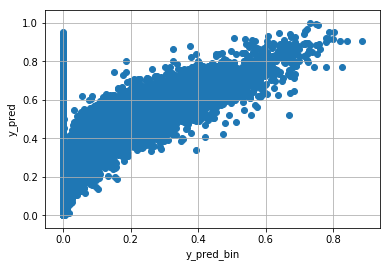

In [113]:
plt.scatter(y_predictions1, y_predictions)
plt.xlabel("y_pred_bin")
plt.ylabel("y_pred")
plt.grid()
plt.show()

In [107]:
pd.DataFrame(np.array([y_predictions1,y_predictions]).transpose(), columns = ['y_pred_bin', 'y_pred']).describe()

,y_pred_bin,y_pred
count,300685.0000,300685.0000
mean,0.1071,0.1395
std,0.1310,0.1364
min,0.0000,0.0000
25%,0.0204,0.0427
50%,0.0561,0.0916
75%,0.1411,0.1912
max,0.9884,1.0000


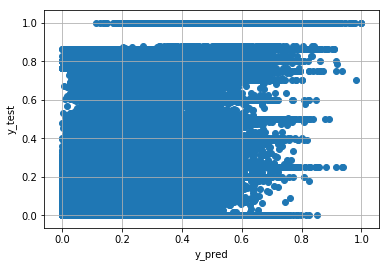

In [108]:
plt.scatter(y_predictions, y_test)
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.grid()
plt.show()

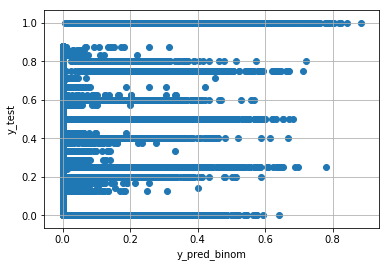

In [147]:
plt.scatter(y_predictions1, y_test)
plt.xlabel("y_pred_binom")
plt.ylabel("y_test")
plt.grid()
plt.show()

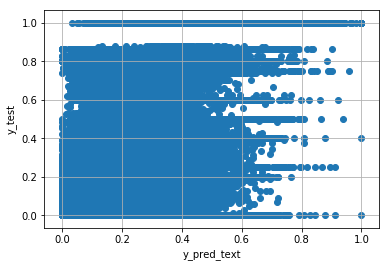

In [130]:
plt.scatter(y_predictions_text, y_test)
plt.xlabel("y_pred_text")
plt.ylabel("y_test")
plt.grid()
plt.show()

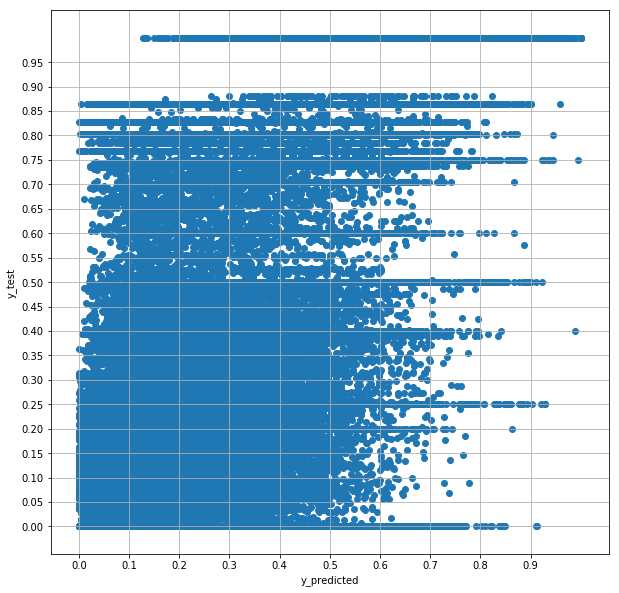

In [171]:
fig = plt.figure(figsize =(10,10))
plt.scatter(y_pr, y_test)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.xlabel("y_predicted")
plt.ylabel("y_test")
plt.grid()
plt.show()

### Dances with weighted average

In [196]:
y_text = y_predictions_text.copy()
y_main = y_predic.copy()

In [197]:
y_text = 0.4*y_text + 0.6*y_main
y_main = 0.6*y_main + 0.4*y_text

In [202]:
y_p = (0.05*y_predictions1 + 0.45*y_main + 0.5*y_text).clip(0,1)
sqrt(mean_squared_error(y_p, y_test))

0.2184689710414451

### Submission

In [175]:
my_predictions = pd.DataFrame(model.predict(X_main.loc[ind_test], num_iteration = model.best_iteration), columns = ["my_predictions"])
my_predictions = np.array(my_predictions['my_predictions'].clip(0, 1))

In [176]:
my_predictions1 = model1.predict(X_main.loc[ind_test], num_iteration = model1.best_iteration)

In [177]:
my_predictions_bin = model2.predict(X_main.loc[ind_test], num_iteration = model2.best_iteration)
my_predictions_bin_b = my_predictions_bin > 0.45
my_predictions_bin_b = my_predictions_bin_b.astype(int)

In [178]:
my_predic = 0.15*my_predictions_bin_b +  my_predictions
my_predic = my_predic.clip(0,1)

In [179]:
%%time
my_predictions_text = model_text.predict(vectors_test, num_iteration = model_text.best_iteration).clip(0, 1)

Wall time: 1h 30min 19s


In [180]:
pd.Series(my_predictions_text).to_csv("text_prediction_text_test_set.csv", index=False)

In [181]:
my_pr = 0.05*my_predictions1 +  0.47*my_predic + 0.51*my_predictions_text

In [118]:
my_pr = 0.04*my_predictions1 +  0.74*my_predictions + 0.22*my_predictions_text

In [182]:
my_pr = my_pr.clip(0,1)

In [183]:
len(my_pr)

508438

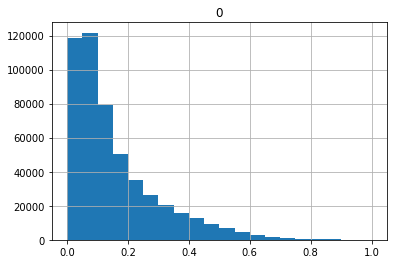

In [184]:
pd.DataFrame(my_pr).hist(bins=20)
plt.show()

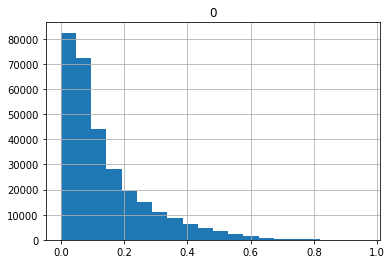

In [125]:
pd.DataFrame(y_pr).hist(bins=20)
plt.show()

In [189]:
my_submission = pd.DataFrame(df.loc[ind_test,'item_id']).reset_index().join(pd.DataFrame(my_pr, columns=['deal_probability']))

In [190]:
my_submission = my_submission.drop(['index'], axis=1)

In [191]:
my_submission

,item_id,deal_probability
0,6544e41a8817,0.3053
1,65b9484d670f,0.1792
2,8bab230b2ecd,0.1972
3,8e348601fefc,0.0913
4,8bd2fe400b89,0.1708
5,c63dbd6c657f,0.1177
6,6d1a410df86e,0.0369
7,e8d3e7922b80,0.0001
8,2bc1ab208462,0.0358
9,7e05d77a9181,0.0526


In [192]:
my_submission.to_csv("my_submission.csv", index=False)